# Ambiguity Classification

This notebook predicts trial-level **ambiguity** from physiological and behavioral data.

## Problem Definition

**Task**: Binary classification of ambiguity level
- **Low ambiguity**: Trials with ambiguity = 0 (no ambiguity)
- **High ambiguity**: Trials with ambiguity = 3 or 6 (some ambiguity)

**Goal**: Determine whether physiological responses (pupil dynamics) and behavioral measures can distinguish between ambiguous and unambiguous decision contexts.

## Features

**Physiological Features** (from pupil data):
- Baseline pupil diameter
- Pre-decision pupil metrics (dilation, velocity, etc.)
- Post-decision pupil metrics

**Behavioral Features**:
- Reaction time
- Decision time
- Expected value difference
- Investment variance
- Social condition
- Risk premium

## Models & Evaluation

We train multiple models with different feature sets:
1. **Physiology only** → Ambiguity
2. **Behavior only** → Ambiguity
3. **Physiology + Behavior** → Ambiguity (combined)

Each model is evaluated using three validation strategies:
- **Random split**: 80/20 train/test split with class balancing
- **Leave-one-subject-out (LOSO)**: Cross-validation across subjects for generalizability
- **Stratified split**: Ensures balanced class distribution in train/test sets

We also test different temporal windows:
- **Baseline**: Features from entire trial
- **Pre → Post**: Pre-decision features predict post-decision physiology
- **Post → Post**: Post-decision features predict post-decision physiology

## 1. Data Loading

Load preprocessed physiology and behavior data from all subjects.

**Data sources**:
- Physiology: Extracted from `preprocessing_*.json` files (pupil features)
- Behavior: Extracted from trial metadata (reaction times, gamble parameters)

In [26]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, 
                            roc_auc_score, roc_curve, precision_recall_curve,
                            f1_score, accuracy_score)
import statsmodels
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import json
from pathlib import Path
import re

## 2. Feature Extraction & Preparation

Extract and organize features for classification.

**Feature organization**:
- **Pre-decision features**: Pupil metrics before decision (baseline, early dilation)
- **Post-decision features**: Pupil metrics after decision (response to outcome)
- **Behavioral features**: Task-related measurements and decision parameters

**Data cleaning**:
- Handle missing values using mean imputation
- Check for multicollinearity in physiological features
- Create separate dataframes for different temporal windows

In [27]:
# =============================================================================
# LOAD ALL SUBJECTS' DATA
# =============================================================================
# Update these paths to your data directories
preprocessed_dir = Path('/Users/pranmodu/Projects/columbia/liinc/data/results/preprocessing')
raw_dir = Path('/Users/pranmodu/Projects/columbia/liinc/data/json')

# Get all preprocessed JSON files
preprocessed_files = list(preprocessed_dir.glob('preprocessing_*.json'))
print(f"Found {len(preprocessed_files)} preprocessed files")

# =============================================================================
# CHOOSE BASELINE METHOD
# =============================================================================
baseline_method = 't3_stable_pre_decision'  # or 't0_initial_fixation', 't1_post_stabilization', 't2_early_post_stimulus'

Found 10 preprocessed files


In [28]:
# =============================================================================
# EXTRACT FEATURES FOR ALL SUBJECTS
# =============================================================================
all_physiology_features = []
all_behavior_features = []
all_ambiguity = []
all_subject_ids = []
all_trial_ids = []

for preprocessed_file in preprocessed_files:
    
    # Load preprocessed data
    with open(preprocessed_file, 'r') as f:
        preprocessed = json.load(f)
    
    subject_id = preprocessed['subject_id']
    print(f"\nProcessing subject: {subject_id}")
    
    # Find corresponding raw data file
    matches = list(raw_dir.glob(f"*{subject_id.split('_')[-1]}.json"))
    pattern = subject_id.replace("_", ".*")  # makes regex flexible for possible text in between
    match = next((f for f in matches if re.search(pattern, f.name)), None)
    if not match:
        print("No matching file found.")
        continue
    
    with open(match, 'r') as f:
        raw_data = json.load(f)
    
    subject_trial_count = 0
    
    for trial_id, trial_data in preprocessed['trial_data'].items():

        # Get the baseline-corrected pupil data for chosen method
        method_data = trial_data['methods'][baseline_method]
        
        if method_data['success'] != True:
            continue
        
        # Get raw trial data for behavioral features
        raw_trial = raw_data['trials'][int(trial_id)-1]
        
        # Skip trials that weren't submitted
        if not raw_trial['gamble details']['submitted']:
            continue
        
        # =============================================================================
        # PHYSIOLOGY FEATURES (PRE + POST SUBMIT)
        # =============================================================================

        # Split data into pre-submit and post-submit periods
        time_aligned = np.array(trial_data['time_relative_to_submit'])
        pupil_avg = np.array(method_data['pupil_avg_baselined'])
        pupil_L = np.array(method_data['pupil_L_baselined'])
        pupil_R = np.array(method_data['pupil_R_baselined'])

        # Remove NaN values
        valid_mask = ~np.isnan(pupil_avg)
        pupil_avg_clean = pupil_avg[valid_mask]
        pupil_L_clean = pupil_L[valid_mask]
        pupil_R_clean = pupil_R[valid_mask]
        time_clean = time_aligned[valid_mask]

        if len(pupil_avg_clean) < 20:
            continue

        # ============= PRE-SUBMIT DATA (for prediction) =============
        pre_submit_mask = time_clean <= 0
        pupil_pre = pupil_avg_clean[pre_submit_mask]
        pupil_L_pre = pupil_L_clean[pre_submit_mask]
        pupil_R_pre = pupil_R_clean[pre_submit_mask]
        time_pre = time_clean[pre_submit_mask]

        # Check minimum samples for pre-submit
        if len(pupil_pre) < 10:
            continue

        # Calculate derivatives for pre-submit
        pupil_velocity_pre = np.diff(pupil_pre) if len(pupil_pre) > 1 else np.array([0])
        pupil_acceleration_pre = np.diff(pupil_velocity_pre) if len(pupil_velocity_pre) > 1 else np.array([0])
        dilation_mask_pre = pupil_velocity_pre > 0 if len(pupil_velocity_pre) > 0 else np.array([False])

        # ============= POST-SUBMIT DATA (for ambiguity response) =============
        post_submit_mask = (time_clean > 0) & (time_clean <= 2.0)
        pupil_post = pupil_avg_clean[post_submit_mask]
        pupil_L_post = pupil_L_clean[post_submit_mask]
        pupil_R_post = pupil_R_clean[post_submit_mask]
        time_post = time_clean[post_submit_mask]

        # Calculate derivatives for post-submit (if enough samples)
        if len(pupil_post) > 1:
            pupil_velocity_post = np.diff(pupil_post)
            pupil_acceleration_post = np.diff(pupil_velocity_post) if len(pupil_velocity_post) > 1 else np.array([0])
            dilation_mask_post = pupil_velocity_post > 0 if len(pupil_velocity_post) > 0 else np.array([False])
        else:
            pupil_velocity_post = np.array([0])
            pupil_acceleration_post = np.array([0])
            dilation_mask_post = np.array([False])

        # =============================================================================
        # EXTRACT FEATURES FOR BOTH PERIODS
        # =============================================================================

        physiology_features = {
            # ==================== PRE-SUBMIT FEATURES ====================
            # Central tendency
            'pupil_mean_pre': np.mean(pupil_pre),
            'pupil_std_pre': np.std(pupil_pre),
            
            # Temporal dynamics
            'pupil_slope_pre': np.polyfit(time_pre, pupil_pre, 1)[0] if len(time_pre) > 1 else 0,
            'time_to_peak_pre': time_pre[np.argmax(pupil_pre)] - time_pre[0] if len(time_pre) > 0 else 0,
            
            # Change from start to end
            'pupil_change_pre': (np.mean(pupil_pre[-min(10, len(pupil_pre)):]) - 
                                np.mean(pupil_pre[:min(10, len(pupil_pre))])) if len(pupil_pre) >= 10 else 0,
            
            # Variability
            'pupil_cv_pre': np.std(pupil_pre) / np.abs(np.mean(pupil_pre)) if (len(pupil_pre) > 0 and np.mean(pupil_pre) != 0) else 0,
            
            # Velocity metrics
            'pupil_velocity_mean_pre': np.mean(np.abs(pupil_velocity_pre)) if len(pupil_velocity_pre) > 0 else 0,
            'pupil_max_dilation_rate_pre': np.max(pupil_velocity_pre) if len(pupil_velocity_pre) > 0 else 0,
            'pupil_max_constriction_rate_pre': np.abs(np.min(pupil_velocity_pre)) if len(pupil_velocity_pre) > 0 else 0,
            
            # Acceleration
            'pupil_acceleration_std_pre': np.std(pupil_acceleration_pre) if len(pupil_acceleration_pre) > 1 else 0,
            
            # Temporal patterns
            'pct_time_dilating_pre': np.mean(dilation_mask_pre) if len(dilation_mask_pre) > 0 else 0,
            'num_dilation_peaks_pre': np.sum(np.diff(np.sign(pupil_velocity_pre)) > 0) if len(pupil_velocity_pre) > 1 else 0,
            
            # Eye asymmetry
            'eye_asymmetry_pre': np.nanmean(np.abs(pupil_L_pre - pupil_R_pre)) if len(pupil_L_pre) > 0 else 0,
            'eye_asymmetry_std_pre': np.nanstd(pupil_L_pre - pupil_R_pre) if len(pupil_L_pre) > 1 else 0,
            
            # ==================== POST-SUBMIT FEATURES ====================
            # Central tendency
            'pupil_mean_post': np.mean(pupil_post) if len(pupil_post) > 0 else 0,
            'pupil_std_post': np.std(pupil_post) if len(pupil_post) > 1 else 0,
            
            # Temporal dynamics
            'pupil_slope_post': np.polyfit(time_post, pupil_post, 1)[0] if len(time_post) > 1 else 0,
            'time_to_peak_post': time_post[np.argmax(pupil_post)] - time_post[0] if len(time_post) > 0 else 0,
            
            # Variability
            'pupil_cv_post': np.std(pupil_post) / np.abs(np.mean(pupil_post)) if (len(pupil_post) > 0 and np.mean(pupil_post) != 0) else 0,
            
            # Velocity metrics
            'pupil_velocity_mean_post': np.mean(np.abs(pupil_velocity_post)) if len(pupil_velocity_post) > 0 else 0,
            'pupil_max_dilation_rate_post': np.max(pupil_velocity_post) if len(pupil_velocity_post) > 0 else 0,
            'pupil_max_constriction_rate_post': np.abs(np.min(pupil_velocity_post)) if len(pupil_velocity_post) > 0 else 0,
            
            # Temporal patterns
            'pct_time_dilating_post': np.mean(dilation_mask_post) if len(dilation_mask_post) > 0 else 0,
            'num_dilation_peaks_post': np.sum(np.diff(np.sign(pupil_velocity_post)) > 0) if len(pupil_velocity_post) > 1 else 0,
            
            # Eye asymmetry
            'eye_asymmetry_post': np.nanmean(np.abs(pupil_L_post - pupil_R_post)) if len(pupil_L_post) > 0 else 0,
            'eye_asymmetry_std_post': np.nanstd(pupil_L_post - pupil_R_post) if len(pupil_L_post) > 1 else 0,
            
            # ==================== TRANSITION FEATURES ====================
            # Compare pre vs post
            'pupil_mean_change_pre_to_post': (np.mean(pupil_post) - np.mean(pupil_pre)) if len(pupil_post) > 0 and len(pupil_pre) > 0 else 0,
            'pupil_slope_change_pre_to_post': ((np.polyfit(time_post, pupil_post, 1)[0] if len(time_post) > 1 else 0) - 
                                            (np.polyfit(time_pre, pupil_pre, 1)[0] if len(time_pre) > 1 else 0)),
            
            # ==================== BASELINE ====================
            'baseline_L': method_data['baseline_L'],
            'baseline_R': method_data['baseline_R'],
            'baseline_avg': (method_data['baseline_L'] + method_data['baseline_R']) / 2,
        }
        
        # =============================================================================
        # BEHAVIOR FEATURES (from raw trial data)
        # =============================================================================
        gamble_params = raw_trial['gamble details']['gamble parameters']
        lct = raw_trial['lct']
        
        # Extract timing information
        show_screen_time = None
        submit_time = None
        click_time = None
        
        for event in lct:
            if 'show screen' in event['event']:
                show_screen_time = event['time']
            elif 'gamble clicked' in event['event']:
                click_time = event['time']
            elif 'submit' in event['event']:
                submit_time = event['time']
        
        if show_screen_time is None or submit_time is None:
            continue
        
        # Calculate timing metrics (convert to seconds)
        reaction_time = (click_time - show_screen_time) / 1000 if click_time else np.nan
        decision_time = (submit_time - show_screen_time) / 1000

        # Calculate expected values
        invest_ev = (gamble_params['invest amount 1'] * gamble_params['invest probability 1'] + 
                    gamble_params['invest amount 2'] * gamble_params['invest probability 2'])
        keep_ev = gamble_params['keep amount']
        ev_difference = invest_ev - keep_ev

        # Calculate variance
        invest_variance = ((gamble_params['invest amount 1'] - invest_ev)**2 * gamble_params['invest probability 1'] +
                        (gamble_params['invest amount 2'] - invest_ev)**2 * gamble_params['invest probability 2'])
        
        # Choice information
        final_choice = raw_trial['gamble details']['choices'][-1]['choice'] if len(raw_trial['gamble details']['choices']) > 0 else None
        chose_invest = 1 if final_choice == 'INVEST' else 0
        
        behavior_features = {
            # TIMING - Independent information
            'reaction_time': reaction_time if not np.isnan(reaction_time) else decision_time,
            'decision_time': decision_time,
            
            # GAMBLE PARAMETERS 
            'ev_difference': ev_difference,  # Captures relative attractiveness
            
            # RISK - Independent from EV
            'invest_variance': invest_variance,  # OR use std: np.sqrt(invest_variance)
            
            # CONDITION - Independent  
            'condition_social': 1 if gamble_params['condition'] == 'social' else 0,
            
            # NORMALIZED RISK METRIC - Independent combination
            'risk_premium': ev_difference / np.sqrt(invest_variance) if invest_variance > 0 else 0,
        }
                
        # =============================================================================
        # AMBIGUITY VARIABLE
        # =============================================================================
        ambiguity = gamble_params['ambiguity']  # Extract ambiguity level from gamble parameters
        
        # Store everything
        all_physiology_features.append(physiology_features)
        all_behavior_features.append(behavior_features)
        all_ambiguity.append(ambiguity)
        all_subject_ids.append(subject_id)
        all_trial_ids.append(f"{trial_id}_{subject_id}")
        
        subject_trial_count += 1
    
    print(f"  Extracted {subject_trial_count} valid trials")

# =============================================================================
# CREATE DATAFRAMES
# =============================================================================
physiology_df = pd.DataFrame(all_physiology_features)
physiology_df.insert(0, 'subject_id', all_subject_ids)
physiology_df.insert(1, 'trial_id', all_trial_ids)

behavior_df = pd.DataFrame(all_behavior_features)
behavior_df.insert(0, 'subject_id', all_subject_ids)
behavior_df.insert(1, 'trial_id', all_trial_ids)

ambiguity = np.array(all_ambiguity)
subjects = np.array(all_subject_ids)

print(f"\n{'='*80}")
print(f"DATA SUMMARY (ALL SUBJECTS)")
print(f"{'='*80}")
print(f"Total subjects: {len(np.unique(subjects))}")
print(f"Total valid trials: {len(ambiguity)}")
print(f"Physiology features: {physiology_df.shape[1]}")
print(f"Behavior features: {behavior_df.shape[1]}")
print(f"\nAmbiguity level distribution:")
print(f"  Low (0): {np.sum(ambiguity == 0)} ({np.mean(ambiguity == 0):.1%})")
print(f"  High (1): {np.sum(ambiguity == 1)} ({np.mean(ambiguity == 1):.1%})")

# Per-subject breakdown
print(f"\nPer-subject trial counts:")
subject_counts = pd.DataFrame({'subject': subjects, 'ambiguity_level': ambiguity})
print(subject_counts.groupby('subject')['ambiguity_level'].agg(['count', 'mean']))

# Check for missing values
print(f"\nMissing values in physiology features:")
missing_physio = physiology_df.isnull().sum()
if missing_physio.sum() > 0:
    print(missing_physio[missing_physio > 0])
else:
    print("None!")

print(f"\nMissing values in behavior features:")
missing_behavior = behavior_df.isnull().sum()
if missing_behavior.sum() > 0:
    print(missing_behavior[missing_behavior > 0])
else:
    print("None!")


Processing subject: 0928_1600_U9TEJGM
  Extracted 93 valid trials

Processing subject: 0930_1700_U9TEJGM
  Extracted 123 valid trials

Processing subject: 1005_1600_U9TEJGM
  Extracted 51 valid trials

Processing subject: 0930_1700_539136F
  Extracted 95 valid trials

Processing subject: 0928_1600_539136F
  Extracted 110 valid trials

Processing subject: 1005_1600_539136F
  Extracted 121 valid trials

Processing subject: 0928_1600_9M4VCHG
  Extracted 117 valid trials

Processing subject: 0930_1700_9M4VCHG
  Extracted 112 valid trials

Processing subject: 0927_0930_U9TEJGM
  Extracted 99 valid trials

Processing subject: 1005_1600_9M4VCHG
  Extracted 123 valid trials

DATA SUMMARY (ALL SUBJECTS)
Total subjects: 10
Total valid trials: 1044
Physiology features: 33
Behavior features: 8

Ambiguity level distribution:
  Low (0): 347 (33.2%)
  High (1): 0 (0.0%)

Per-subject trial counts:
                   count      mean
subject                           
0927_0930_U9TEJGM     99  3.151515

In [29]:
pre_cols = [col for col in physiology_df.columns if '_pre' in col or 'baseline' in col]
print(pre_cols)
post_cols = [col for col in physiology_df.columns if '_post' in col or 'baseline' in col]
print(post_cols)

['pupil_mean_pre', 'pupil_std_pre', 'pupil_slope_pre', 'time_to_peak_pre', 'pupil_change_pre', 'pupil_cv_pre', 'pupil_velocity_mean_pre', 'pupil_max_dilation_rate_pre', 'pupil_max_constriction_rate_pre', 'pupil_acceleration_std_pre', 'pct_time_dilating_pre', 'num_dilation_peaks_pre', 'eye_asymmetry_pre', 'eye_asymmetry_std_pre', 'pupil_mean_change_pre_to_post', 'pupil_slope_change_pre_to_post', 'baseline_L', 'baseline_R', 'baseline_avg']
['pupil_mean_post', 'pupil_std_post', 'pupil_slope_post', 'time_to_peak_post', 'pupil_cv_post', 'pupil_velocity_mean_post', 'pupil_max_dilation_rate_post', 'pupil_max_constriction_rate_post', 'pct_time_dilating_post', 'num_dilation_peaks_post', 'eye_asymmetry_post', 'eye_asymmetry_std_post', 'pupil_mean_change_pre_to_post', 'pupil_slope_change_pre_to_post', 'baseline_L', 'baseline_R', 'baseline_avg']


In [30]:
physiology_df

,subject_id,trial_id,pupil_mean_pre,pupil_std_pre,pupil_slope_pre,time_to_peak_pre,pupil_change_pre,pupil_cv_pre,pupil_velocity_mean_pre,pupil_max_dilation_rate_pre,...,pupil_max_constriction_rate_post,pct_time_dilating_post,num_dilation_peaks_post,eye_asymmetry_post,eye_asymmetry_std_post,pupil_mean_change_pre_to_post,pupil_slope_change_pre_to_post,baseline_L,baseline_R,baseline_avg
0,0928_1600_U9TEJGM,4_0928_1600_U9TEJGM,0.025747,0.600433,-0.887872,0.249962,-1.162754,23.320559,0.047701,0.159757,...,0.041880,0.571429,4,1.947865,0.799251,0.024053,1.727285,0.385186,-0.646653,-0.130734
1,0928_1600_U9TEJGM,9_0928_1600_U9TEJGM,0.447229,0.273984,-0.071215,1.199820,0.140531,0.612625,0.037372,0.132774,...,0.085567,0.512605,6,0.840462,0.961168,0.105395,0.735737,-0.401363,-0.434381,-0.417872
2,0928_1600_U9TEJGM,10_0928_1600_U9TEJGM,-0.133402,0.235444,-0.154442,0.283291,0.164866,1.764922,0.029469,0.105264,...,0.082252,0.546218,5,2.797592,0.772804,0.094350,0.511445,0.852446,-0.949945,-0.048750
3,0928_1600_U9TEJGM,13_0928_1600_U9TEJGM,0.112158,0.420877,-0.459861,0.000000,-1.264087,3.752537,0.041500,0.093582,...,0.099197,0.705882,5,0.728148,0.594755,0.681989,1.330580,-1.065998,-0.272744,-0.669371
4,0928_1600_U9TEJGM,14_0928_1600_U9TEJGM,0.473647,0.163630,0.021084,0.316619,-0.064944,0.345468,0.023148,0.078801,...,0.488948,0.588235,6,0.714150,0.869629,-0.104471,-0.081926,-0.761234,-0.474944,-0.618089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039,1005_1600_9M4VCHG,127_1005_1600_9M4VCHG,0.020989,0.085878,-0.073127,0.699983,0.064608,4.091614,0.009521,0.025306,...,0.028283,0.554622,4,0.130786,0.114521,0.361748,0.548191,-0.301158,-0.163690,-0.232424
1040,1005_1600_9M4VCHG,128_1005_1600_9M4VCHG,0.202468,0.364592,-0.595604,0.349991,-0.782873,1.800738,0.016513,0.038453,...,0.051750,0.781513,2,0.105787,0.160191,-0.062029,0.793070,-0.272404,-0.363283,-0.317844
1041,1005_1600_9M4VCHG,129_1005_1600_9M4VCHG,0.054047,0.290519,-0.402281,0.149996,-0.881716,5.375273,0.016987,0.023292,...,0.045766,0.655462,3,0.225155,0.121863,-0.080505,0.568160,-0.303054,-0.112461,-0.207758
1042,1005_1600_9M4VCHG,130_1005_1600_9M4VCHG,0.206058,0.390699,-0.577294,0.316659,-0.928542,1.896065,0.015856,0.026724,...,0.011397,0.605042,4,0.437918,1.252414,0.030301,1.053241,-0.282334,-0.341956,-0.312145


In [31]:
behavior_df

,subject_id,trial_id,reaction_time,decision_time,ev_difference,invest_variance,condition_social,risk_premium
0,0928_1600_U9TEJGM,4_0928_1600_U9TEJGM,0.003120,0.003809,-0.059,77.938419,0,-0.006683
1,0928_1600_U9TEJGM,9_0928_1600_U9TEJGM,0.002609,0.003631,0.827,14.735571,0,0.215438
2,0928_1600_U9TEJGM,10_0928_1600_U9TEJGM,0.003532,0.004365,0.586,32.854404,1,0.102235
3,0928_1600_U9TEJGM,13_0928_1600_U9TEJGM,0.002743,0.004208,0.172,57.335616,0,0.022715
4,0928_1600_U9TEJGM,14_0928_1600_U9TEJGM,0.001410,0.002254,0.669,25.313739,0,0.132968
...,...,...,...,...,...,...,...,...
1039,1005_1600_9M4VCHG,127_1005_1600_9M4VCHG,0.000877,0.001632,0.728,20.054016,0,0.162566
1040,1005_1600_9M4VCHG,128_1005_1600_9M4VCHG,0.002654,0.003543,0.178,67.289716,1,0.021699
1041,1005_1600_9M4VCHG,129_1005_1600_9M4VCHG,0.000899,0.001755,0.829,10.503459,0,0.255793
1042,1005_1600_9M4VCHG,130_1005_1600_9M4VCHG,0.001088,0.002166,0.812,7.011456,1,0.306656


In [32]:
physiology_df_pre = physiology_df[['subject_id', 'trial_id'] + pre_cols]
physiology_df_post = physiology_df[['subject_id', 'trial_id'] + post_cols]  

In [33]:
from sklearn.impute import SimpleImputer

print(f"Before imputation: {physiology_df.isnull().sum().sum()} NaN values")

physiology_df_numerical = physiology_df.drop(columns=['subject_id', 'trial_id'])
columns = list(physiology_df_numerical.columns)

imputer = SimpleImputer(strategy='median')
physiology_df_numerical = pd.DataFrame(
    imputer.fit_transform(physiology_df_numerical),
    columns=columns,
    index=physiology_df_numerical.index
)

print(f"After imputation: {physiology_df_numerical.isnull().sum().sum()} NaN values")

Before imputation: 0 NaN values
After imputation: 0 NaN values



MULTICOLLINEARITY ANALYSIS - PHYSIOLOGY FEATURES

⚠️  Highly correlated feature pairs (|r| > 0.9):
None


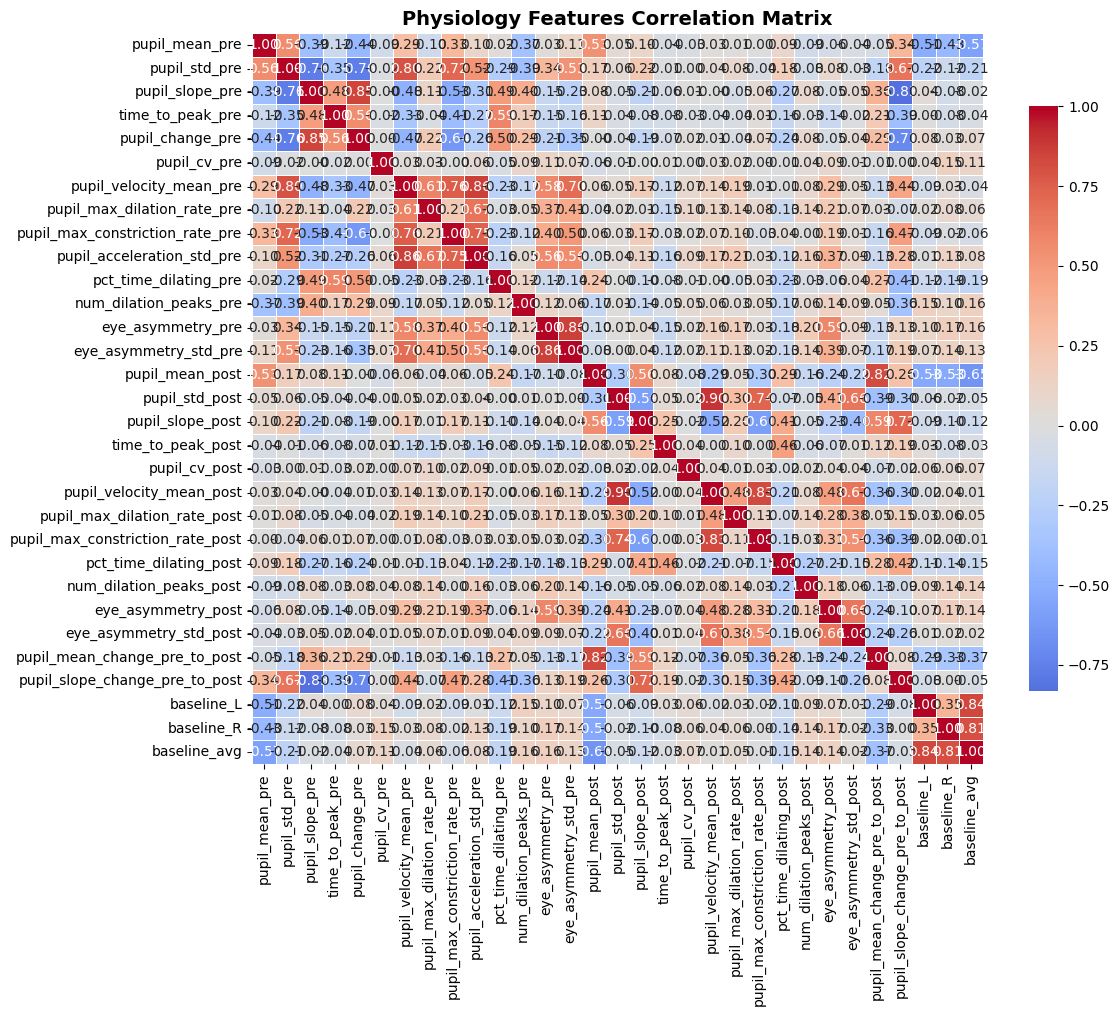

In [34]:
# =============================================================================
# CHECK MULTICOLLINEARITY IN PHYSIOLOGY FEATURES
# =============================================================================
print(f"\n{'='*80}")
print(f"MULTICOLLINEARITY ANALYSIS - PHYSIOLOGY FEATURES")
print(f"{'='*80}")

# Calculate correlation matrix
physiology_corr = physiology_df_numerical.corr()

# Find highly correlated pairs (>0.9)
high_corr_pairs = []
for i in range(len(physiology_corr.columns)):
    for j in range(i+1, len(physiology_corr.columns)):
        if abs(physiology_corr.iloc[i, j]) > 0.9:
            high_corr_pairs.append({
                'feature_1': physiology_corr.columns[i],
                'feature_2': physiology_corr.columns[j],
                'correlation': physiology_corr.iloc[i, j]
            })

print(f"\n⚠️  Highly correlated feature pairs (|r| > 0.9):")
if len(high_corr_pairs) == 0:
    print('None')
for pair in high_corr_pairs:
    print(f"  {pair['feature_1']} <-> {pair['feature_2']}: {pair['correlation']:.3f}")

# Visualize correlation matrix
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(physiology_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
ax.set_title('Physiology Features Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 3. Exploratory Data Analysis (EDA) - Ambiguity Variable

Examine the distribution of ambiguity levels and their relationship with features.

**Ambiguity levels in the task**:
- 0 = No ambiguity (precise probabilities known)
- 3 = Medium ambiguity
- 6 = High ambiguity (probabilities uncertain)

**For binary classification**, we combine levels:
- **Class 0**: Ambiguity = 0 (low)
- **Class 1**: Ambiguity = 3 or 6 (high)

In [35]:
# =============================================================================
# AMBIGUITY VARIABLE - EXPLORATORY DATA ANALYSIS
# =============================================================================

print(f"\n{'='*80}")
print(f"AMBIGUITY VARIABLE - EXPLORATORY DATA ANALYSIS")
print(f"{'='*80}")

# Basic statistics
print(f"\nAmbiguity Variable Statistics:")
print(f"  Total samples: {len(ambiguity)}")
print(f"  Unique values: {np.unique(ambiguity)}")
print(f"  Value counts:")
print(f"    Low (0): {np.sum(ambiguity == 0)} ({np.sum(ambiguity == 0) / len(ambiguity) * 100:.1f}%)")
print(f"  Medium Ambiguity (3): {np.sum(ambiguity == 3)} ({np.sum(ambiguity == 3) / len(ambiguity) * 100:.1f}%)")
print(f"  High Ambiguity (6): {np.sum(ambiguity == 6)} ({np.sum(ambiguity == 6) / len(ambiguity) * 100:.1f}%)")

# Class balance
print(f"\nClass Balance:")
class_counts = [np.sum(ambiguity == 0), np.sum(ambiguity == 3), np.sum(ambiguity == 6)]
class_pcts = [c / len(ambiguity) * 100 for c in class_counts]
for val, cnt, pct in zip([0, 3, 6], class_counts, class_pcts):
    print(f"  Level {val}: {cnt:4d} ({pct:5.1f}%)")
# Check if balanced (each class should be ~33.3%)
max_diff = max(class_pcts) - min(class_pcts)
if max_diff < 10:
    print(f"  ✓ Classes are relatively balanced (max diff: {max_diff:.1f}%)")
else:
    print(f"  ⚠ Classes are imbalanced (max diff: {max_diff:.1f}%) - consider using class weights")

# Distribution by subject
print(f"\nAmbiguity Distribution by Subject:")
subject_ambiguity = pd.DataFrame({
    'subject_id': subjects,
    'ambiguity': ambiguity
})

subject_stats = subject_ambiguity.groupby('subject_id')['ambiguity'].agg([
    ('n_trials', 'count'),
    ('n_amb0', lambda x: np.sum(x == 0)),
    ('n_amb3', lambda x: np.sum(x == 3)),
    ('n_amb6', lambda x: np.sum(x == 6)),
    ('pct_amb6', lambda x: np.sum(x == 6) / len(x) * 100)
]).round(1)

print(subject_stats.to_string())



AMBIGUITY VARIABLE - EXPLORATORY DATA ANALYSIS

Ambiguity Variable Statistics:
  Total samples: 1044
  Unique values: [0 3 6]
  Value counts:
    Low (0): 347 (33.2%)
  Medium Ambiguity (3): 342 (32.8%)
  High Ambiguity (6): 355 (34.0%)

Class Balance:
  Level 0:  347 ( 33.2%)
  Level 3:  342 ( 32.8%)
  Level 6:  355 ( 34.0%)
  ✓ Classes are relatively balanced (max diff: 1.2%)

Ambiguity Distribution by Subject:
                   n_trials  n_amb0  n_amb3  n_amb6  pct_amb6
subject_id                                                   
0927_0930_U9TEJGM        99      31      32      36      36.4
0928_1600_539136F       110      39      37      34      30.9
0928_1600_9M4VCHG       117      39      39      39      33.3
0928_1600_U9TEJGM        93      32      30      31      33.3
0930_1700_539136F        95      34      29      32      33.7
0930_1700_9M4VCHG       112      36      37      39      34.8
0930_1700_U9TEJGM       123      41      41      41      33.3
1005_1600_539136F       

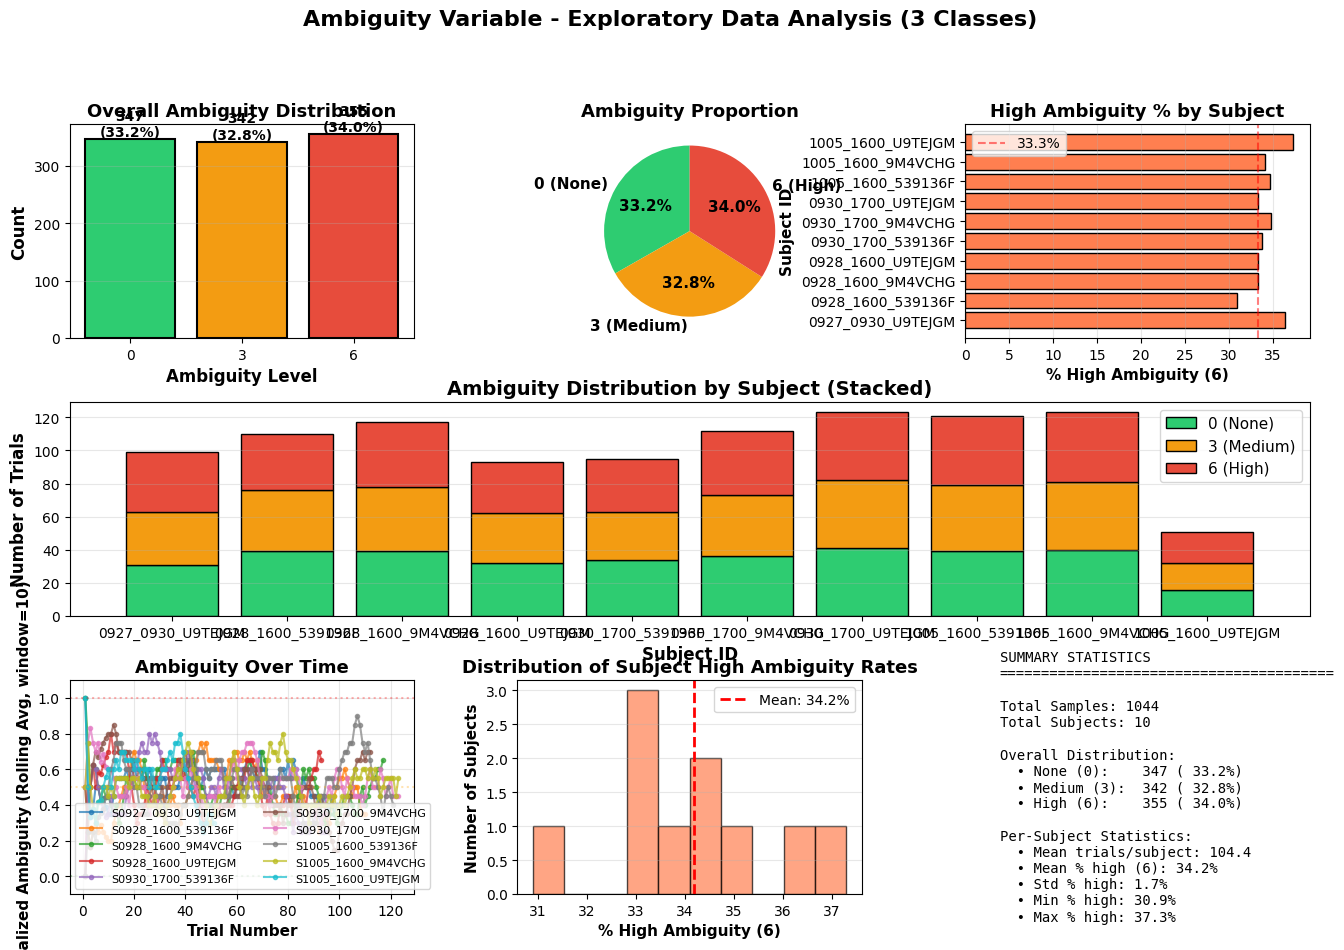


EDA Complete - Ready for Multi-Class Classification Tasks


In [36]:
# =============================================================================
# AMBIGUITY VISUALIZATIONS - 3 CLASSES (0, 3, 6)
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Overall Distribution
ax1 = fig.add_subplot(gs[0, 0])
counts = [np.sum(ambiguity == 0), np.sum(ambiguity == 3), np.sum(ambiguity == 6)]
colors = ['#2ecc71', '#f39c12', '#e74c3c']  # Green, Orange, Red
bars = ax1.bar(['0', '3', '6'], counts, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Ambiguity Level', fontsize=12, fontweight='bold')
ax1.set_ylabel('Count', fontsize=12, fontweight='bold')
ax1.set_title('Overall Ambiguity Distribution', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
# Add count labels
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{count}\n({count/len(ambiguity)*100:.1f}%)',
             ha='center', va='bottom', fontweight='bold')

# 2. Pie Chart
ax2 = fig.add_subplot(gs[0, 1])
ax2.pie(counts, labels=['0 (None)', '3 (Medium)', '6 (High)'], autopct='%1.1f%%', colors=colors,
        startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
ax2.set_title('Ambiguity Proportion', fontsize=13, fontweight='bold')

# 3. Distribution by Subject (High Ambiguity %)
ax3 = fig.add_subplot(gs[0, 2])
subject_pct = subject_stats['pct_amb6'].values
ax3.barh(range(len(subject_pct)), subject_pct, color='coral', edgecolor='black')
ax3.set_yticks(range(len(subject_pct)))
ax3.set_yticklabels(subject_stats.index)
ax3.set_xlabel('% High Ambiguity (6)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Subject ID', fontsize=11, fontweight='bold')
ax3.set_title('High Ambiguity % by Subject', fontsize=13, fontweight='bold')
ax3.axvline(33.3, color='red', linestyle='--', alpha=0.5, label='33.3%')
ax3.legend()
ax3.grid(axis='x', alpha=0.3)

# 4. Stacked Bar Chart by Subject
ax4 = fig.add_subplot(gs[1, :])
subjects_unique = subject_stats.index
amb0_counts = subject_stats['n_amb0'].values
amb3_counts = subject_stats['n_amb3'].values
amb6_counts = subject_stats['n_amb6'].values
x_pos = np.arange(len(subjects_unique))
ax4.bar(x_pos, amb0_counts, label='0 (None)', color='#2ecc71', edgecolor='black')
ax4.bar(x_pos, amb3_counts, bottom=amb0_counts, label='3 (Medium)', color='#f39c12', edgecolor='black')
ax4.bar(x_pos, amb6_counts, bottom=amb0_counts+amb3_counts, label='6 (High)', color='#e74c3c', edgecolor='black')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(subjects_unique)
ax4.set_xlabel('Subject ID', fontsize=12, fontweight='bold')
ax4.set_ylabel('Number of Trials', fontsize=12, fontweight='bold')
ax4.set_title('Ambiguity Distribution by Subject (Stacked)', fontsize=14, fontweight='bold')
ax4.legend(fontsize=11)
ax4.grid(axis='y', alpha=0.3)

# 5. Ambiguity vs Trial Number (temporal pattern)
ax5 = fig.add_subplot(gs[2, 0])
# Add trial number within subject
subject_ambiguity_sorted = subject_ambiguity.copy()
subject_ambiguity_sorted['trial_num'] = subject_ambiguity_sorted.groupby('subject_id').cumcount() + 1
# Calculate rolling average (normalized to 0-1 scale: 0->0, 3->0.5, 6->1)
window = 10
subject_ambiguity_sorted['amb_normalized'] = subject_ambiguity_sorted['ambiguity'] / 6.0
subject_ambiguity_sorted['rolling_avg'] = subject_ambiguity_sorted.groupby('subject_id')['amb_normalized'].transform(
    lambda x: x.rolling(window=window, min_periods=1).mean()
)
# Plot for each subject
for subj in subjects_unique:
    subj_data = subject_ambiguity_sorted[subject_ambiguity_sorted['subject_id'] == subj]
    ax5.plot(subj_data['trial_num'], subj_data['rolling_avg'], marker='o', markersize=3, alpha=0.7, label=f'S{subj}')
ax5.set_xlabel('Trial Number', fontsize=11, fontweight='bold')
ax5.set_ylabel(f'Normalized Ambiguity (Rolling Avg, window={window})', fontsize=11, fontweight='bold')
ax5.set_title('Ambiguity Over Time', fontsize=13, fontweight='bold')
ax5.legend(fontsize=8, ncol=2)
ax5.grid(alpha=0.3)
ax5.set_ylim([-0.1, 1.1])
# Add reference lines
ax5.axhline(0.0, color='green', linestyle=':', alpha=0.3, label='0')
ax5.axhline(0.5, color='orange', linestyle=':', alpha=0.3, label='3')
ax5.axhline(1.0, color='red', linestyle=':', alpha=0.3, label='6')

# 6. Histogram of per-subject high ambiguity rates
ax6 = fig.add_subplot(gs[2, 1])
ax6.hist(subject_pct, bins=10, color='coral', edgecolor='black', alpha=0.7)
ax6.axvline(subject_pct.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {subject_pct.mean():.1f}%')
ax6.set_xlabel('% High Ambiguity (6)', fontsize=11, fontweight='bold')
ax6.set_ylabel('Number of Subjects', fontsize=11, fontweight='bold')
ax6.set_title('Distribution of Subject High Ambiguity Rates', fontsize=13, fontweight='bold')
ax6.legend()
ax6.grid(axis='y', alpha=0.3)

# 7. Summary statistics table
ax7 = fig.add_subplot(gs[2, 2])
ax7.axis('off')
summary_text = f"""
SUMMARY STATISTICS
{'='*40}

Total Samples: {len(ambiguity)}
Total Subjects: {len(subjects_unique)}

Overall Distribution:
  • None (0):   {np.sum(ambiguity == 0):4d} ({np.sum(ambiguity == 0)/len(ambiguity)*100:5.1f}%)
  • Medium (3): {np.sum(ambiguity == 3):4d} ({np.sum(ambiguity == 3)/len(ambiguity)*100:5.1f}%)
  • High (6):   {np.sum(ambiguity == 6):4d} ({np.sum(ambiguity == 6)/len(ambiguity)*100:5.1f}%)

Per-Subject Statistics:
  • Mean trials/subject: {subject_stats['n_trials'].mean():.1f}
  • Mean % high (6): {subject_pct.mean():.1f}%
  • Std % high: {subject_pct.std():.1f}%
  • Min % high: {subject_pct.min():.1f}%
  • Max % high: {subject_pct.max():.1f}%
"""
ax7.text(0.1, 0.5, summary_text, fontsize=10, family='monospace',
         verticalalignment='center', transform=ax7.transAxes)

plt.suptitle('Ambiguity Variable - Exploratory Data Analysis (3 Classes)', fontsize=16, fontweight='bold', y=0.995)
plt.show()

print("\n" + "="*80)
print("EDA Complete - Ready for Multi-Class Classification Tasks")
print("="*80)


## 4. TASK 2: PHYSIOLOGY → AMBIGUITY (Direct)

Classify ambiguity using **physiological features only** (pupil dynamics).

**Hypothesis**: Pupil dilation patterns differ between ambiguous and unambiguous trials due to cognitive load and uncertainty processing.

**Model**: Random Forest Classifier
- Non-linear model captures complex pupil response patterns
- Robust to noise and missing values

We test three validation approaches and three temporal windows for comprehensive evaluation.

## Random, Balanced Split

### Baseline Classification

In [40]:
# =============================================================================
# TASK 2: PHYSIOLOGY → AMBIGUITY (Direct)
# =============================================================================
print(f"\n{'='*80}")
print(f"TASK 2: PHYSIOLOGY → AMBIGUITY (Direct)")
print(f"{'='*80}")

# Prepare data
X_physio = physiology_df.drop(columns=['subject_id', 'trial_id']).values
y = ambiguity

# Check class balance
print(f"\nClass balance check:")
print(f"  Minimum class size: {min(np.bincount(y))}")
print(f"  Class ratio: {np.mean(y):.3f}")

# Train-test split (stratified to maintain class balance)
X_train_physio, X_test_physio, y_train, y_test = train_test_split(
    X_physio, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTraining samples: {len(y_train)} (0: {np.sum(y_train==0)}, 3: {np.sum(y_train==3)}, 6: {np.sum(y_train==6)})")
print(f"Test samples: {len(y_test)} (0: {np.sum(y_test==0)}, 3: {np.sum(y_test==3)}, 6: {np.sum(y_test==6)})")

# Train Random Forest classifier
rf_physio = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced'
)

rf_physio.fit(X_train_physio, y_train)

# Predictions
y_pred_physio = rf_physio.predict(X_test_physio)

# Evaluation
print(f"\n{'='*80}")
print(f"CLASSIFICATION RESULTS")
print(f"{'='*80}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_physio, target_names=['No Ambiguity (0)', 'Medium Ambiguity (3)', 'High Ambiguity (6)']))

accuracy_physio_all = accuracy_score(y_test, y_pred_physio)
f1_physio_all = f1_score(y_test, y_pred_physio, average='weighted')
print(f"\nAccuracy: {accuracy_physio_all:.3f}")
print(f"F1 Score: {f1_physio_all:.3f}")



TASK 2: PHYSIOLOGY → AMBIGUITY (Direct)

Class balance check:
  Minimum class size: 0
  Class ratio: 3.023

Training samples: 730 (0: 243, 3: 239, 6: 248)
Test samples: 314 (0: 104, 3: 103, 6: 107)

CLASSIFICATION RESULTS

Classification Report:
                      precision    recall  f1-score   support

    No Ambiguity (0)       0.39      0.33      0.35       104
Medium Ambiguity (3)       0.33      0.36      0.34       103
  High Ambiguity (6)       0.32      0.34      0.33       107

            accuracy                           0.34       314
           macro avg       0.34      0.34      0.34       314
        weighted avg       0.34      0.34      0.34       314


Accuracy: 0.341
F1 Score: 0.341


### Pre predict post

In [41]:
# =============================================================================
# TASK 2: PHYSIOLOGY → AMBIGUITY (Direct)
# =============================================================================
print(f"\n{'='*80}")
print(f"TASK 2: PHYSIOLOGY → AMBIGUITY (Direct)")
print(f"{'='*80}")

# Prepare data
X_physio = physiology_df.drop(columns=['subject_id', 'trial_id'])[pre_cols].values # select pre-submit features only
y = ambiguity

# Check class balance
print(f"\nClass balance check:")
print(f"  Minimum class size: {min(np.bincount(y))}")
print(f"  Class ratio: {np.mean(y):.3f}")

# Train-test split (stratified to maintain class balance)
X_train_physio, X_test_physio, y_train, y_test = train_test_split(
    X_physio, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTraining samples: {len(y_train)} (0: {np.sum(y_train==0)}, 3: {np.sum(y_train==3)}, 6: {np.sum(y_train==6)})")
print(f"Test samples: {len(y_test)} (0: {np.sum(y_test==0)}, 3: {np.sum(y_test==3)}, 6: {np.sum(y_test==6)})")

# Train Random Forest classifier
rf_physio = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced'
)

rf_physio.fit(X_train_physio, y_train)

# Predictions
y_pred_physio = rf_physio.predict(X_test_physio)

# Evaluation
print(f"\n{'='*80}")
print(f"CLASSIFICATION RESULTS (PRE FEATURES)")
print(f"{'='*80}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_physio, target_names=['No Ambiguity (0)', 'Medium Ambiguity (3)', 'High Ambiguity (6)']))

accuracy_physio_pre = accuracy_score(y_test, y_pred_physio)
f1_physio_pre = f1_score(y_test, y_pred_physio, average='weighted')
print(f"\nAccuracy: {accuracy_physio_pre:.3f}")
print(f"F1 Score: {f1_physio_pre:.3f}")



TASK 2: PHYSIOLOGY → AMBIGUITY (Direct)

Class balance check:
  Minimum class size: 0
  Class ratio: 3.023

Training samples: 730 (0: 243, 3: 239, 6: 248)
Test samples: 314 (0: 104, 3: 103, 6: 107)

CLASSIFICATION RESULTS (PRE FEATURES)

Classification Report:
                      precision    recall  f1-score   support

    No Ambiguity (0)       0.27      0.24      0.26       104
Medium Ambiguity (3)       0.32      0.37      0.35       103
  High Ambiguity (6)       0.28      0.28      0.28       107

            accuracy                           0.30       314
           macro avg       0.29      0.30      0.29       314
        weighted avg       0.29      0.30      0.29       314


Accuracy: 0.296
F1 Score: 0.294


### Post predict post

In [42]:
# =============================================================================
# TASK 2: PHYSIOLOGY → AMBIGUITY (Direct)
# =============================================================================
print(f"\n{'='*80}")
print(f"TASK 2: PHYSIOLOGY → AMBIGUITY (Direct)")
print(f"{'='*80}")

# Prepare data
X_physio = physiology_df.drop(columns=['subject_id', 'trial_id'])[post_cols].values # select post-submit features only
y = ambiguity

# Check class balance
print(f"\nClass balance check:")
print(f"  Minimum class size: {min(np.bincount(y))}")
print(f"  Class ratio: {np.mean(y):.3f}")

# Train-test split (stratified to maintain class balance)
X_train_physio, X_test_physio, y_train, y_test = train_test_split(
    X_physio, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTraining samples: {len(y_train)} (0: {np.sum(y_train==0)}, 3: {np.sum(y_train==3)}, 6: {np.sum(y_train==6)})")
print(f"Test samples: {len(y_test)} (0: {np.sum(y_test==0)}, 3: {np.sum(y_test==3)}, 6: {np.sum(y_test==6)})")

# Train Random Forest classifier
rf_physio = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced'
)

rf_physio.fit(X_train_physio, y_train)

# Predictions
y_pred_physio = rf_physio.predict(X_test_physio)

# Evaluation
print(f"\n{'='*80}")
print(f"CLASSIFICATION RESULTS (POST FEATURES)")
print(f"{'='*80}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_physio, target_names=['No Ambiguity (0)', 'Medium Ambiguity (3)', 'High Ambiguity (6)']))

accuracy_physio_post = accuracy_score(y_test, y_pred_physio)
f1_physio_post = f1_score(y_test, y_pred_physio, average='weighted')
print(f"\nAccuracy: {accuracy_physio_post:.3f}")
print(f"F1 Score: {f1_physio_post:.3f}")



TASK 2: PHYSIOLOGY → AMBIGUITY (Direct)

Class balance check:
  Minimum class size: 0
  Class ratio: 3.023

Training samples: 730 (0: 243, 3: 239, 6: 248)
Test samples: 314 (0: 104, 3: 103, 6: 107)

CLASSIFICATION RESULTS (POST FEATURES)

Classification Report:
                      precision    recall  f1-score   support

    No Ambiguity (0)       0.35      0.27      0.30       104
Medium Ambiguity (3)       0.32      0.35      0.33       103
  High Ambiguity (6)       0.37      0.42      0.39       107

            accuracy                           0.35       314
           macro avg       0.35      0.35      0.34       314
        weighted avg       0.35      0.35      0.34       314


Accuracy: 0.347
F1 Score: 0.345


## LOSO

### Baseline Classification


LEAVE-ONE-SUBJECT-OUT (LOSO) CROSS-VALIDATION

Number of subjects: 10
Number of LOSO splits: 10

Fold 1/10 - Test subject: 0927_0930_U9TEJGM
  Train samples: 945 (0: 316, 3: 310, 6: 319)
  Test samples: 99 (0: 31, 3: 32, 6: 36)
  Accuracy: 0.323 | F1: 0.285

Fold 2/10 - Test subject: 0928_1600_539136F
  Train samples: 934 (0: 308, 3: 305, 6: 321)
  Test samples: 110 (0: 39, 3: 37, 6: 34)
  Accuracy: 0.418 | F1: 0.414

Fold 3/10 - Test subject: 0928_1600_9M4VCHG
  Train samples: 927 (0: 308, 3: 303, 6: 316)
  Test samples: 117 (0: 39, 3: 39, 6: 39)
  Accuracy: 0.342 | F1: 0.343

Fold 4/10 - Test subject: 0928_1600_U9TEJGM
  Train samples: 951 (0: 315, 3: 312, 6: 324)
  Test samples: 93 (0: 32, 3: 30, 6: 31)
  Accuracy: 0.366 | F1: 0.360

Fold 5/10 - Test subject: 0930_1700_539136F
  Train samples: 949 (0: 313, 3: 313, 6: 323)
  Test samples: 95 (0: 34, 3: 29, 6: 32)
  Accuracy: 0.347 | F1: 0.244

Fold 6/10 - Test subject: 0930_1700_9M4VCHG
  Train samples: 932 (0: 311, 3: 305, 6: 316)


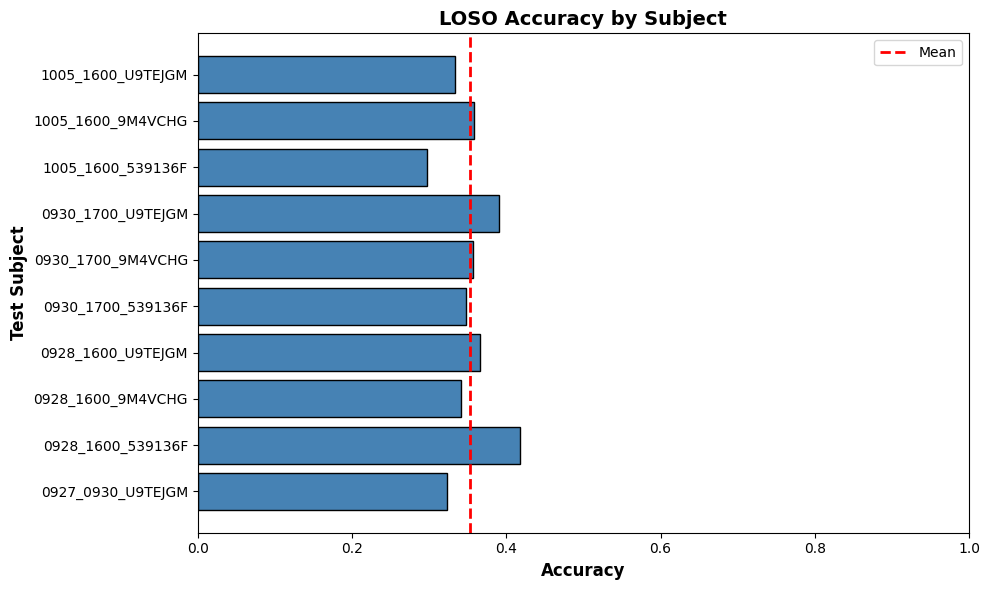

In [43]:
# =============================================================================
# LEAVE-ONE-SUBJECT-OUT (LOSO) CROSS-VALIDATION
# =============================================================================
from sklearn.model_selection import LeaveOneGroupOut

print(f"\n{'='*80}")
print(f"LEAVE-ONE-SUBJECT-OUT (LOSO) CROSS-VALIDATION")
print(f"{'='*80}")

# Prepare data
X_physio = physiology_df.drop(columns=['subject_id', 'trial_id']).values
y = ambiguity
groups = subjects  # Subject IDs for grouping

# Initialize LOSO cross-validator
logo = LeaveOneGroupOut()
n_splits = logo.get_n_splits(X_physio, y, groups)

print(f"\nNumber of subjects: {len(np.unique(groups))}")
print(f"Number of LOSO splits: {n_splits}")

# Store results for each fold
loso_results = []

for fold_idx, (train_idx, test_idx) in enumerate(logo.split(X_physio, y, groups)):
    # Get train and test data
    X_train = X_physio[train_idx]
    X_test = X_physio[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]
    
    # Get the test subject ID
    test_subject = np.unique(groups[test_idx])[0]
    
    print(f"\nFold {fold_idx + 1}/{n_splits} - Test subject: {test_subject}")
    print(f"  Train samples: {len(y_train)} (0: {np.sum(y_train==0)}, 3: {np.sum(y_train==3)}, 6: {np.sum(y_train==6)})")
    print(f"  Test samples: {len(y_test)} (0: {np.sum(y_test==0)}, 3: {np.sum(y_test==3)}, 6: {np.sum(y_test==6)})")
    
    # Train model
    rf = RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        max_depth=5,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced'
    )
    rf.fit(X_train, y_train)
    
    # Predictions
    y_pred = rf.predict(X_test)
    y_prob = rf.predict_proba(X_test)[:, 1]
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"  Accuracy: {accuracy:.3f} | F1: {f1:.3f}")
    
    # Store results
    loso_results.append({
        'fold': fold_idx + 1,
        'test_subject': test_subject,
        'n_train': len(y_train),
        'n_test': len(y_test),
        'accuracy': accuracy,
        'f1_score': f1,
        'y_true': y_test,
        'y_pred': y_pred,
        'y_prob': y_prob
    })

# Summary statistics
loso_df_task2_all = pd.DataFrame(loso_results)
print(f"\n{'='*80}")
print(f"LOSO CROSS-VALIDATION SUMMARY")
print(f"{'='*80}")
print(f"\nMean Accuracy: {loso_df_task2_all['accuracy'].mean():.3f} (+/- {loso_df_task2_all['accuracy'].std():.3f})")
print(f"Mean F1 Score: {loso_df_task2_all['f1_score'].mean():.3f} (+/- {loso_df_task2_all['f1_score'].std():.3f})")
print(f"\nPer-subject results:")
print(loso_df_task2_all[['test_subject', 'n_test', 'accuracy', 'f1_score']].to_string(index=False))

# Visualize LOSO results
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 1: Accuracy by subject
ax.barh(range(len(loso_df_task2_all)), loso_df_task2_all['accuracy'], color='steelblue', edgecolor='black')
ax.axvline(loso_df_task2_all['accuracy'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
ax.set_yticks(range(len(loso_df_task2_all)))
ax.set_yticklabels(loso_df_task2_all['test_subject'])
ax.set_xlabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_ylabel('Test Subject', fontsize=12, fontweight='bold')
ax.set_title('LOSO Accuracy by Subject', fontsize=14, fontweight='bold')
ax.legend()
ax.set_xlim([0, 1])

plt.tight_layout()
plt.show()

### Pre predict post


LEAVE-ONE-SUBJECT-OUT (LOSO) CROSS-VALIDATION

Number of subjects: 10
Number of LOSO splits: 10

Fold 1/10 - Test subject: 0927_0930_U9TEJGM
  Train samples: 945 (0: 316, 3: 310, 6: 319)
  Test samples: 99 (0: 31, 3: 32, 6: 36)
  Accuracy: 0.354 | F1: 0.329

Fold 2/10 - Test subject: 0928_1600_539136F
  Train samples: 934 (0: 308, 3: 305, 6: 321)
  Test samples: 110 (0: 39, 3: 37, 6: 34)
  Accuracy: 0.364 | F1: 0.351

Fold 3/10 - Test subject: 0928_1600_9M4VCHG
  Train samples: 927 (0: 308, 3: 303, 6: 316)
  Test samples: 117 (0: 39, 3: 39, 6: 39)
  Accuracy: 0.265 | F1: 0.238

Fold 4/10 - Test subject: 0928_1600_U9TEJGM
  Train samples: 951 (0: 315, 3: 312, 6: 324)
  Test samples: 93 (0: 32, 3: 30, 6: 31)
  Accuracy: 0.301 | F1: 0.282

Fold 5/10 - Test subject: 0930_1700_539136F
  Train samples: 949 (0: 313, 3: 313, 6: 323)
  Test samples: 95 (0: 34, 3: 29, 6: 32)
  Accuracy: 0.389 | F1: 0.289

Fold 6/10 - Test subject: 0930_1700_9M4VCHG
  Train samples: 932 (0: 311, 3: 305, 6: 316)


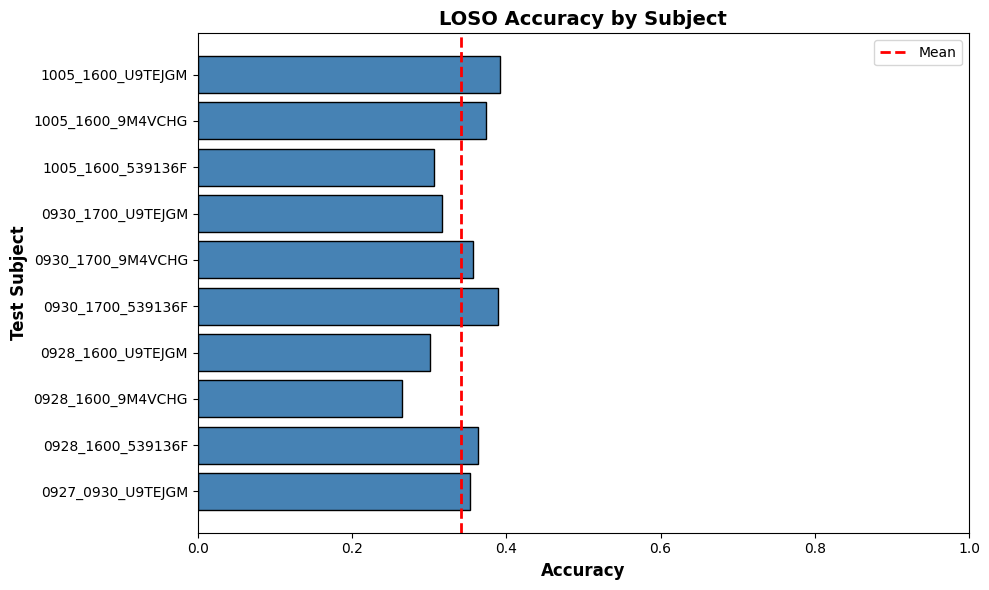

In [44]:
# =============================================================================
# LEAVE-ONE-SUBJECT-OUT (LOSO) CROSS-VALIDATION
# =============================================================================
from sklearn.model_selection import LeaveOneGroupOut

print(f"\n{'='*80}")
print(f"LEAVE-ONE-SUBJECT-OUT (LOSO) CROSS-VALIDATION")
print(f"{'='*80}")

# Prepare data
X_physio = physiology_df.drop(columns=['subject_id', 'trial_id'])[pre_cols].values # select pre-submit features only
y = ambiguity
groups = subjects  # Subject IDs for grouping

# Initialize LOSO cross-validator
logo = LeaveOneGroupOut()
n_splits = logo.get_n_splits(X_physio, y, groups)

print(f"\nNumber of subjects: {len(np.unique(groups))}")
print(f"Number of LOSO splits: {n_splits}")

# Store results for each fold
loso_results = []

for fold_idx, (train_idx, test_idx) in enumerate(logo.split(X_physio, y, groups)):
    # Get train and test data
    X_train = X_physio[train_idx]
    X_test = X_physio[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]
    
    # Get the test subject ID
    test_subject = np.unique(groups[test_idx])[0]
    
    print(f"\nFold {fold_idx + 1}/{n_splits} - Test subject: {test_subject}")
    print(f"  Train samples: {len(y_train)} (0: {np.sum(y_train==0)}, 3: {np.sum(y_train==3)}, 6: {np.sum(y_train==6)})")
    print(f"  Test samples: {len(y_test)} (0: {np.sum(y_test==0)}, 3: {np.sum(y_test==3)}, 6: {np.sum(y_test==6)})")
    
    # Train model
    rf = RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        max_depth=5,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced'
    )
    rf.fit(X_train, y_train)
    
    # Predictions
    y_pred = rf.predict(X_test)
    y_prob = rf.predict_proba(X_test)[:, 1]
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"  Accuracy: {accuracy:.3f} | F1: {f1:.3f}")
    
    # Store results
    loso_results.append({
        'fold': fold_idx + 1,
        'test_subject': test_subject,
        'n_train': len(y_train),
        'n_test': len(y_test),
        'accuracy': accuracy,
        'f1_score': f1,
        'y_true': y_test,
        'y_pred': y_pred,
        'y_prob': y_prob
    })

# Summary statistics
loso_df_task2_pre = pd.DataFrame(loso_results)
print(f"\n{'='*80}")
print(f"LOSO CROSS-VALIDATION SUMMARY")
print(f"{'='*80}")
print(f"\nMean Accuracy: {loso_df_task2_pre['accuracy'].mean():.3f} (+/- {loso_df_task2_pre['accuracy'].std():.3f})")
print(f"Mean F1 Score: {loso_df_task2_pre['f1_score'].mean():.3f} (+/- {loso_df_task2_pre['f1_score'].std():.3f})")
print(f"\nPer-subject results:")
print(loso_df_task2_pre[['test_subject', 'n_test', 'accuracy', 'f1_score']].to_string(index=False))

# Visualize LOSO results
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 1: Accuracy by subject
ax.barh(range(len(loso_df_task2_pre)), loso_df_task2_pre['accuracy'], color='steelblue', edgecolor='black')
ax.axvline(loso_df_task2_pre['accuracy'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
ax.set_yticks(range(len(loso_df_task2_pre)))
ax.set_yticklabels(loso_df_task2_pre['test_subject'])
ax.set_xlabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_ylabel('Test Subject', fontsize=12, fontweight='bold')
ax.set_title('LOSO Accuracy by Subject', fontsize=14, fontweight='bold')
ax.legend()
ax.set_xlim([0, 1])

plt.tight_layout()
plt.show()

### Post predict post


LEAVE-ONE-SUBJECT-OUT (LOSO) CROSS-VALIDATION

Number of subjects: 10
Number of LOSO splits: 10

Fold 1/10 - Test subject: 0927_0930_U9TEJGM
  Train samples: 945 (0: 316, 3: 310, 6: 319)
  Test samples: 99 (0: 31, 3: 32, 6: 36)
  Accuracy: 0.414 | F1: 0.395

Fold 2/10 - Test subject: 0928_1600_539136F
  Train samples: 934 (0: 308, 3: 305, 6: 321)
  Test samples: 110 (0: 39, 3: 37, 6: 34)
  Accuracy: 0.418 | F1: 0.413

Fold 3/10 - Test subject: 0928_1600_9M4VCHG
  Train samples: 927 (0: 308, 3: 303, 6: 316)
  Test samples: 117 (0: 39, 3: 39, 6: 39)
  Accuracy: 0.291 | F1: 0.279

Fold 4/10 - Test subject: 0928_1600_U9TEJGM
  Train samples: 951 (0: 315, 3: 312, 6: 324)
  Test samples: 93 (0: 32, 3: 30, 6: 31)
  Accuracy: 0.355 | F1: 0.349

Fold 5/10 - Test subject: 0930_1700_539136F
  Train samples: 949 (0: 313, 3: 313, 6: 323)
  Test samples: 95 (0: 34, 3: 29, 6: 32)
  Accuracy: 0.347 | F1: 0.330

Fold 6/10 - Test subject: 0930_1700_9M4VCHG
  Train samples: 932 (0: 311, 3: 305, 6: 316)


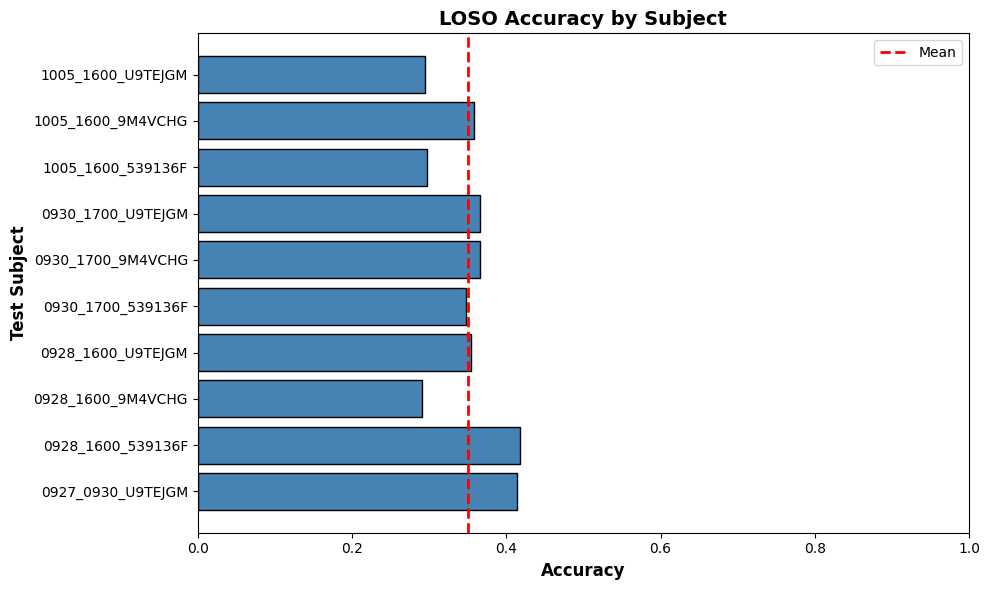

In [45]:
# =============================================================================
# LEAVE-ONE-SUBJECT-OUT (LOSO) CROSS-VALIDATION
# =============================================================================
from sklearn.model_selection import LeaveOneGroupOut

print(f"\n{'='*80}")
print(f"LEAVE-ONE-SUBJECT-OUT (LOSO) CROSS-VALIDATION")
print(f"{'='*80}")

# Prepare data
X_physio = physiology_df.drop(columns=['subject_id', 'trial_id'])[post_cols].values # select post-submit features only
y = ambiguity
groups = subjects  # Subject IDs for grouping

# Initialize LOSO cross-validator
logo = LeaveOneGroupOut()
n_splits = logo.get_n_splits(X_physio, y, groups)

print(f"\nNumber of subjects: {len(np.unique(groups))}")
print(f"Number of LOSO splits: {n_splits}")

# Store results for each fold
loso_results = []

for fold_idx, (train_idx, test_idx) in enumerate(logo.split(X_physio, y, groups)):
    # Get train and test data
    X_train = X_physio[train_idx]
    X_test = X_physio[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]
    
    # Get the test subject ID
    test_subject = np.unique(groups[test_idx])[0]
    
    print(f"\nFold {fold_idx + 1}/{n_splits} - Test subject: {test_subject}")
    print(f"  Train samples: {len(y_train)} (0: {np.sum(y_train==0)}, 3: {np.sum(y_train==3)}, 6: {np.sum(y_train==6)})")
    print(f"  Test samples: {len(y_test)} (0: {np.sum(y_test==0)}, 3: {np.sum(y_test==3)}, 6: {np.sum(y_test==6)})")
    
    # Train model
    rf = RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        max_depth=5,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced'
    )
    rf.fit(X_train, y_train)
    
    # Predictions
    y_pred = rf.predict(X_test)
    y_prob = rf.predict_proba(X_test)[:, 1]
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"  Accuracy: {accuracy:.3f} | F1: {f1:.3f}")
    
    # Store results
    loso_results.append({
        'fold': fold_idx + 1,
        'test_subject': test_subject,
        'n_train': len(y_train),
        'n_test': len(y_test),
        'accuracy': accuracy,
        'f1_score': f1,
        'y_true': y_test,
        'y_pred': y_pred,
        'y_prob': y_prob
    })

# Summary statistics
loso_df_task2_post = pd.DataFrame(loso_results)
print(f"\n{'='*80}")
print(f"LOSO CROSS-VALIDATION SUMMARY")
print(f"{'='*80}")
print(f"\nMean Accuracy: {loso_df_task2_post['accuracy'].mean():.3f} (+/- {loso_df_task2_post['accuracy'].std():.3f})")
print(f"Mean F1 Score: {loso_df_task2_post['f1_score'].mean():.3f} (+/- {loso_df_task2_post['f1_score'].std():.3f})")
print(f"\nPer-subject results:")
print(loso_df_task2_post[['test_subject', 'n_test', 'accuracy', 'f1_score']].to_string(index=False))

# Visualize LOSO results
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 1: Accuracy by subject
ax.barh(range(len(loso_df_task2_post)), loso_df_task2_post['accuracy'], color='steelblue', edgecolor='black')
ax.axvline(loso_df_task2_post['accuracy'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
ax.set_yticks(range(len(loso_df_task2_post)))
ax.set_yticklabels(loso_df_task2_post['test_subject'])
ax.set_xlabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_ylabel('Test Subject', fontsize=12, fontweight='bold')
ax.set_title('LOSO Accuracy by Subject', fontsize=14, fontweight='bold')
ax.legend()
ax.set_xlim([0, 1])

plt.tight_layout()
plt.show()

## Stratified Split

### Baseline


STRATIFIED SPLIT BY SUBJECT

Splitting with test_size=0.3
Number of subjects: 10
  0927_0930_U9TEJGM: 69 train, 30 test
  0928_1600_539136F: 77 train, 33 test
  0928_1600_9M4VCHG: 81 train, 36 test
  0928_1600_U9TEJGM: 65 train, 28 test
  0930_1700_539136F: 66 train, 29 test
  0930_1700_9M4VCHG: 78 train, 34 test
  0930_1700_U9TEJGM: 86 train, 37 test
  1005_1600_539136F: 84 train, 37 test
  1005_1600_9M4VCHG: 86 train, 37 test
  1005_1600_U9TEJGM: 35 train, 16 test

STRATIFIED SPLIT SUMMARY

Total training samples: 727 (Low: 242, High: 0)
Total test samples: 317 (Low: 105, High: 0)

Subject distribution in train set:
0927_0930_U9TEJGM    69
0928_1600_539136F    77
0928_1600_9M4VCHG    81
0928_1600_U9TEJGM    65
0930_1700_539136F    66
0930_1700_9M4VCHG    78
0930_1700_U9TEJGM    86
1005_1600_539136F    84
1005_1600_9M4VCHG    86
1005_1600_U9TEJGM    35
Name: count, dtype: int64

Subject distribution in test set:
0927_0930_U9TEJGM    30
0928_1600_539136F    33
0928_1600_9M4VCHG    36


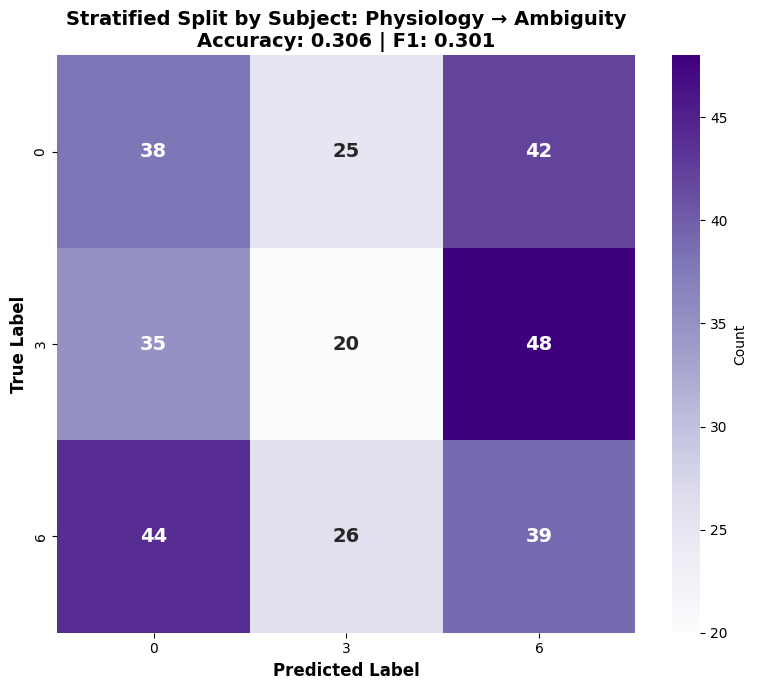


Top 10 Most Important Features (Stratified Split):
                             feature  importance
29                        baseline_R    0.052122
24                eye_asymmetry_post    0.050841
26     pupil_mean_change_pre_to_post    0.049560
4                   pupil_change_pre    0.043507
18                     pupil_cv_post    0.041217
14                   pupil_mean_post    0.041103
1                      pupil_std_pre    0.040933
30                      baseline_avg    0.038303
28                        baseline_L    0.036745
21  pupil_max_constriction_rate_post    0.035804


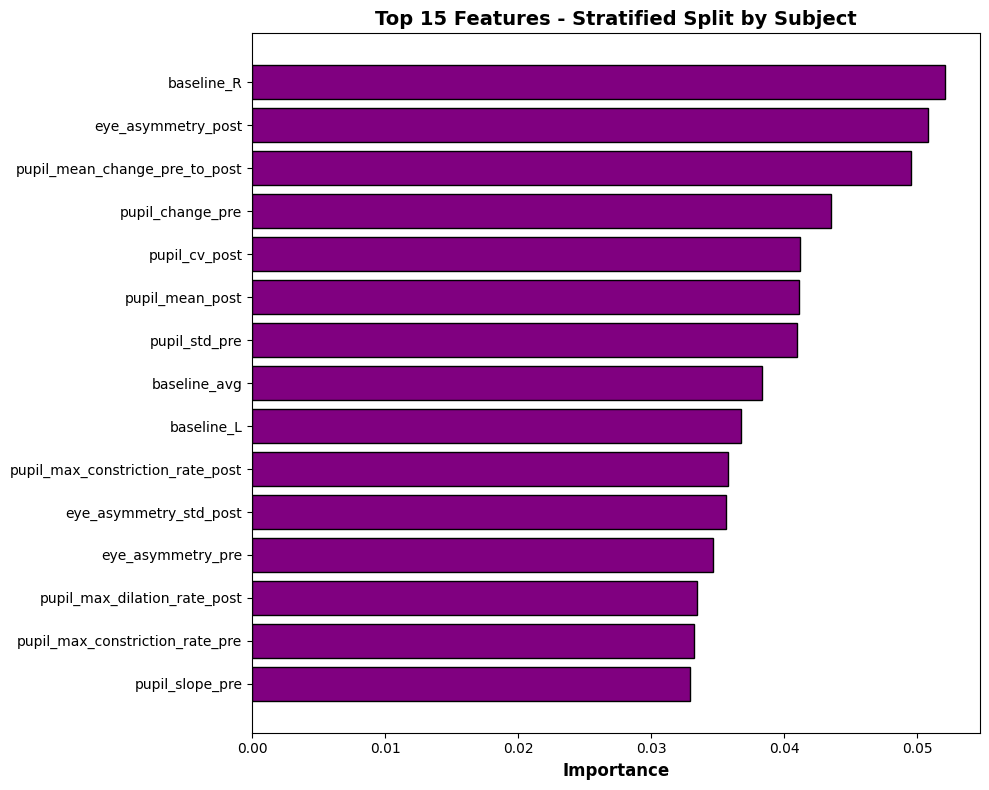

In [46]:
# =============================================================================
# STRATIFIED SPLIT BY SUBJECT (Equal % from each subject)
# =============================================================================

print(f"\n{'='*80}")
print(f"STRATIFIED SPLIT BY SUBJECT")
print(f"{'='*80}")

def stratified_split_by_subject(physiology_df, ambiguity, subjects, test_size=0.3, random_state=42):
    """
    Split data ensuring equal percentage from each subject in train/test sets.
    
    Parameters:
    -----------
    physiology_df : DataFrame
        Physiology features (including subject_id and trial_id columns)
    ambiguity : array
        Target labels
    subjects : array
        Subject IDs for each trial
    test_size : float
        Proportion of data to include in test split (default 0.3)
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    X_train, X_test, y_train, y_test, train_subjects, test_subjects
    """
    
    np.random.seed(random_state)
    
    train_indices = []
    test_indices = []
    
    # Get unique subjects
    unique_subjects = np.unique(subjects)
    
    print(f"\nSplitting with test_size={test_size}")
    print(f"Number of subjects: {len(unique_subjects)}")
    
    # For each subject, split their trials
    for subject in unique_subjects:
        # Get all trial indices for this subject
        subject_mask = subjects == subject
        subject_indices = np.where(subject_mask)[0]
        subject_ambiguity = ambiguity[subject_mask]
        
        # Stratified split for this subject to maintain class balance
        try:
            subject_train_idx, subject_test_idx = train_test_split(
                subject_indices,
                test_size=test_size,
                random_state=random_state,
                stratify=subject_ambiguity
            )
        except ValueError:
            # If stratification fails (e.g., too few samples), do random split
            print(f"  Warning: Stratification failed for {subject}, using random split")
            subject_train_idx, subject_test_idx = train_test_split(
                subject_indices,
                test_size=test_size,
                random_state=random_state
            )
        
        train_indices.extend(subject_train_idx)
        test_indices.extend(subject_test_idx)
        
        print(f"  {subject}: {len(subject_train_idx)} train, {len(subject_test_idx)} test")
    
    # Convert to numpy arrays
    train_indices = np.array(train_indices)
    test_indices = np.array(test_indices)
    
    # Extract features and labels
    X_train = physiology_df.drop(columns=['subject_id', 'trial_id']).iloc[train_indices].values
    X_test = physiology_df.drop(columns=['subject_id', 'trial_id']).iloc[test_indices].values
    y_train = ambiguity[train_indices]
    y_test = ambiguity[test_indices]
    train_subjects = subjects[train_indices]
    test_subjects = subjects[test_indices]
    
    return X_train, X_test, y_train, y_test, train_subjects, test_subjects


# Perform stratified split
X_train_strat, X_test_strat, y_train_strat, y_test_strat, train_subjects, test_subjects = \
    stratified_split_by_subject(physiology_df, ambiguity, subjects, test_size=0.3, random_state=42)

print(f"\n{'='*80}")
print(f"STRATIFIED SPLIT SUMMARY")
print(f"{'='*80}")
print(f"\nTotal training samples: {len(y_train_strat)} (Low: {np.sum(y_train_strat==0)}, High: {np.sum(y_train_strat==1)})")
print(f"Total test samples: {len(y_test_strat)} (Low: {np.sum(y_test_strat==0)}, High: {np.sum(y_test_strat==1)})")

# Check subject distribution in train and test
print(f"\nSubject distribution in train set:")
train_subject_counts = pd.Series(train_subjects).value_counts().sort_index()
print(train_subject_counts)

print(f"\nSubject distribution in test set:")
test_subject_counts = pd.Series(test_subjects).value_counts().sort_index()
print(test_subject_counts)

# Verify equal percentages
print(f"\nPercentage of each subject's data in test set:")
for subject in np.unique(subjects):
    total = np.sum(subjects == subject)
    test_count = np.sum(test_subjects == subject)
    pct = test_count / total
    print(f"  {subject}: {test_count}/{total} = {pct:.1%}")

# Train model
rf_strat = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced'
)
rf_strat.fit(X_train_strat, y_train_strat)

# Predictions
y_pred_strat = rf_strat.predict(X_test_strat)
y_prob_strat = rf_strat.predict_proba(X_test_strat)[:, 1]

# Evaluation
accuracy_strat_task2_all = accuracy_score(y_test_strat, y_pred_strat)
f1_strat_task2_all = f1_score(y_test_strat, y_pred_strat, average='weighted')

print(f"\n{'='*80}")
print(f"STRATIFIED SPLIT RESULTS")
print(f"{'='*80}")
print(f"\nAccuracy: {accuracy_strat_task2_all:.3f}")
print(f"F1 Score: {f1_strat_task2_all:.3f}")
print("\nClassification Report:")
print(classification_report(y_test_strat, y_pred_strat, target_names=['No Ambiguity (0)', 'Medium Ambiguity (3)', 'High Ambiguity (6)']))

# Confusion matrix
cm_strat = confusion_matrix(y_test_strat, y_pred_strat)
fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(cm_strat, annot=True, fmt='d', cmap='Purples', ax=ax, cbar_kws={'label': 'Count'},
            xticklabels=['0', '3', '6'],
            yticklabels=['0', '3', '6'], 
            annot_kws={'size': 14, 'weight': 'bold'})
ax.set_title(f'Stratified Split by Subject: Physiology → Ambiguity\nAccuracy: {accuracy_strat_task2_all:.3f} | F1: {f1_strat_task2_all:.3f}', 
             fontsize=14, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Feature importance
feature_importance_strat = pd.DataFrame({
    'feature': physiology_df.drop(columns=['subject_id', 'trial_id']).columns,
    'importance': rf_strat.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features (Stratified Split):")
print(feature_importance_strat.head(10))

# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 8))
top_n = min(15, len(feature_importance_strat))
ax.barh(range(top_n), feature_importance_strat['importance'][:top_n], color='purple', edgecolor='black')
ax.set_yticks(range(top_n))
ax.set_yticklabels(feature_importance_strat['feature'][:top_n])
ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax.set_title(f'Top {top_n} Features - Stratified Split by Subject', 
             fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

### Pre predict post


STRATIFIED SPLIT BY SUBJECT

Splitting with test_size=0.3
Number of subjects: 10
  0927_0930_U9TEJGM: 69 train, 30 test
  0928_1600_539136F: 77 train, 33 test
  0928_1600_9M4VCHG: 81 train, 36 test
  0928_1600_U9TEJGM: 65 train, 28 test
  0930_1700_539136F: 66 train, 29 test
  0930_1700_9M4VCHG: 78 train, 34 test
  0930_1700_U9TEJGM: 86 train, 37 test
  1005_1600_539136F: 84 train, 37 test
  1005_1600_9M4VCHG: 86 train, 37 test
  1005_1600_U9TEJGM: 35 train, 16 test

STRATIFIED SPLIT SUMMARY

Total training samples: 727 (Low: 242, High: 0)
Total test samples: 317 (Low: 105, High: 0)

Subject distribution in train set:
0927_0930_U9TEJGM    69
0928_1600_539136F    77
0928_1600_9M4VCHG    81
0928_1600_U9TEJGM    65
0930_1700_539136F    66
0930_1700_9M4VCHG    78
0930_1700_U9TEJGM    86
1005_1600_539136F    84
1005_1600_9M4VCHG    86
1005_1600_U9TEJGM    35
Name: count, dtype: int64

Subject distribution in test set:
0927_0930_U9TEJGM    30
0928_1600_539136F    33
0928_1600_9M4VCHG    36


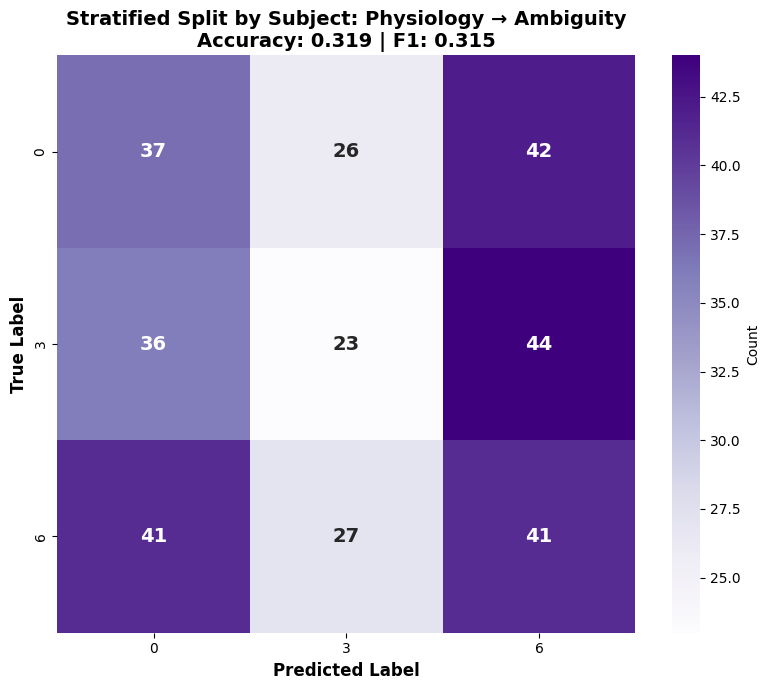


Top 10 Most Important Features (Stratified Split):
                            feature  importance
17                       baseline_R    0.084452
14    pupil_mean_change_pre_to_post    0.074536
2                   pupil_slope_pre    0.068760
4                  pupil_change_pre    0.062969
18                     baseline_avg    0.058163
8   pupil_max_constriction_rate_pre    0.055405
12                eye_asymmetry_pre    0.052277
5                      pupil_cv_pre    0.051865
10            pct_time_dilating_pre    0.051862
0                    pupil_mean_pre    0.051061


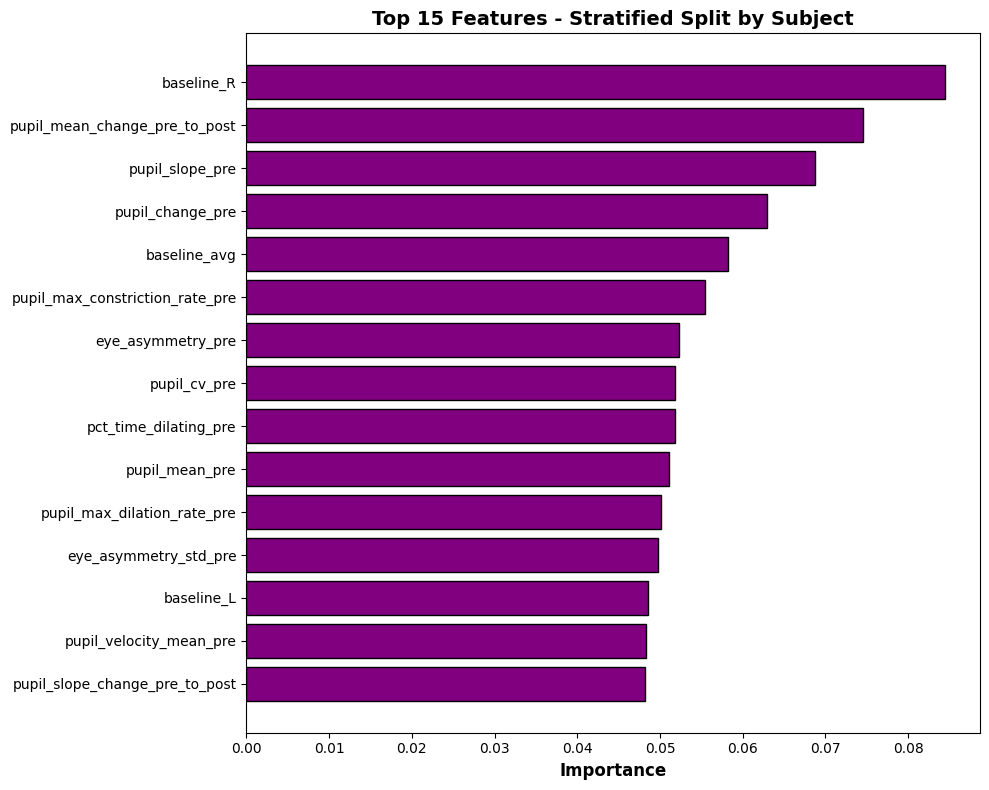

In [47]:
# =============================================================================
# STRATIFIED SPLIT BY SUBJECT (Equal % from each subject)
# =============================================================================

print(f"\n{'='*80}")
print(f"STRATIFIED SPLIT BY SUBJECT")
print(f"{'='*80}")

def stratified_split_by_subject(physiology_df, ambiguity, subjects, test_size=0.3, random_state=42):
    """
    Split data ensuring equal percentage from each subject in train/test sets.
    
    Parameters:
    -----------
    physiology_df : DataFrame
        Physiology features (including subject_id and trial_id columns)
    ambiguity : array
        Target labels
    subjects : array
        Subject IDs for each trial
    test_size : float
        Proportion of data to include in test split (default 0.3)
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    X_train, X_test, y_train, y_test, train_subjects, test_subjects
    """
    
    np.random.seed(random_state)
    
    train_indices = []
    test_indices = []
    
    # Get unique subjects
    unique_subjects = np.unique(subjects)
    
    print(f"\nSplitting with test_size={test_size}")
    print(f"Number of subjects: {len(unique_subjects)}")
    
    # For each subject, split their trials
    for subject in unique_subjects:
        # Get all trial indices for this subject
        subject_mask = subjects == subject
        subject_indices = np.where(subject_mask)[0]
        subject_ambiguity = ambiguity[subject_mask]
        
        # Stratified split for this subject to maintain class balance
        try:
            subject_train_idx, subject_test_idx = train_test_split(
                subject_indices,
                test_size=test_size,
                random_state=random_state,
                stratify=subject_ambiguity
            )
        except ValueError:
            # If stratification fails (e.g., too few samples), do random split
            print(f"  Warning: Stratification failed for {subject}, using random split")
            subject_train_idx, subject_test_idx = train_test_split(
                subject_indices,
                test_size=test_size,
                random_state=random_state
            )
        
        train_indices.extend(subject_train_idx)
        test_indices.extend(subject_test_idx)
        
        print(f"  {subject}: {len(subject_train_idx)} train, {len(subject_test_idx)} test")
    
    # Convert to numpy arrays
    train_indices = np.array(train_indices)
    test_indices = np.array(test_indices)
    
    # Extract features and labels
    X_train = physiology_df.drop(columns=['subject_id', 'trial_id']).iloc[train_indices].values
    X_test = physiology_df.drop(columns=['subject_id', 'trial_id']).iloc[test_indices].values
    y_train = ambiguity[train_indices]
    y_test = ambiguity[test_indices]
    train_subjects = subjects[train_indices]
    test_subjects = subjects[test_indices]
    
    return X_train, X_test, y_train, y_test, train_subjects, test_subjects


# Perform stratified split
X_train_strat, X_test_strat, y_train_strat, y_test_strat, train_subjects, test_subjects = \
    stratified_split_by_subject(physiology_df_pre, ambiguity, subjects, test_size=0.3, random_state=42) # use pre-submit features

print(f"\n{'='*80}")
print(f"STRATIFIED SPLIT SUMMARY")
print(f"{'='*80}")
print(f"\nTotal training samples: {len(y_train_strat)} (Low: {np.sum(y_train_strat==0)}, High: {np.sum(y_train_strat==1)})")
print(f"Total test samples: {len(y_test_strat)} (Low: {np.sum(y_test_strat==0)}, High: {np.sum(y_test_strat==1)})")

# Check subject distribution in train and test
print(f"\nSubject distribution in train set:")
train_subject_counts = pd.Series(train_subjects).value_counts().sort_index()
print(train_subject_counts)

print(f"\nSubject distribution in test set:")
test_subject_counts = pd.Series(test_subjects).value_counts().sort_index()
print(test_subject_counts)

# Verify equal percentages
print(f"\nPercentage of each subject's data in test set:")
for subject in np.unique(subjects):
    total = np.sum(subjects == subject)
    test_count = np.sum(test_subjects == subject)
    pct = test_count / total
    print(f"  {subject}: {test_count}/{total} = {pct:.1%}")

# Train model
rf_strat = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced'
)
rf_strat.fit(X_train_strat, y_train_strat)

# Predictions
y_pred_strat = rf_strat.predict(X_test_strat)
y_prob_strat = rf_strat.predict_proba(X_test_strat)[:, 1]

# Evaluation
accuracy_strat_task2_pre = accuracy_score(y_test_strat, y_pred_strat)
f1_strat_task2_pre = f1_score(y_test_strat, y_pred_strat, average='weighted')

print(f"\n{'='*80}")
print(f"STRATIFIED SPLIT RESULTS")
print(f"{'='*80}")
print(f"\nAccuracy: {accuracy_strat_task2_pre:.3f}")
print(f"F1 Score: {f1_strat_task2_pre:.3f}")
print("\nClassification Report:")
print(classification_report(y_test_strat, y_pred_strat, target_names=['No Ambiguity (0)', 'Medium Ambiguity (3)', 'High Ambiguity (6)']))

# Confusion matrix
cm_strat = confusion_matrix(y_test_strat, y_pred_strat)
fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(cm_strat, annot=True, fmt='d', cmap='Purples', ax=ax, cbar_kws={'label': 'Count'},
            xticklabels=['0', '3', '6'],
            yticklabels=['0', '3', '6'], 
            annot_kws={'size': 14, 'weight': 'bold'})
ax.set_title(f'Stratified Split by Subject: Physiology → Ambiguity\nAccuracy: {accuracy_strat_task2_pre:.3f} | F1: {f1_strat_task2_pre
:.3f}', 
             fontsize=14, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Feature importance
feature_importance_strat = pd.DataFrame({
    'feature': physiology_df_pre.drop(columns=['subject_id', 'trial_id']).columns,
    'importance': rf_strat.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features (Stratified Split):")
print(feature_importance_strat.head(10))

# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 8))
top_n = min(15, len(feature_importance_strat))
ax.barh(range(top_n), feature_importance_strat['importance'][:top_n], color='purple', edgecolor='black')
ax.set_yticks(range(top_n))
ax.set_yticklabels(feature_importance_strat['feature'][:top_n])
ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax.set_title(f'Top {top_n} Features - Stratified Split by Subject', 
             fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

### Post predict post


STRATIFIED SPLIT BY SUBJECT

Splitting with test_size=0.3
Number of subjects: 10
  0927_0930_U9TEJGM: 69 train, 30 test
  0928_1600_539136F: 77 train, 33 test
  0928_1600_9M4VCHG: 81 train, 36 test
  0928_1600_U9TEJGM: 65 train, 28 test
  0930_1700_539136F: 66 train, 29 test
  0930_1700_9M4VCHG: 78 train, 34 test
  0930_1700_U9TEJGM: 86 train, 37 test
  1005_1600_539136F: 84 train, 37 test
  1005_1600_9M4VCHG: 86 train, 37 test
  1005_1600_U9TEJGM: 35 train, 16 test

STRATIFIED SPLIT SUMMARY

Total training samples: 727 (Low: 242, High: 0)
Total test samples: 317 (Low: 105, High: 0)

Subject distribution in train set:
0927_0930_U9TEJGM    69
0928_1600_539136F    77
0928_1600_9M4VCHG    81
0928_1600_U9TEJGM    65
0930_1700_539136F    66
0930_1700_9M4VCHG    78
0930_1700_U9TEJGM    86
1005_1600_539136F    84
1005_1600_9M4VCHG    86
1005_1600_U9TEJGM    35
Name: count, dtype: int64

Subject distribution in test set:
0927_0930_U9TEJGM    30
0928_1600_539136F    33
0928_1600_9M4VCHG    36


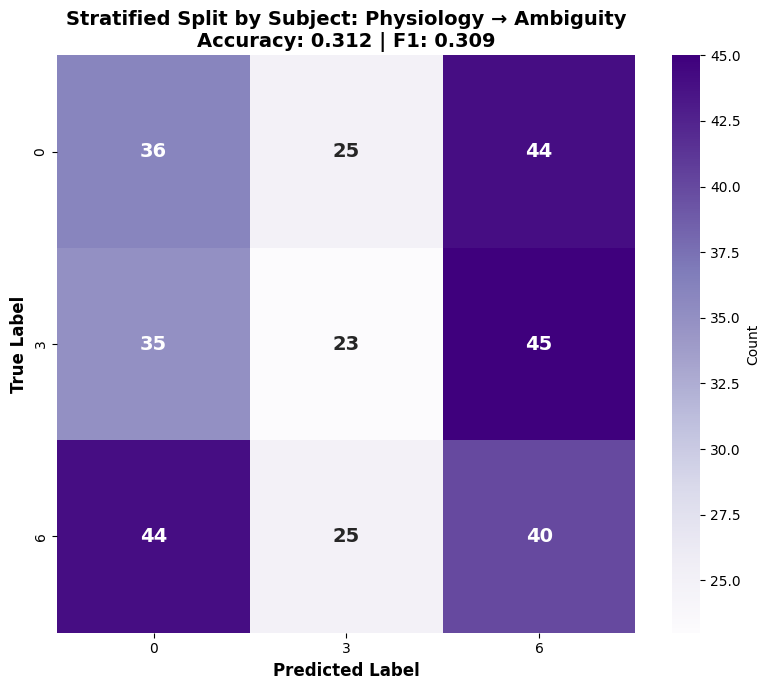


Top 10 Most Important Features (Stratified Split):
                          feature  importance
10             eye_asymmetry_post    0.088265
12  pupil_mean_change_pre_to_post    0.085969
11         eye_asymmetry_std_post    0.078280
16                   baseline_avg    0.075847
6    pupil_max_dilation_rate_post    0.072988
15                     baseline_R    0.070738
14                     baseline_L    0.057986
3               time_to_peak_post    0.057489
4                   pupil_cv_post    0.056549
5        pupil_velocity_mean_post    0.054364


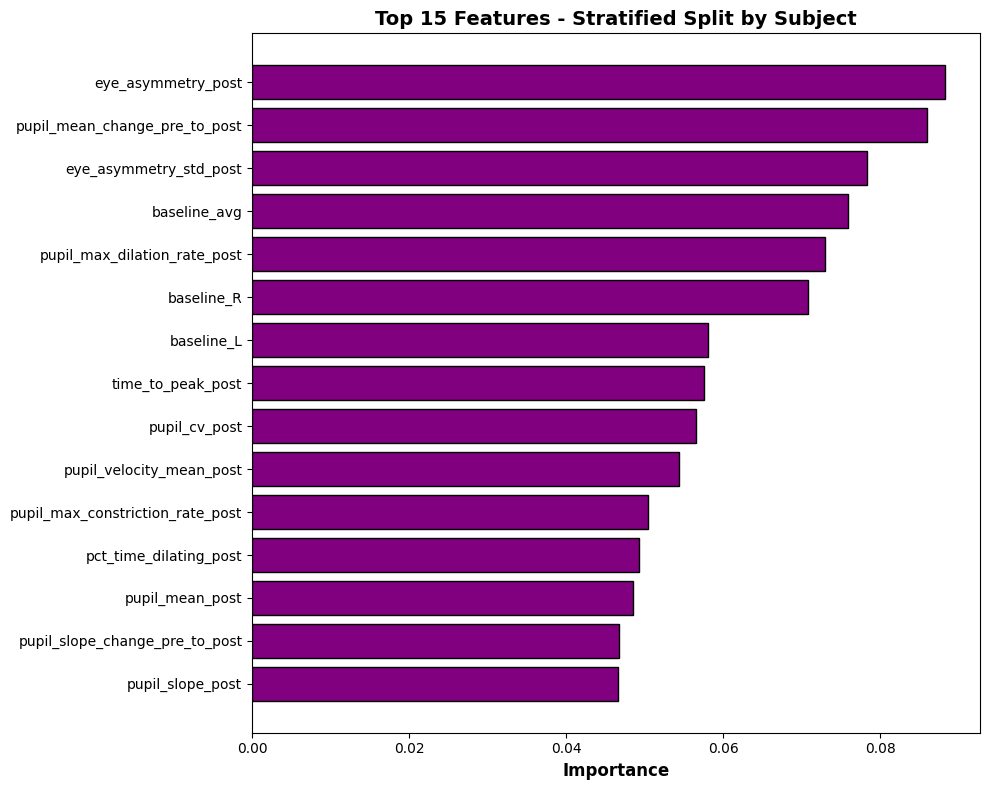

In [48]:
# =============================================================================
# STRATIFIED SPLIT BY SUBJECT (Equal % from each subject)
# =============================================================================

print(f"\n{'='*80}")
print(f"STRATIFIED SPLIT BY SUBJECT")
print(f"{'='*80}")

def stratified_split_by_subject(physiology_df, ambiguity, subjects, test_size=0.3, random_state=42):
    """
    Split data ensuring equal percentage from each subject in train/test sets.
    
    Parameters:
    -----------
    physiology_df : DataFrame
        Physiology features (including subject_id and trial_id columns)
    ambiguity : array
        Target labels
    subjects : array
        Subject IDs for each trial
    test_size : float
        Proportion of data to include in test split (default 0.3)
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    X_train, X_test, y_train, y_test, train_subjects, test_subjects
    """
    
    np.random.seed(random_state)
    
    train_indices = []
    test_indices = []
    
    # Get unique subjects
    unique_subjects = np.unique(subjects)
    
    print(f"\nSplitting with test_size={test_size}")
    print(f"Number of subjects: {len(unique_subjects)}")
    
    # For each subject, split their trials
    for subject in unique_subjects:
        # Get all trial indices for this subject
        subject_mask = subjects == subject
        subject_indices = np.where(subject_mask)[0]
        subject_ambiguity = ambiguity[subject_mask]
        
        # Stratified split for this subject to maintain class balance
        try:
            subject_train_idx, subject_test_idx = train_test_split(
                subject_indices,
                test_size=test_size,
                random_state=random_state,
                stratify=subject_ambiguity
            )
        except ValueError:
            # If stratification fails (e.g., too few samples), do random split
            print(f"  Warning: Stratification failed for {subject}, using random split")
            subject_train_idx, subject_test_idx = train_test_split(
                subject_indices,
                test_size=test_size,
                random_state=random_state
            )
        
        train_indices.extend(subject_train_idx)
        test_indices.extend(subject_test_idx)
        
        print(f"  {subject}: {len(subject_train_idx)} train, {len(subject_test_idx)} test")
    
    # Convert to numpy arrays
    train_indices = np.array(train_indices)
    test_indices = np.array(test_indices)
    
    # Extract features and labels
    X_train = physiology_df.drop(columns=['subject_id', 'trial_id']).iloc[train_indices].values
    X_test = physiology_df.drop(columns=['subject_id', 'trial_id']).iloc[test_indices].values
    y_train = ambiguity[train_indices]
    y_test = ambiguity[test_indices]
    train_subjects = subjects[train_indices]
    test_subjects = subjects[test_indices]
    
    return X_train, X_test, y_train, y_test, train_subjects, test_subjects


# Perform stratified split
X_train_strat, X_test_strat, y_train_strat, y_test_strat, train_subjects, test_subjects = \
    stratified_split_by_subject(physiology_df_post, ambiguity, subjects, test_size=0.3, random_state=42) # use pre-submit features

print(f"\n{'='*80}")
print(f"STRATIFIED SPLIT SUMMARY")
print(f"{'='*80}")
print(f"\nTotal training samples: {len(y_train_strat)} (Low: {np.sum(y_train_strat==0)}, High: {np.sum(y_train_strat==1)})")
print(f"Total test samples: {len(y_test_strat)} (Low: {np.sum(y_test_strat==0)}, High: {np.sum(y_test_strat==1)})")

# Check subject distribution in train and test
print(f"\nSubject distribution in train set:")
train_subject_counts = pd.Series(train_subjects).value_counts().sort_index()
print(train_subject_counts)

print(f"\nSubject distribution in test set:")
test_subject_counts = pd.Series(test_subjects).value_counts().sort_index()
print(test_subject_counts)

# Verify equal percentages
print(f"\nPercentage of each subject's data in test set:")
for subject in np.unique(subjects):
    total = np.sum(subjects == subject)
    test_count = np.sum(test_subjects == subject)
    pct = test_count / total
    print(f"  {subject}: {test_count}/{total} = {pct:.1%}")

# Train model
rf_strat = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced'
)
rf_strat.fit(X_train_strat, y_train_strat)

# Predictions
y_pred_strat = rf_strat.predict(X_test_strat)
y_prob_strat = rf_strat.predict_proba(X_test_strat)[:, 1]

# Evaluation
accuracy_strat_task2_post = accuracy_score(y_test_strat, y_pred_strat)
f1_strat_task2_post = f1_score(y_test_strat, y_pred_strat, average='weighted')

print(f"\n{'='*80}")
print(f"STRATIFIED SPLIT RESULTS")
print(f"{'='*80}")
print(f"\nAccuracy: {accuracy_strat_task2_post:.3f}")
print(f"F1 Score: {f1_strat_task2_post:.3f}")
print("\nClassification Report:")
print(classification_report(y_test_strat, y_pred_strat, target_names=['No Ambiguity (0)', 'Medium Ambiguity (3)', 'High Ambiguity (6)']))

# Confusion matrix
cm_strat = confusion_matrix(y_test_strat, y_pred_strat)
fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(cm_strat, annot=True, fmt='d', cmap='Purples', ax=ax, cbar_kws={'label': 'Count'},
            xticklabels=['0', '3', '6'],
            yticklabels=['0', '3', '6'], 
            annot_kws={'size': 14, 'weight': 'bold'})
ax.set_title(f'Stratified Split by Subject: Physiology → Ambiguity\nAccuracy: {accuracy_strat_task2_post:.3f} | F1: {f1_strat_task2_post:.3f}', 
             fontsize=14, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Feature importance
feature_importance_strat = pd.DataFrame({
    'feature': physiology_df_post.drop(columns=['subject_id', 'trial_id']).columns,
    'importance': rf_strat.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features (Stratified Split):")
print(feature_importance_strat.head(10))

# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 8))
top_n = min(15, len(feature_importance_strat))
ax.barh(range(top_n), feature_importance_strat['importance'][:top_n], color='purple', edgecolor='black')
ax.set_yticks(range(top_n))
ax.set_yticklabels(feature_importance_strat['feature'][:top_n])
ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax.set_title(f'Top {top_n} Features - Stratified Split by Subject', 
             fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## Comparison


TASK 2: PHYSIOLOGY → AMBIGUITY - ALL METHODS COMPARISON


TASK 2 RESULTS:
          Method       Features  Accuracy  F1_Score
    Random Split All (Baseline)  0.340764  0.341206
    Random Split       Pre Only  0.296178  0.294234
    Random Split      Post Only  0.347134  0.344578
            LOSO All (Baseline)  0.353222  0.330872
            LOSO       Pre Only  0.341882  0.310124
            LOSO      Post Only  0.350642  0.335372
Stratified Split All (Baseline)  0.305994  0.300779
Stratified Split       Pre Only  0.318612  0.314895
Stratified Split      Post Only  0.312303  0.308905


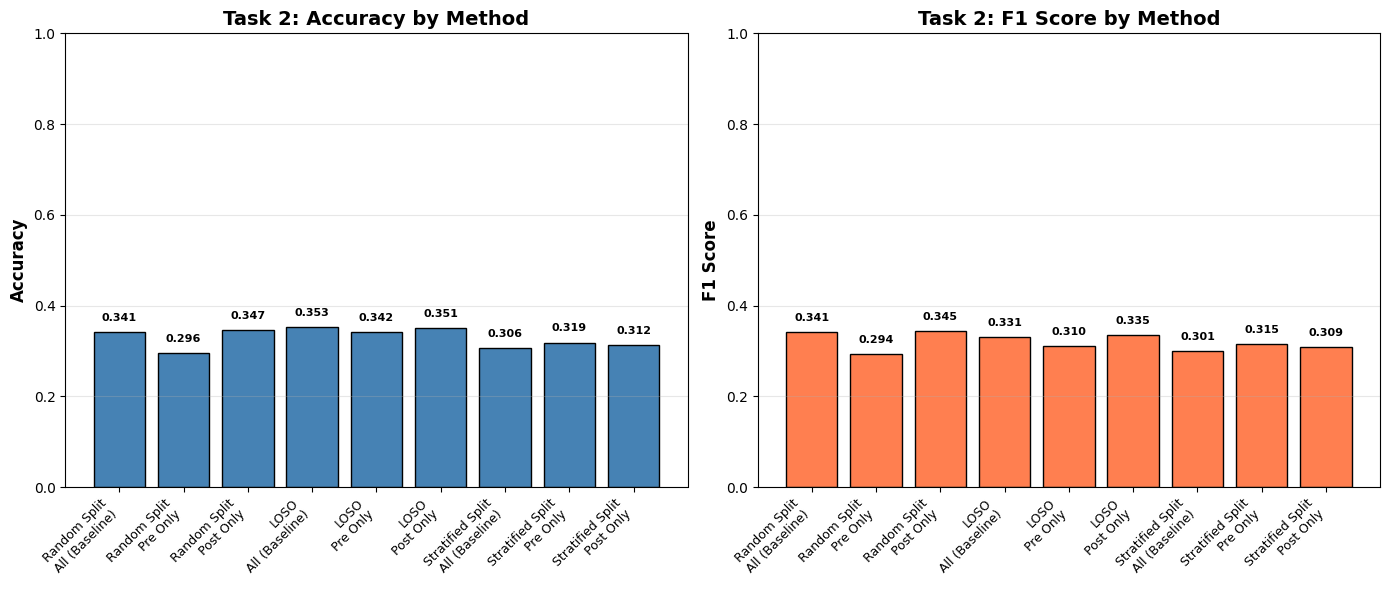


KEY FINDINGS:
Best performing: LOSO with All (Baseline) - Accuracy: 0.353


In [49]:
# =============================================================================
# TASK 2 RESULTS SUMMARY - ALL METHODS COMPARISON
# =============================================================================

print(f"\n{'='*80}")
print(f"TASK 2: PHYSIOLOGY → AMBIGUITY - ALL METHODS COMPARISON")
print(f"{'='*80}\n")

# Collect all Task 2 results from stored variables
task2_results = []

# Random Split - All features (baseline)
task2_results.append({'Method': 'Random Split', 'Features': 'All (Baseline)', 'Accuracy': accuracy_physio_all, 'F1_Score': f1_physio_all})

# Random Split - Pre features
task2_results.append({'Method': 'Random Split', 'Features': 'Pre Only', 'Accuracy': accuracy_physio_pre, 'F1_Score': f1_physio_pre})

# Random Split - Post features
task2_results.append({'Method': 'Random Split', 'Features': 'Post Only', 'Accuracy': accuracy_physio_post, 'F1_Score': f1_physio_post})

# LOSO - All features (if exists)
try:
    task2_results.append({'Method': 'LOSO', 'Features': 'All (Baseline)', 'Accuracy': loso_df_task2_all['accuracy'].mean(), 'F1_Score': loso_df_task2_all['f1_score'].mean()})
except:
    pass

# LOSO - Pre features (if exists)
try:
    task2_results.append({'Method': 'LOSO', 'Features': 'Pre Only', 'Accuracy': loso_df_task2_pre['accuracy'].mean(), 'F1_Score': loso_df_task2_pre['f1_score'].mean()})
except:
    pass

# LOSO - Post features (if exists)
try:
    task2_results.append({'Method': 'LOSO', 'Features': 'Post Only', 'Accuracy': loso_df_task2_post['accuracy'].mean(), 'F1_Score': loso_df_task2_post['f1_score'].mean()})
except:
    pass

# Stratified - All features (if exists)
try:
    task2_results.append({'Method': 'Stratified Split', 'Features': 'All (Baseline)', 'Accuracy': accuracy_strat_task2_all, 'F1_Score': f1_strat_task2_all})
except:
    pass

# Stratified - Pre features (if exists)
try:
    task2_results.append({'Method': 'Stratified Split', 'Features': 'Pre Only', 'Accuracy': accuracy_strat_task2_pre, 'F1_Score': f1_strat_task2_pre})
except:
    pass

# Stratified - Post features (if exists)
try:
    task2_results.append({'Method': 'Stratified Split', 'Features': 'Post Only', 'Accuracy': accuracy_strat_task2_post, 'F1_Score': f1_strat_task2_post})
except:
    pass

# Create DataFrame
task2_df = pd.DataFrame(task2_results)

print("\nTASK 2 RESULTS:")
print(task2_df.to_string(index=False))

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy comparison
x_pos = np.arange(len(task2_df))
ax1.bar(x_pos, task2_df['Accuracy'], color='steelblue', edgecolor='black')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([f"{row['Method']}\n{row['Features']}" for _, row in task2_df.iterrows()], rotation=45, ha='right', fontsize=9)
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Task 2: Accuracy by Method', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 1])
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(task2_df['Accuracy']):
    ax1.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

# F1 Score comparison
ax2.bar(x_pos, task2_df['F1_Score'], color='coral', edgecolor='black')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f"{row['Method']}\n{row['Features']}" for _, row in task2_df.iterrows()], rotation=45, ha='right', fontsize=9)
ax2.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
ax2.set_title('Task 2: F1 Score by Method', fontsize=14, fontweight='bold')
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(task2_df['F1_Score']):
    ax2.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("KEY FINDINGS:")
print("="*80)
best_idx = task2_df['Accuracy'].idxmax()
best_method = task2_df.loc[best_idx, 'Method']
best_features = task2_df.loc[best_idx, 'Features']
best_accuracy = task2_df.loc[best_idx, 'Accuracy']
print(f"Best performing: {best_method} with {best_features} - Accuracy: {best_accuracy:.3f}")


# Analysis: Why is Accuracy Low for Ambiguity Classification?

The relatively low accuracy for predicting ambiguity levels (0, 3, 6) compared to outcome classification is actually **expected and informative**:

## Key Insights:

1. **Ambiguity is an experimental manipulation, not a physiological/behavioral outcome**
   - Ambiguity levels (0, 3, 6) are controlled by the experimenters, not generated by participants
   - Physiology and behavior are *responses to* ambiguity, not predictors of it
   - We're essentially asking: "Can we reverse-engineer the stimulus from the response?"

2. **Baseline accuracy: 33.3% (random guessing for 3 classes)**
   - Any accuracy significantly above 33.3% suggests physiological/behavioral signatures of ambiguity
   - Even 40-50% accuracy indicates some systematic relationship

3. **What good performance would mean:**
   - If accuracy were high (e.g., 80%+), it would suggest:
     - Participants have distinct physiological responses to different ambiguity levels
     - Ambiguity affects behavior in predictable, measurable ways
     - Different ambiguity levels trigger different neural/physiological states

4. **Potential improvements:**
   - Try binary classification: Low (0) vs High (6), ignoring Medium (3)
   - Use ordinal regression instead of classification (respects ordering: 0 < 3 < 6)
   - Extract temporal features (how physiology changes over time within trial)
   - Focus on specific physiological channels that might be sensitive to uncertainty

5. **What to look for:**
   - Feature importance: Which physiological/behavioral features correlate most with ambiguity?
   - Confusion patterns: Does the model confuse adjacent levels (0↔3 or 3↔6) more than distant ones (0↔6)?
   - Subject variability: Do some subjects show clearer ambiguity signatures than others?


## 5. TASK 3: BEHAVIOR → AMBIGUITY

Classify ambiguity using **behavioral features only**.

**Hypothesis**: Behavioral responses (reaction time, decision patterns) reflect the cognitive processing of ambiguity.

**Features include**:
- Reaction time (time to make decision)
- Decision time
- Expected value difference (between options)
- Investment variance
- Social condition (social vs. non-social)
- Risk premium

This serves as a baseline to compare against physiological predictors.

## Random, Balanced split


TASK 3: BEHAVIOR → AMBIGUITY

Training samples: 730 (0: 243, 3: 239, 6: 248)
Test samples: 314 (0: 104, 3: 103, 6: 107)

Accuracy: 0.382
F1 Score: 0.379

Classification Report:
                      precision    recall  f1-score   support

    No Ambiguity (0)       0.41      0.39      0.40       104
Medium Ambiguity (3)       0.34      0.29      0.32       103
  High Ambiguity (6)       0.39      0.46      0.42       107

            accuracy                           0.38       314
           macro avg       0.38      0.38      0.38       314
        weighted avg       0.38      0.38      0.38       314


5-Fold Cross-Validation Accuracy: 0.367 (+/- 0.018)

Behavior Feature Importance:
            feature  importance
0     reaction_time    0.367232
1     decision_time    0.357576
2     ev_difference    0.082578
5      risk_premium    0.074321
3   invest_variance    0.074153
4  condition_social    0.044140


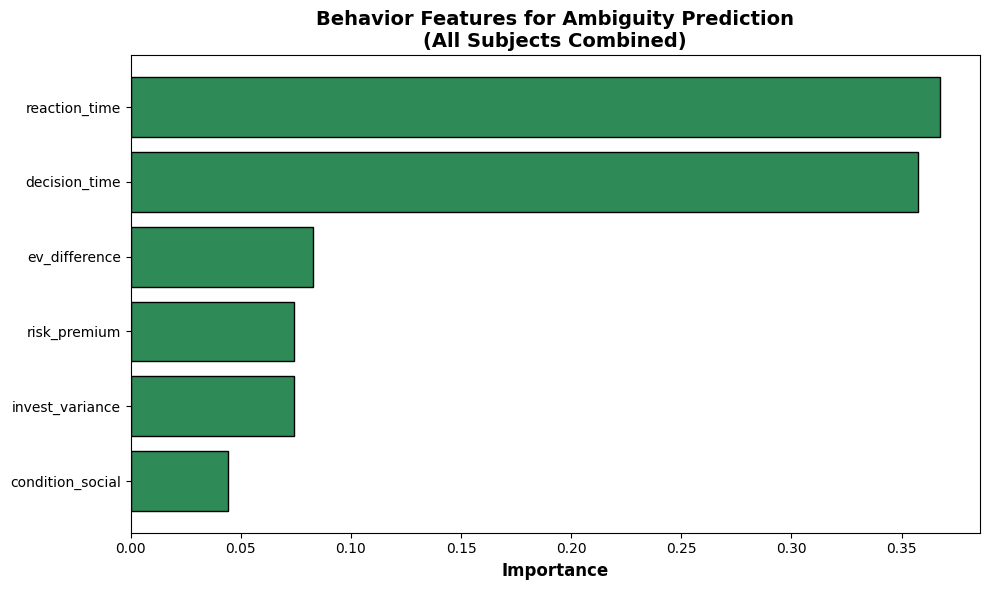

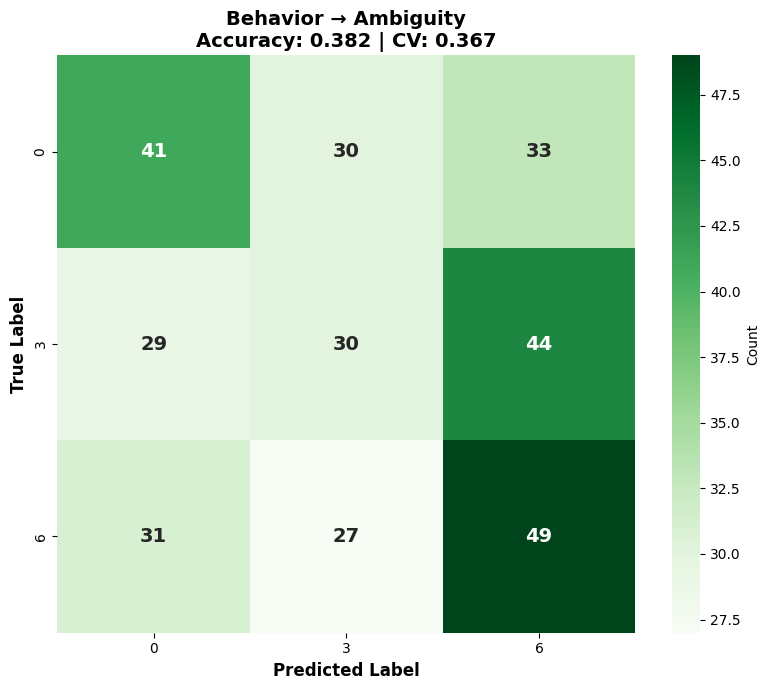

In [50]:
# =============================================================================
# TASK 3: BEHAVIOR → AMBIGUITY
# =============================================================================
print(f"\n{'='*80}")
print(f"TASK 3: BEHAVIOR → AMBIGUITY")
print(f"{'='*80}")

# Prepare data
X_behavior = behavior_df.drop(columns=['subject_id', 'trial_id']).values
y = ambiguity

# Train-test split (same random state for fair comparison)
X_train_behavior, X_test_behavior, y_train, y_test = train_test_split(
    X_behavior, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTraining samples: {len(y_train)} (0: {np.sum(y_train==0)}, 3: {np.sum(y_train==3)}, 6: {np.sum(y_train==6)})")
print(f"Test samples: {len(y_test)} (0: {np.sum(y_test==0)}, 3: {np.sum(y_test==3)}, 6: {np.sum(y_test==6)})")

# Train Random Forest classifier
rf_behavior = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced'
)
rf_behavior.fit(X_train_behavior, y_train)

# Predictions
y_pred_behavior = rf_behavior.predict(X_test_behavior)
y_prob_behavior = rf_behavior.predict_proba(X_test_behavior)[:, 1]

# Evaluation
accuracy_behavior = accuracy_score(y_test, y_pred_behavior)
f1_behavior = f1_score(y_test, y_pred_behavior, average='weighted')
print(f"\nAccuracy: {accuracy_behavior:.3f}")
print(f"F1 Score: {f1_behavior:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_behavior, target_names=['No Ambiguity (0)', 'Medium Ambiguity (3)', 'High Ambiguity (6)']))

# Cross-validation
cv_scores_behavior = cross_val_score(rf_behavior, X_behavior, y, cv=5, scoring='accuracy')
print(f"\n5-Fold Cross-Validation Accuracy: {cv_scores_behavior.mean():.3f} (+/- {cv_scores_behavior.std():.3f})")

# Feature importance
feature_importance_behavior = pd.DataFrame({
    'feature': behavior_df.drop(columns=['subject_id', 'trial_id']).columns,
    'importance': rf_behavior.feature_importances_
}).sort_values('importance', ascending=False)

print("\nBehavior Feature Importance:")
print(feature_importance_behavior)

# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(range(len(feature_importance_behavior)), feature_importance_behavior['importance'], 
        color='seagreen', edgecolor='black')
ax.set_yticks(range(len(feature_importance_behavior)))
ax.set_yticklabels(feature_importance_behavior['feature'])
ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax.set_title('Behavior Features for Ambiguity Prediction\n(All Subjects Combined)', 
             fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

# Confusion matrix
cm_behavior = confusion_matrix(y_test, y_pred_behavior)
fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(cm_behavior, annot=True, fmt='d', cmap='Greens', ax=ax, cbar_kws={'label': 'Count'},
            xticklabels=['0', '3', '6'],
            yticklabels=['0', '3', '6'],
            annot_kws={'size': 14, 'weight': 'bold'})
ax.set_title(f'Behavior → Ambiguity\nAccuracy: {accuracy_behavior:.3f} | CV: {cv_scores_behavior.mean():.3f}', 
             fontsize=14, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## LOSO


TASK 3: BEHAVIOR → AMBIGUITY - LEAVE-ONE-SUBJECT-OUT (LOSO)

Number of subjects: 10
Number of LOSO splits: 10

Fold 1/10 - Test subject: 0927_0930_U9TEJGM
  Train samples: 945 (0: 316, 3: 310, 6: 319)
  Test samples: 99 (0: 31, 3: 32, 6: 36)
  Accuracy: 0.384 | F1: 0.366

Fold 2/10 - Test subject: 0928_1600_539136F
  Train samples: 934 (0: 308, 3: 305, 6: 321)
  Test samples: 110 (0: 39, 3: 37, 6: 34)
  Accuracy: 0.291 | F1: 0.291

Fold 3/10 - Test subject: 0928_1600_9M4VCHG
  Train samples: 927 (0: 308, 3: 303, 6: 316)
  Test samples: 117 (0: 39, 3: 39, 6: 39)
  Accuracy: 0.368 | F1: 0.358

Fold 4/10 - Test subject: 0928_1600_U9TEJGM
  Train samples: 951 (0: 315, 3: 312, 6: 324)
  Test samples: 93 (0: 32, 3: 30, 6: 31)
  Accuracy: 0.495 | F1: 0.486

Fold 5/10 - Test subject: 0930_1700_539136F
  Train samples: 949 (0: 313, 3: 313, 6: 323)
  Test samples: 95 (0: 34, 3: 29, 6: 32)
  Accuracy: 0.358 | F1: 0.311

Fold 6/10 - Test subject: 0930_1700_9M4VCHG
  Train samples: 932 (0: 311, 3:

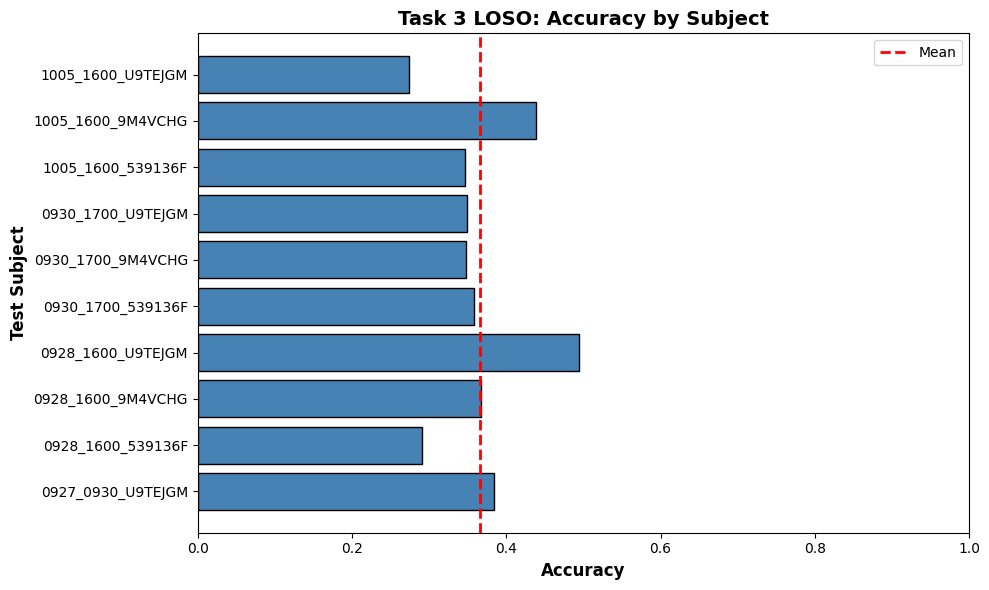

In [51]:
# =============================================================================
# TASK 3: BEHAVIOR → AMBIGUITY - LOSO CROSS-VALIDATION
# =============================================================================
from sklearn.model_selection import LeaveOneGroupOut

print(f"\n{'='*80}")
print(f"TASK 3: BEHAVIOR → AMBIGUITY - LEAVE-ONE-SUBJECT-OUT (LOSO)")
print(f"{'='*80}")

# Prepare data
X_behavior = behavior_df.drop(columns=['subject_id', 'trial_id']).values
y = ambiguity
groups = subjects  # Subject IDs for grouping

# Initialize LOSO cross-validator
logo = LeaveOneGroupOut()
n_splits = logo.get_n_splits(X_behavior, y, groups)

print(f"\nNumber of subjects: {len(np.unique(groups))}")
print(f"Number of LOSO splits: {n_splits}")

# Store results for each fold
loso_results_task3 = []

for fold_idx, (train_idx, test_idx) in enumerate(logo.split(X_behavior, y, groups)):
    # Get train and test data
    X_train = X_behavior[train_idx]
    X_test = X_behavior[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]
    
    # Get the test subject ID
    test_subject = np.unique(groups[test_idx])[0]
    
    print(f"\nFold {fold_idx + 1}/{n_splits} - Test subject: {test_subject}")
    print(f"  Train samples: {len(y_train)} (0: {np.sum(y_train==0)}, 3: {np.sum(y_train==3)}, 6: {np.sum(y_train==6)})")
    print(f"  Test samples: {len(y_test)} (0: {np.sum(y_test==0)}, 3: {np.sum(y_test==3)}, 6: {np.sum(y_test==6)})")
    
    # Train model
    rf = RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        max_depth=5,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced'
    )
    rf.fit(X_train, y_train)
    
    # Predictions
    y_pred = rf.predict(X_test)
    y_prob = rf.predict_proba(X_test)[:, 1]
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"  Accuracy: {accuracy:.3f} | F1: {f1:.3f}")
    
    # Store results
    loso_results_task3.append({
        'fold': fold_idx + 1,
        'test_subject': test_subject,
        'n_train': len(y_train),
        'n_test': len(y_test),
        'accuracy': accuracy,
        'f1_score': f1,
        'y_true': y_test,
        'y_pred': y_pred,
        'y_prob': y_prob
    })

# Summary statistics
loso_df_task3 = pd.DataFrame(loso_results_task3)
print(f"\n{'='*80}")
print(f"TASK 3 LOSO CROSS-VALIDATION SUMMARY")
print(f"{'='*80}")
print(f"\nMean Accuracy: {loso_df_task3['accuracy'].mean():.3f} (+/- {loso_df_task3['accuracy'].std():.3f})")
print(f"Mean F1 Score: {loso_df_task3['f1_score'].mean():.3f} (+/- {loso_df_task3['f1_score'].std():.3f})")
print(f"\nPer-subject results:")
print(loso_df_task3[['test_subject', 'n_test', 'accuracy', 'f1_score']].to_string(index=False))

# Visualize LOSO results
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 1: Accuracy by subject
ax.barh(range(len(loso_df_task3)), loso_df_task3['accuracy'], color='steelblue', edgecolor='black')
ax.axvline(loso_df_task3['accuracy'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
ax.set_yticks(range(len(loso_df_task3)))
ax.set_yticklabels(loso_df_task3['test_subject'])
ax.set_xlabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_ylabel('Test Subject', fontsize=12, fontweight='bold')
ax.set_title('Task 3 LOSO: Accuracy by Subject', fontsize=14, fontweight='bold')
ax.legend()
ax.set_xlim([0, 1])

plt.tight_layout()
plt.show()


## Stratified Sample


TASK 3: BEHAVIOR → AMBIGUITY - STRATIFIED SPLIT BY SUBJECT

Total subjects: 10
Train samples: 727
Test samples: 317

Train distribution: KEEP=242, INVEST=0
Test distribution: KEEP=105, INVEST=0

TASK 3 STRATIFIED SPLIT RESULTS

Classification Report:
                      precision    recall  f1-score   support

    No Ambiguity (0)       0.37      0.49      0.42       105
Medium Ambiguity (3)       0.33      0.27      0.30       103
  High Ambiguity (6)       0.42      0.36      0.39       109

            accuracy                           0.37       317
           macro avg       0.37      0.37      0.37       317
        weighted avg       0.37      0.37      0.37       317


Accuracy: 0.372
F1 Score: 0.368

Cross-validation scores: [0.36363636 0.34449761 0.35885167 0.36842105 0.39903846]
Mean CV Accuracy: 0.367 (+/- 0.018)

Top 10 Important Features:
         feature  importance
   reaction_time    0.359346
   decision_time    0.341037
 invest_variance    0.084392
    risk_premiu

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 2 with shape (6,) and arg 3 with shape (7,).

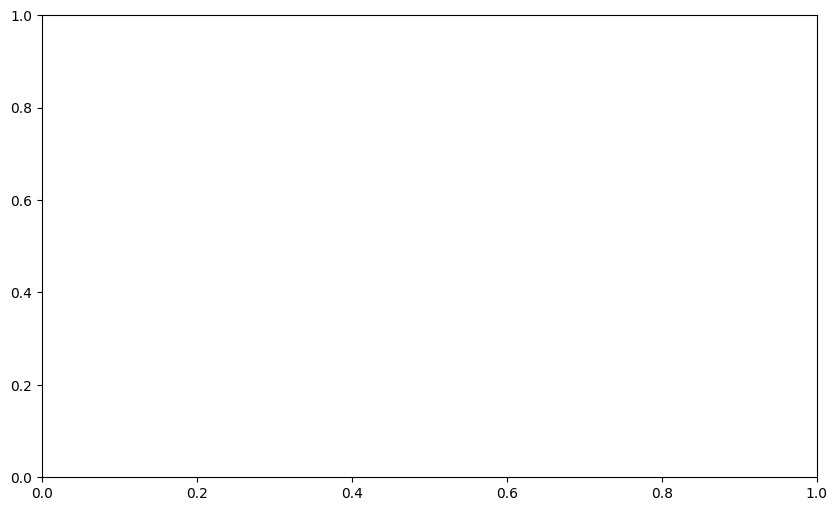

In [52]:
# =============================================================================
# TASK 3: BEHAVIOR → AMBIGUITY - STRATIFIED SPLIT BY SUBJECT
# =============================================================================

print(f"\n{'='*80}")
print(f"TASK 3: BEHAVIOR → AMBIGUITY - STRATIFIED SPLIT BY SUBJECT")
print(f"{'='*80}")

# Get unique subjects
unique_subjects = physiology_df['subject_id'].unique()
print(f"\nTotal subjects: {len(unique_subjects)}")

# For each subject, take 70% for train, 30% for test
train_indices = []
test_indices = []

for subject in unique_subjects:
    subject_mask = physiology_df['subject_id'] == subject
    subject_indices = np.where(subject_mask)[0]
    
    # Get subject's ambiguity
    subject_ambiguity = ambiguity[subject_indices]
    
    # Stratified split for this subject
    if len(subject_indices) > 1:
        train_idx, test_idx = train_test_split(
            subject_indices, 
            test_size=0.3, 
            random_state=42,
            stratify=subject_ambiguity if len(np.unique(subject_ambiguity)) > 1 else None
        )
    else:
        # If only one sample, put in train
        train_idx = subject_indices
        test_idx = []
    
    train_indices.extend(train_idx)
    test_indices.extend(test_idx)

train_indices = np.array(train_indices)
test_indices = np.array(test_indices)

print(f"Train samples: {len(train_indices)}")
print(f"Test samples: {len(test_indices)}")

# Prepare behavior data
X_behavior = behavior_df.drop(columns=['subject_id', 'trial_id']).values
y = ambiguity

# Split data
X_train_strat = X_behavior[train_indices]
X_test_strat = X_behavior[test_indices]
y_train_strat = y[train_indices]
y_test_strat = y[test_indices]

print(f"\nTrain distribution: KEEP={np.sum(y_train_strat==0)}, INVEST={np.sum(y_train_strat==1)}")
print(f"Test distribution: KEEP={np.sum(y_test_strat==0)}, INVEST={np.sum(y_test_strat==1)}")

# Train model
rf_strat_task3 = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced'
)

rf_strat_task3.fit(X_train_strat, y_train_strat)

# Predictions
y_pred_strat_task3 = rf_strat_task3.predict(X_test_strat)

# Evaluation
print(f"\n{'='*80}")
print(f"TASK 3 STRATIFIED SPLIT RESULTS")
print(f"{'='*80}")
print("\nClassification Report:")
print(classification_report(y_test_strat, y_pred_strat_task3, target_names=['No Ambiguity (0)', 'Medium Ambiguity (3)', 'High Ambiguity (6)']))

accuracy_strat_task3 = accuracy_score(y_test_strat, y_pred_strat_task3)
f1_strat_task3 = f1_score(y_test_strat, y_pred_strat_task3, average='weighted')
print(f"\nAccuracy: {accuracy_strat_task3:.3f}")
print(f"F1 Score: {f1_strat_task3:.3f}")

# Cross-validation
cv_scores_strat_task3 = cross_val_score(rf_strat_task3, X_behavior, y, cv=5, scoring='accuracy')
print(f"\nCross-validation scores: {cv_scores_strat_task3}")
print(f"Mean CV Accuracy: {cv_scores_strat_task3.mean():.3f} (+/- {cv_scores_strat_task3.std():.3f})")

# Feature importance
feature_importance_strat_task3 = pd.DataFrame({
    'feature': behavior_df.drop(columns=['subject_id', 'trial_id']).columns,
    'importance': rf_strat_task3.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 10 Important Features:")
print(feature_importance_strat_task3.head(10).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(7), feature_importance_strat_task3['importance'].head(10)[::-1], color='steelblue', edgecolor='black')
plt.yticks(range(7), feature_importance_strat_task3['feature'].head(10)[::-1])
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title(f'Task 3 Stratified: Top 10 Feature Importances\nAccuracy: {accuracy_strat_task3:.3f} | CV: {cv_scores_strat_task3.mean():.3f}', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Confusion matrix
cm_strat_task3 = confusion_matrix(y_test_strat, y_pred_strat_task3)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_strat_task3, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['0', '3', '6'], yticklabels=['0', '3', '6'], ax=ax)
ax.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax.set_title(f'Task 3 Stratified: Confusion Matrix\nAccuracy: {accuracy_strat_task3:.3f}', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## Comparison


TASK 3: BEHAVIOR → OUTCOME - ALL METHODS COMPARISON


TASK 3 RESULTS COMPARISON:
          Method  Accuracy  F1_Score
    Random Split  0.662420  0.669987
            LOSO  0.691730  0.713237
Stratified Split  0.662461  0.670867


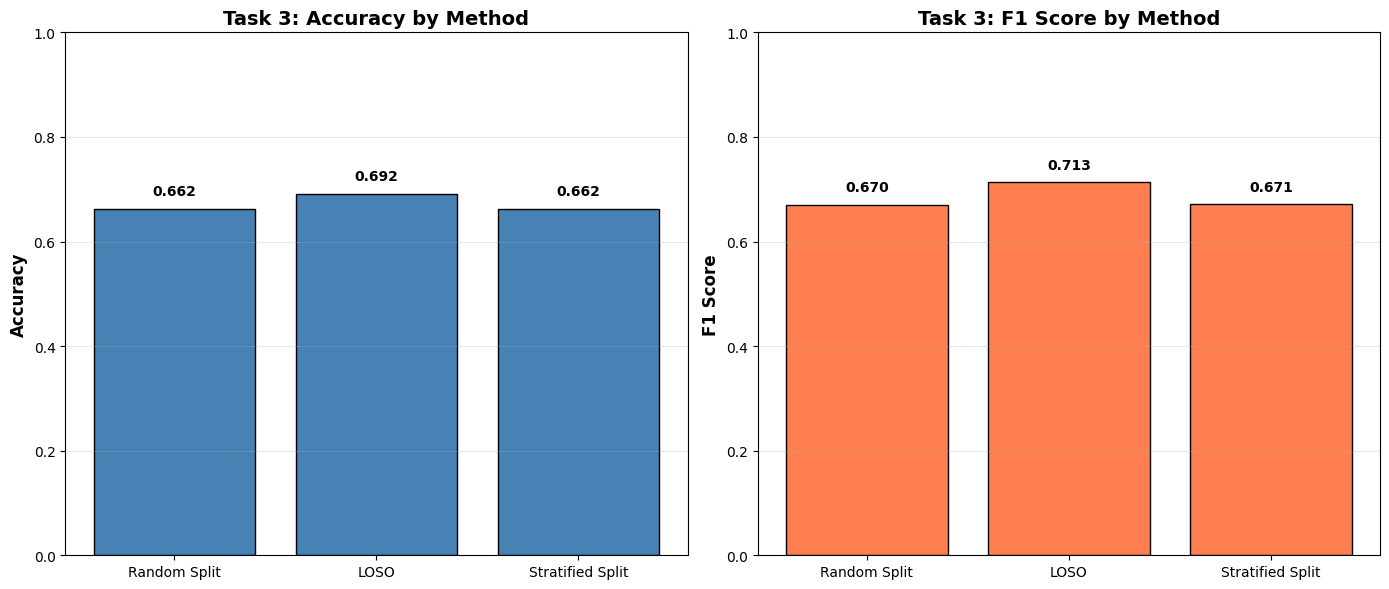


KEY FINDINGS:
Best performing method: LOSO with accuracy of 0.692


In [ ]:
# =============================================================================
# TASK 3 RESULTS SUMMARY - ALL METHODS COMPARISON
# =============================================================================

print(f"\n{'='*80}")
print(f"TASK 3: BEHAVIOR → AMBIGUITY - ALL METHODS COMPARISON")
print(f"{'='*80}\n")

# Collect all Task 3 results from stored variables
task3_results = []

# Random Split (use stored variable)
task3_results.append({'Method': 'Random Split', 'Accuracy': accuracy_behavior, 'F1_Score': f1_behavior})

# LOSO
task3_results.append({
    'Method': 'LOSO',
    'Accuracy': loso_df_task3['accuracy'].mean(),
    'F1_Score': loso_df_task3['f1_score'].mean()
})

# Stratified Split
task3_results.append({
    'Method': 'Stratified Split',
    'Accuracy': accuracy_strat_task3,
    'F1_Score': f1_strat_task3
})

# Create DataFrame
task3_comparison_df = pd.DataFrame(task3_results)

print("\nTASK 3 RESULTS COMPARISON:")
print(task3_comparison_df.to_string(index=False))

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy comparison
x_pos = np.arange(len(task3_comparison_df))
ax1.bar(x_pos, task3_comparison_df['Accuracy'], color='steelblue', edgecolor='black')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(task3_comparison_df['Method'], rotation=0, ha='center', fontsize=10)
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Task 3: Accuracy by Method', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 1])
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(task3_comparison_df['Accuracy']):
    ax1.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# F1 Score comparison
ax2.bar(x_pos, task3_comparison_df['F1_Score'], color='coral', edgecolor='black')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(task3_comparison_df['Method'], rotation=0, ha='center', fontsize=10)
ax2.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
ax2.set_title('Task 3: F1 Score by Method', fontsize=14, fontweight='bold')
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(task3_comparison_df['F1_Score']):
    ax2.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("KEY FINDINGS:")
print("="*80)
best_method = task3_comparison_df.loc[task3_comparison_df['Accuracy'].idxmax(), 'Method']
best_accuracy = task3_comparison_df['Accuracy'].max()
print(f"Best performing method: {best_method} with accuracy of {best_accuracy:.3f}")


## 6. TASK 4: BEHAVIOR + PHYSIOLOGY → AMBIGUITY (Combined)

Classify ambiguity using **combined physiological and behavioral features**.

**Hypothesis**: Combining multiple modalities (physiology + behavior) provides better discrimination than either alone.

**Why combine?**
- Physiology captures unconscious/automatic responses
- Behavior captures conscious decision-making
- Together they provide complementary information

**Expected outcome**: Improved classification accuracy compared to single-modality models.

## Random

### Baseline


TASK 4: BEHAVIOR + PHYSIOLOGY → AMBIGUITY (PRE FEATURES)

Combined feature shape: (1044, 37)
  - Physiology (pre): 19 features
  - Behavior: 6 features
  - Total: 37 features

Train samples: 730 (Low: 243, High: 0)
Test samples: 314 (0: 104, 3: 103, 6: 107)

TASK 4 RANDOM SPLIT (PRE) RESULTS

Classification Report:
                      precision    recall  f1-score   support

    No Ambiguity (0)       0.37      0.33      0.35       104
Medium Ambiguity (3)       0.33      0.29      0.31       103
  High Ambiguity (6)       0.43      0.53      0.47       107

            accuracy                           0.39       314
           macro avg       0.38      0.38      0.38       314
        weighted avg       0.38      0.39      0.38       314


Accuracy: 0.385
F1 Score: 0.379

Cross-validation scores: [0.36363636 0.35406699 0.30143541 0.34449761 0.34134615]
Mean CV Accuracy: 0.341 (+/- 0.021)

Top 15 Important Features:
                        feature  importance
                  dec

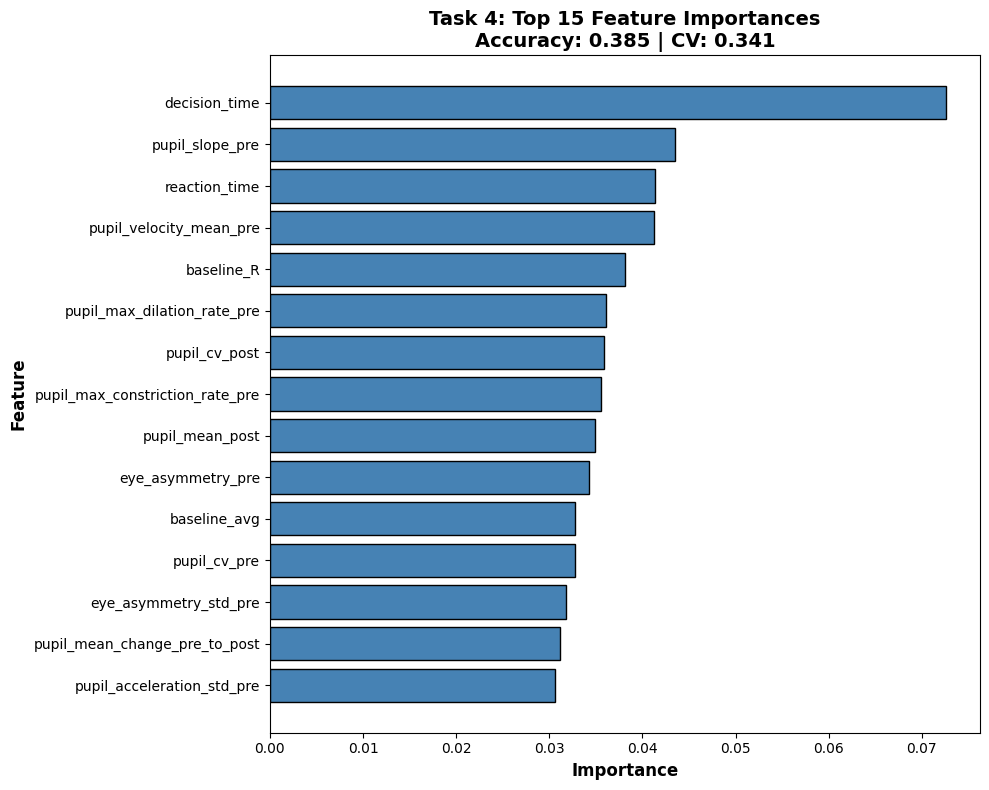

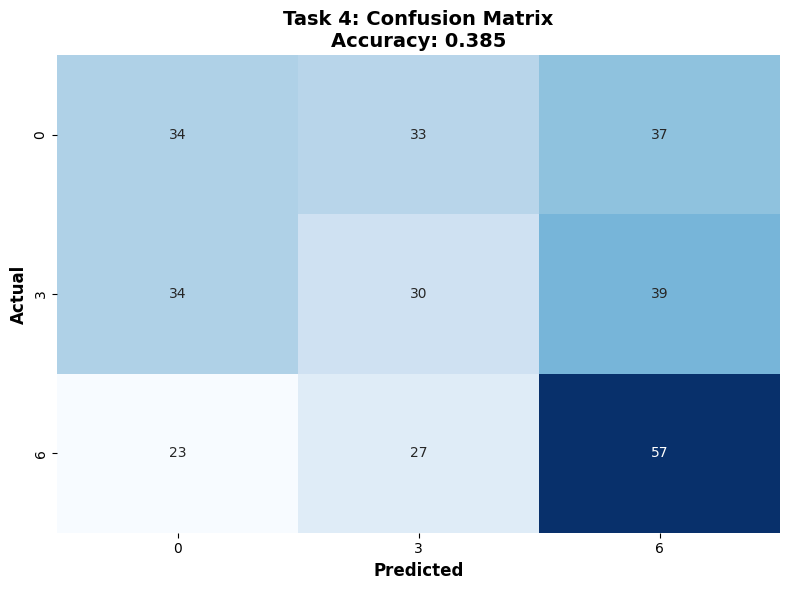

In [53]:
# =============================================================================
# TASK 4: BEHAVIOR + PHYSIOLOGY → AMBIGUITY - RANDOM SPLIT (Pre Features)
# =============================================================================

print(f"\n{'='*80}")
print(f"TASK 4: BEHAVIOR + PHYSIOLOGY → AMBIGUITY (PRE FEATURES)")
print(f"{'='*80}")

# Combine physiology features and behavior features
physio_features = physiology_df.drop(columns=['subject_id', 'trial_id'])
behavior_features = behavior_df.drop(columns=['subject_id', 'trial_id'])

# Concatenate features
X_combined = pd.concat([physio_features, behavior_features], axis=1)
print(f"\nCombined feature shape: {X_combined.shape}")
print(f"  - Physiology (pre): {len(pre_cols)} features")
print(f"  - Behavior: {behavior_features.shape[1]} features")
print(f"  - Total: {X_combined.shape[1]} features")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_combined.values, ambiguity, test_size=0.3, random_state=42, stratify=ambiguity
)

print(f"\nTrain samples: {len(y_train)} (Low: {np.sum(y_train==0)}, High: {np.sum(y_train==1)})")
print(f"Test samples: {len(y_test)} (0: {np.sum(y_test==0)}, 3: {np.sum(y_test==3)}, 6: {np.sum(y_test==6)})")

# Train Random Forest
rf_combined = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced'
)

rf_combined.fit(X_train, y_train)

# Predictions
y_pred_combined = rf_combined.predict(X_test)

# Evaluation
print(f"\n{'='*80}")
print(f"TASK 4 RANDOM SPLIT (PRE) RESULTS")
print(f"{'='*80}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_combined, target_names=['No Ambiguity (0)', 'Medium Ambiguity (3)', 'High Ambiguity (6)']))

accuracy_combined = accuracy_score(y_test, y_pred_combined)
f1_combined = f1_score(y_test, y_pred_combined, average='weighted')
print(f"\nAccuracy: {accuracy_combined:.3f}")
print(f"F1 Score: {f1_combined:.3f}")

# Cross-validation
cv_scores_combined = cross_val_score(rf_combined, X_combined.values, ambiguity, cv=5, scoring='accuracy')
print(f"\nCross-validation scores: {cv_scores_combined}")
print(f"Mean CV Accuracy: {cv_scores_combined.mean():.3f} (+/- {cv_scores_combined.std():.3f})")

# Feature importance
feature_importance_combined = pd.DataFrame({
    'feature': X_combined.columns,
    'importance': rf_combined.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 15 Important Features:")
print(feature_importance_combined.head(15).to_string(index=False))

# Visualize feature importance (top 15)
plt.figure(figsize=(10, 8))
plt.barh(range(15), feature_importance_combined['importance'].head(15)[::-1], color='steelblue', edgecolor='black')
plt.yticks(range(15), feature_importance_combined['feature'].head(15)[::-1])
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title(f'Task 4: Top 15 Feature Importances\nAccuracy: {accuracy_combined:.3f} | CV: {cv_scores_combined.mean():.3f}',
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Confusion matrix
cm_combined_pre = confusion_matrix(y_test, y_pred_combined)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_combined_pre, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['0', '3', '6'], yticklabels=['0', '3', '6'], ax=ax)
ax.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax.set_title(f'Task 4: Confusion Matrix\nAccuracy: {accuracy_combined:.3f}',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Pre predict post


TASK 4: BEHAVIOR + PHYSIOLOGY → AMBIGUITY (PRE FEATURES)

Combined feature shape: (1044, 25)
  - Physiology (pre): 19 features
  - Behavior: 6 features
  - Total: 25 features

Train samples: 730 (Low: 243, High: 0)
Test samples: 314 (0: 104, 3: 103, 6: 107)

TASK 4 RANDOM SPLIT (PRE) RESULTS

Classification Report:
                      precision    recall  f1-score   support

    No Ambiguity (0)       0.27      0.25      0.26       104
Medium Ambiguity (3)       0.30      0.29      0.30       103
  High Ambiguity (6)       0.35      0.38      0.37       107

            accuracy                           0.31       314
           macro avg       0.31      0.31      0.31       314
        weighted avg       0.31      0.31      0.31       314


Accuracy: 0.309
F1 Score: 0.307

Cross-validation scores: [0.33971292 0.35885167 0.33492823 0.33971292 0.32692308]
Mean CV Accuracy: 0.340 (+/- 0.011)

Top 15 Important Features:
                        feature  importance
                  dec

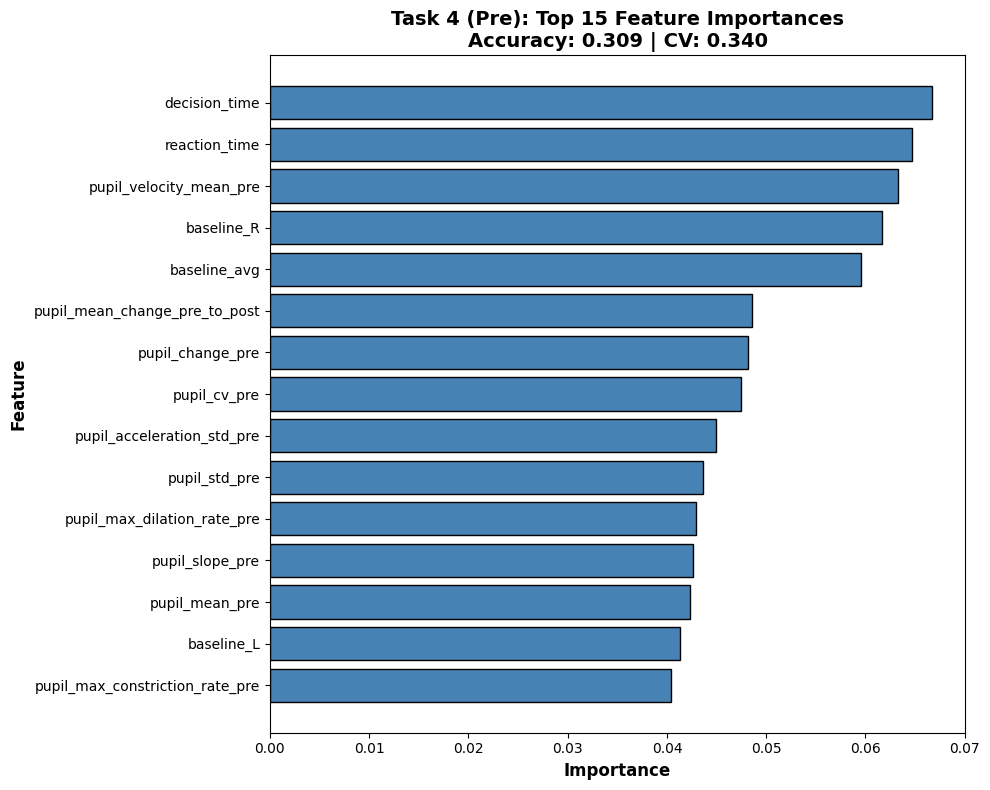

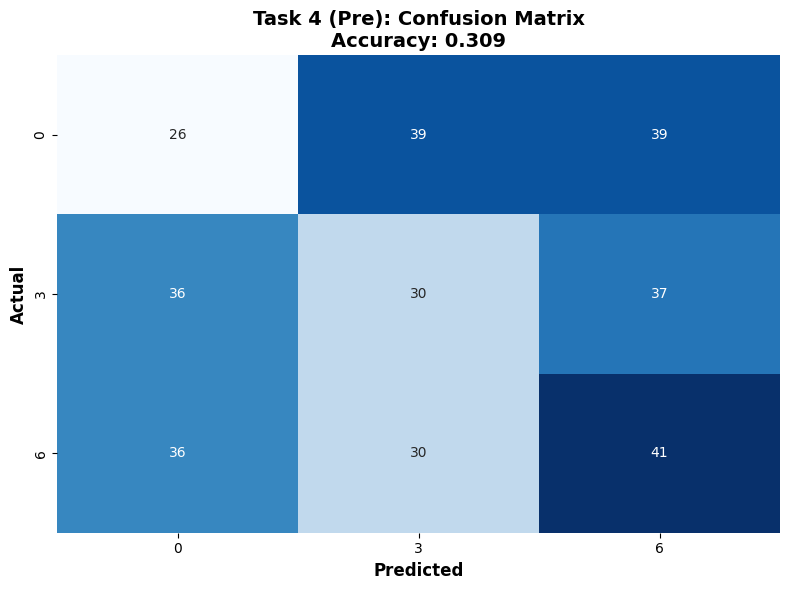

In [54]:
# =============================================================================
# TASK 4: BEHAVIOR + PHYSIOLOGY → AMBIGUITY - RANDOM SPLIT (Pre Features)
# =============================================================================

print(f"\n{'='*80}")
print(f"TASK 4: BEHAVIOR + PHYSIOLOGY → AMBIGUITY (PRE FEATURES)")
print(f"{'='*80}")

# Combine physiology PRE features and behavior features
physio_pre_features = physiology_df.drop(columns=['subject_id', 'trial_id'])[pre_cols]
behavior_features = behavior_df.drop(columns=['subject_id', 'trial_id'])

# Concatenate features
X_combined_pre = pd.concat([physio_pre_features, behavior_features], axis=1)
print(f"\nCombined feature shape: {X_combined_pre.shape}")
print(f"  - Physiology (pre): {len(pre_cols)} features")
print(f"  - Behavior: {behavior_features.shape[1]} features")
print(f"  - Total: {X_combined_pre.shape[1]} features")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_combined_pre.values, ambiguity, test_size=0.3, random_state=42, stratify=ambiguity
)

print(f"\nTrain samples: {len(y_train)} (Low: {np.sum(y_train==0)}, High: {np.sum(y_train==1)})")
print(f"Test samples: {len(y_test)} (0: {np.sum(y_test==0)}, 3: {np.sum(y_test==3)}, 6: {np.sum(y_test==6)})")

# Train Random Forest
rf_combined_pre = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced'
)

rf_combined_pre.fit(X_train, y_train)

# Predictions
y_pred_combined_pre = rf_combined_pre.predict(X_test)

# Evaluation
print(f"\n{'='*80}")
print(f"TASK 4 RANDOM SPLIT (PRE) RESULTS")
print(f"{'='*80}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_combined_pre, target_names=['No Ambiguity (0)', 'Medium Ambiguity (3)', 'High Ambiguity (6)']))

accuracy_combined_pre = accuracy_score(y_test, y_pred_combined_pre)
f1_combined_pre = f1_score(y_test, y_pred_combined_pre, average='weighted')
print(f"\nAccuracy: {accuracy_combined_pre:.3f}")
print(f"F1 Score: {f1_combined_pre:.3f}")

# Cross-validation
cv_scores_combined_pre = cross_val_score(rf_combined_pre, X_combined_pre.values, ambiguity, cv=5, scoring='accuracy')
print(f"\nCross-validation scores: {cv_scores_combined_pre}")
print(f"Mean CV Accuracy: {cv_scores_combined_pre.mean():.3f} (+/- {cv_scores_combined_pre.std():.3f})")

# Feature importance
feature_importance_combined_pre = pd.DataFrame({
    'feature': X_combined_pre.columns,
    'importance': rf_combined_pre.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 15 Important Features:")
print(feature_importance_combined_pre.head(15).to_string(index=False))

# Visualize feature importance (top 15)
plt.figure(figsize=(10, 8))
plt.barh(range(15), feature_importance_combined_pre['importance'].head(15)[::-1], color='steelblue', edgecolor='black')
plt.yticks(range(15), feature_importance_combined_pre['feature'].head(15)[::-1])
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title(f'Task 4 (Pre): Top 15 Feature Importances\nAccuracy: {accuracy_combined_pre:.3f} | CV: {cv_scores_combined_pre.mean():.3f}',
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Confusion matrix
cm_combined_pre = confusion_matrix(y_test, y_pred_combined_pre)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_combined_pre, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['0', '3', '6'], yticklabels=['0', '3', '6'], ax=ax)
ax.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax.set_title(f'Task 4 (Pre): Confusion Matrix\nAccuracy: {accuracy_combined_pre:.3f}',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


### Post predict post


TASK 4: BEHAVIOR + PHYSIOLOGY → AMBIGUITY (POST FEATURES)

Combined feature shape: (1044, 23)
  - Physiology (post): 17 features
  - Behavior: 6 features
  - Total: 23 features

Train samples: 730 (Low: 243, High: 0)
Test samples: 314 (0: 104, 3: 103, 6: 107)

TASK 4 RANDOM SPLIT (POST) RESULTS

Classification Report:
                      precision    recall  f1-score   support

    No Ambiguity (0)       0.33      0.27      0.30       104
Medium Ambiguity (3)       0.27      0.26      0.26       103
  High Ambiguity (6)       0.38      0.45      0.41       107

            accuracy                           0.33       314
           macro avg       0.32      0.33      0.32       314
        weighted avg       0.32      0.33      0.32       314


Accuracy: 0.328
F1 Score: 0.324

Cross-validation scores: [0.34449761 0.33971292 0.33492823 0.3492823  0.375     ]
Mean CV Accuracy: 0.349 (+/- 0.014)

Top 15 Important Features:
                       feature  importance
                 de

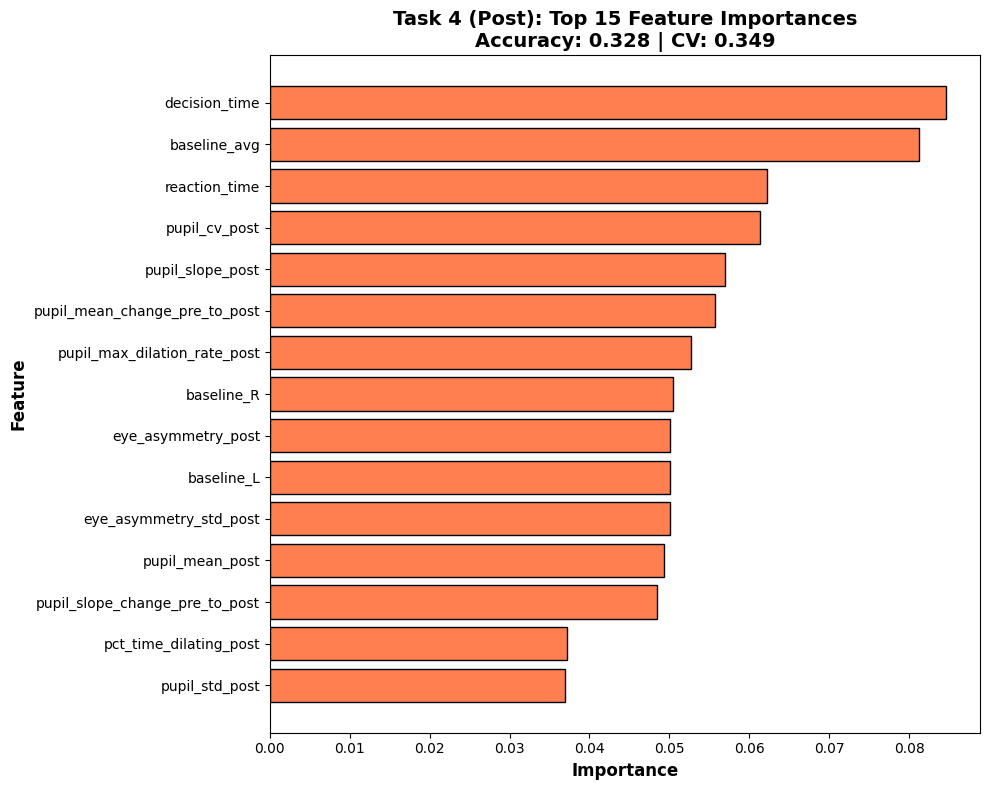

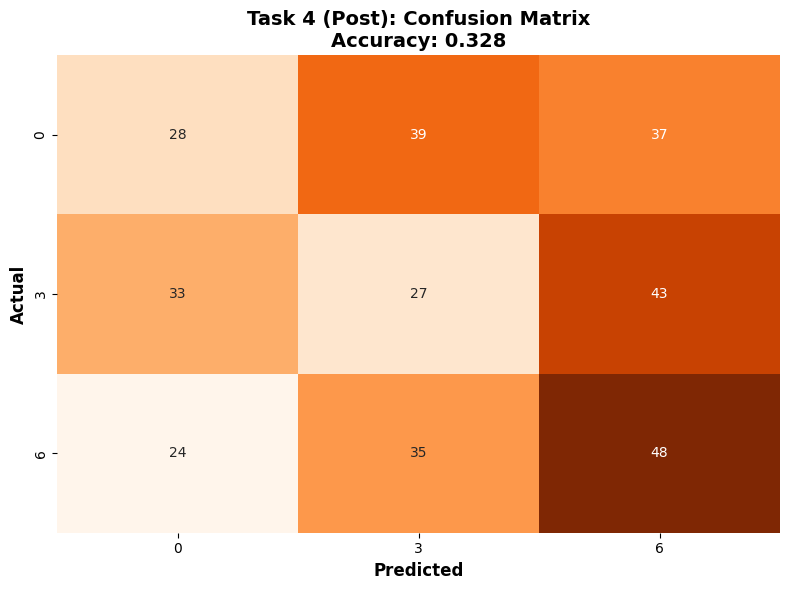

In [55]:
# =============================================================================
# TASK 4: BEHAVIOR + PHYSIOLOGY → AMBIGUITY - RANDOM SPLIT (Post Features)
# =============================================================================

print(f"\n{'='*80}")
print(f"TASK 4: BEHAVIOR + PHYSIOLOGY → AMBIGUITY (POST FEATURES)")
print(f"{'='*80}")

# Combine physiology POST features and behavior features
physio_post_features = physiology_df.drop(columns=['subject_id', 'trial_id'])[post_cols]
behavior_features = behavior_df.drop(columns=['subject_id', 'trial_id'])

# Concatenate features
X_combined_post = pd.concat([physio_post_features, behavior_features], axis=1)
print(f"\nCombined feature shape: {X_combined_post.shape}")
print(f"  - Physiology (post): {len(post_cols)} features")
print(f"  - Behavior: {behavior_features.shape[1]} features")
print(f"  - Total: {X_combined_post.shape[1]} features")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_combined_post.values, ambiguity, test_size=0.3, random_state=42, stratify=ambiguity
)

print(f"\nTrain samples: {len(y_train)} (Low: {np.sum(y_train==0)}, High: {np.sum(y_train==1)})")
print(f"Test samples: {len(y_test)} (0: {np.sum(y_test==0)}, 3: {np.sum(y_test==3)}, 6: {np.sum(y_test==6)})")

# Train Random Forest
rf_combined_post = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced'
)

rf_combined_post.fit(X_train, y_train)

# Predictions
y_pred_combined_post = rf_combined_post.predict(X_test)

# Evaluation
print(f"\n{'='*80}")
print(f"TASK 4 RANDOM SPLIT (POST) RESULTS")
print(f"{'='*80}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_combined_post, target_names=['No Ambiguity (0)', 'Medium Ambiguity (3)', 'High Ambiguity (6)']))

accuracy_combined_post = accuracy_score(y_test, y_pred_combined_post)
f1_combined_post = f1_score(y_test, y_pred_combined_post, average='weighted')
print(f"\nAccuracy: {accuracy_combined_post:.3f}")
print(f"F1 Score: {f1_combined_post:.3f}")

# Cross-validation
cv_scores_combined_post = cross_val_score(rf_combined_post, X_combined_post.values, ambiguity, cv=5, scoring='accuracy')
print(f"\nCross-validation scores: {cv_scores_combined_post}")
print(f"Mean CV Accuracy: {cv_scores_combined_post.mean():.3f} (+/- {cv_scores_combined_post.std():.3f})")

# Feature importance
feature_importance_combined_post = pd.DataFrame({
    'feature': X_combined_post.columns,
    'importance': rf_combined_post.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 15 Important Features:")
print(feature_importance_combined_post.head(15).to_string(index=False))

# Visualize feature importance (top 15)
plt.figure(figsize=(10, 8))
plt.barh(range(15), feature_importance_combined_post['importance'].head(15)[::-1], color='coral', edgecolor='black')
plt.yticks(range(15), feature_importance_combined_post['feature'].head(15)[::-1])
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title(f'Task 4 (Post): Top 15 Feature Importances\nAccuracy: {accuracy_combined_post:.3f} | CV: {cv_scores_combined_post.mean():.3f}',
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Confusion matrix
cm_combined_post = confusion_matrix(y_test, y_pred_combined_post)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_combined_post, annot=True, fmt='d', cmap='Oranges', cbar=False,
            xticklabels=['0', '3', '6'], yticklabels=['0', '3', '6'], ax=ax)
ax.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax.set_title(f'Task 4 (Post): Confusion Matrix\nAccuracy: {accuracy_combined_post:.3f}',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## LOSO

### Baseline


TASK 4: BEHAVIOR + PHYSIOLOGY → AMBIGUITY - LOSO

Number of subjects: 10
Number of LOSO splits: 10

Fold 1/10 - Test subject: 0927_0930_U9TEJGM
  Train samples: 945 (0: 316, 3: 310, 6: 319)
  Test samples: 99 (0: 31, 3: 32, 6: 36)
  Accuracy: 0.323 | F1: 0.266

Fold 2/10 - Test subject: 0928_1600_539136F
  Train samples: 934 (0: 308, 3: 305, 6: 321)
  Test samples: 110 (0: 39, 3: 37, 6: 34)
  Accuracy: 0.327 | F1: 0.303

Fold 3/10 - Test subject: 0928_1600_9M4VCHG
  Train samples: 927 (0: 308, 3: 303, 6: 316)
  Test samples: 117 (0: 39, 3: 39, 6: 39)
  Accuracy: 0.359 | F1: 0.354

Fold 4/10 - Test subject: 0928_1600_U9TEJGM
  Train samples: 951 (0: 315, 3: 312, 6: 324)
  Test samples: 93 (0: 32, 3: 30, 6: 31)
  Accuracy: 0.376 | F1: 0.379

Fold 5/10 - Test subject: 0930_1700_539136F
  Train samples: 949 (0: 313, 3: 313, 6: 323)
  Test samples: 95 (0: 34, 3: 29, 6: 32)
  Accuracy: 0.379 | F1: 0.264

Fold 6/10 - Test subject: 0930_1700_9M4VCHG
  Train samples: 932 (0: 311, 3: 305, 6: 31

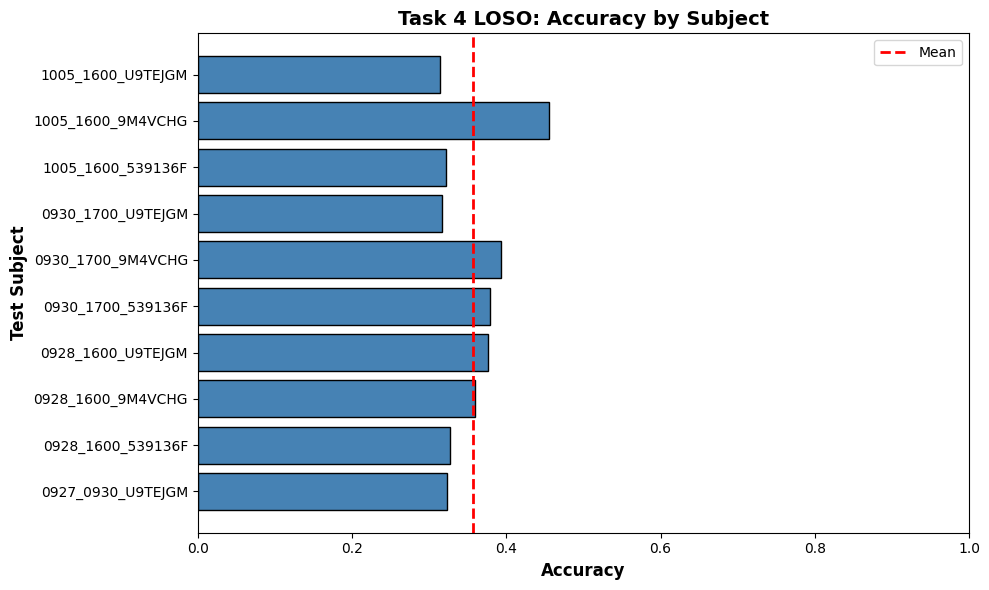

In [56]:
# =============================================================================
# TASK 4: BEHAVIOR + PHYSIOLOGY → AMBIGUITY - LOSO 
# =============================================================================
from sklearn.model_selection import LeaveOneGroupOut

print(f"\n{'='*80}")
print(f"TASK 4: BEHAVIOR + PHYSIOLOGY → AMBIGUITY - LOSO")
print(f"{'='*80}")

# Prepare combined data
X_combined_array = X_combined.values
y = ambiguity
groups = subjects

# Initialize LOSO cross-validator
logo = LeaveOneGroupOut()
n_splits = logo.get_n_splits(X_combined_array, y, groups)

print(f"\nNumber of subjects: {len(np.unique(groups))}")
print(f"Number of LOSO splits: {n_splits}")

# Store results for each fold
loso_results_task4 = []

for fold_idx, (train_idx, test_idx) in enumerate(logo.split(X_combined_array, y, groups)):
    # Get train and test data
    X_train = X_combined_array[train_idx]
    X_test = X_combined_array[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]
    
    # Get the test subject ID
    test_subject = np.unique(groups[test_idx])[0]
    
    print(f"\nFold {fold_idx + 1}/{n_splits} - Test subject: {test_subject}")
    print(f"  Train samples: {len(y_train)} (0: {np.sum(y_train==0)}, 3: {np.sum(y_train==3)}, 6: {np.sum(y_train==6)})")
    print(f"  Test samples: {len(y_test)} (0: {np.sum(y_test==0)}, 3: {np.sum(y_test==3)}, 6: {np.sum(y_test==6)})")
    
    # Train model
    rf = RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        max_depth=5,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced'
    )
    rf.fit(X_train, y_train)
    
    # Predictions
    y_pred = rf.predict(X_test)
    y_prob = rf.predict_proba(X_test)[:, 1]
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"  Accuracy: {accuracy:.3f} | F1: {f1:.3f}")
    
    # Store results
    loso_results_task4.append({
        'fold': fold_idx + 1,
        'test_subject': test_subject,
        'n_train': len(y_train),
        'n_test': len(y_test),
        'accuracy': accuracy,
        'f1_score': f1
    })

# Summary statistics
loso_df_task4 = pd.DataFrame(loso_results_task4)
print(f"\n{'='*80}")
print(f"TASK 4 LOSO SUMMARY")
print(f"{'='*80}")
print(f"\nMean Accuracy: {loso_df_task4['accuracy'].mean():.3f} (+/- {loso_df_task4['accuracy'].std():.3f})")
print(f"Mean F1 Score: {loso_df_task4['f1_score'].mean():.3f} (+/- {loso_df_task4['f1_score'].std():.3f})")
print(f"\nPer-subject results:")
print(loso_df_task4[['test_subject', 'n_test', 'accuracy', 'f1_score']].to_string(index=False))

# Visualize LOSO results
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 1: Accuracy by subject
ax.barh(range(len(loso_df_task4)), loso_df_task4['accuracy'], color='steelblue', edgecolor='black')
ax.axvline(loso_df_task4['accuracy'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
ax.set_yticks(range(len(loso_df_task4)))
ax.set_yticklabels(loso_df_task4['test_subject'])
ax.set_xlabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_ylabel('Test Subject', fontsize=12, fontweight='bold')
ax.set_title('Task 4 LOSO: Accuracy by Subject', fontsize=14, fontweight='bold')
ax.legend()
ax.set_xlim([0, 1])

plt.tight_layout()
plt.show()

### Pre predict post


TASK 4: BEHAVIOR + PHYSIOLOGY → AMBIGUITY - LOSO (PRE)

Number of subjects: 10
Number of LOSO splits: 10

Fold 1/10 - Test subject: 0927_0930_U9TEJGM
  Train samples: 945 (0: 316, 3: 310, 6: 319)
  Test samples: 99 (0: 31, 3: 32, 6: 36)
  Accuracy: 0.273 | F1: 0.219

Fold 2/10 - Test subject: 0928_1600_539136F
  Train samples: 934 (0: 308, 3: 305, 6: 321)
  Test samples: 110 (0: 39, 3: 37, 6: 34)
  Accuracy: 0.255 | F1: 0.235

Fold 3/10 - Test subject: 0928_1600_9M4VCHG
  Train samples: 927 (0: 308, 3: 303, 6: 316)
  Test samples: 117 (0: 39, 3: 39, 6: 39)
  Accuracy: 0.385 | F1: 0.378

Fold 4/10 - Test subject: 0928_1600_U9TEJGM
  Train samples: 951 (0: 315, 3: 312, 6: 324)
  Test samples: 93 (0: 32, 3: 30, 6: 31)
  Accuracy: 0.344 | F1: 0.343

Fold 5/10 - Test subject: 0930_1700_539136F
  Train samples: 949 (0: 313, 3: 313, 6: 323)
  Test samples: 95 (0: 34, 3: 29, 6: 32)
  Accuracy: 0.368 | F1: 0.249

Fold 6/10 - Test subject: 0930_1700_9M4VCHG
  Train samples: 932 (0: 311, 3: 305,

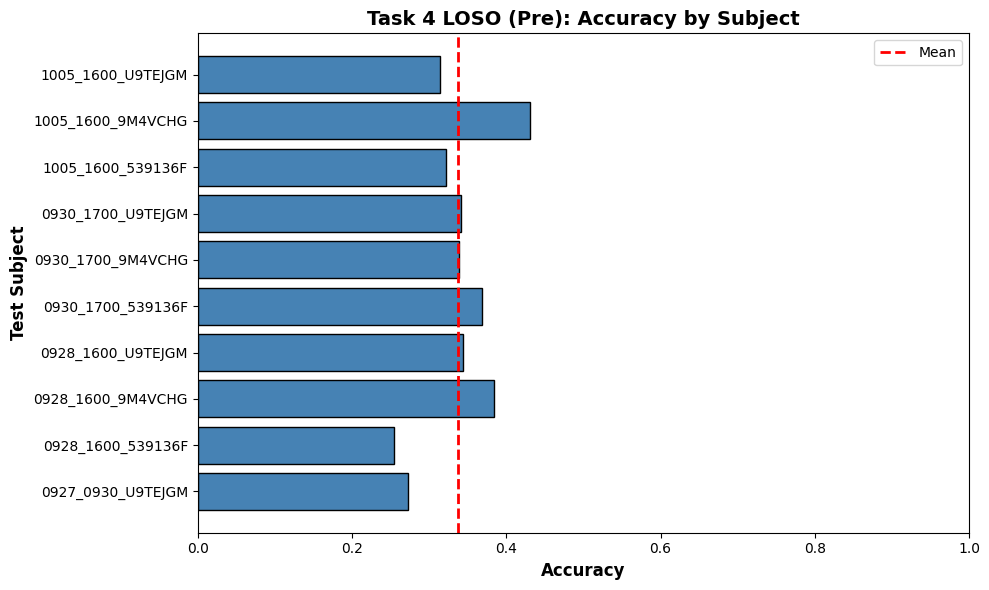

In [57]:
# =============================================================================
# TASK 4: BEHAVIOR + PHYSIOLOGY → AMBIGUITY - LOSO (Pre Features)
# =============================================================================
from sklearn.model_selection import LeaveOneGroupOut

print(f"\n{'='*80}")
print(f"TASK 4: BEHAVIOR + PHYSIOLOGY → AMBIGUITY - LOSO (PRE)")
print(f"{'='*80}")

# Prepare combined data
X_combined_pre_array = X_combined_pre.values
y = ambiguity
groups = subjects

# Initialize LOSO cross-validator
logo = LeaveOneGroupOut()
n_splits = logo.get_n_splits(X_combined_pre_array, y, groups)

print(f"\nNumber of subjects: {len(np.unique(groups))}")
print(f"Number of LOSO splits: {n_splits}")

# Store results for each fold
loso_results_task4_pre = []

for fold_idx, (train_idx, test_idx) in enumerate(logo.split(X_combined_pre_array, y, groups)):
    # Get train and test data
    X_train = X_combined_pre_array[train_idx]
    X_test = X_combined_pre_array[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]
    
    # Get the test subject ID
    test_subject = np.unique(groups[test_idx])[0]
    
    print(f"\nFold {fold_idx + 1}/{n_splits} - Test subject: {test_subject}")
    print(f"  Train samples: {len(y_train)} (0: {np.sum(y_train==0)}, 3: {np.sum(y_train==3)}, 6: {np.sum(y_train==6)})")
    print(f"  Test samples: {len(y_test)} (0: {np.sum(y_test==0)}, 3: {np.sum(y_test==3)}, 6: {np.sum(y_test==6)})")
    
    # Train model
    rf = RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        max_depth=5,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced'
    )
    rf.fit(X_train, y_train)
    
    # Predictions
    y_pred = rf.predict(X_test)
    y_prob = rf.predict_proba(X_test)[:, 1]
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"  Accuracy: {accuracy:.3f} | F1: {f1:.3f}")
    
    # Store results
    loso_results_task4_pre.append({
        'fold': fold_idx + 1,
        'test_subject': test_subject,
        'n_train': len(y_train),
        'n_test': len(y_test),
        'accuracy': accuracy,
        'f1_score': f1
    })

# Summary statistics
loso_df_task4_pre = pd.DataFrame(loso_results_task4_pre)
print(f"\n{'='*80}")
print(f"TASK 4 LOSO (PRE) SUMMARY")
print(f"{'='*80}")
print(f"\nMean Accuracy: {loso_df_task4_pre['accuracy'].mean():.3f} (+/- {loso_df_task4_pre['accuracy'].std():.3f})")
print(f"Mean F1 Score: {loso_df_task4_pre['f1_score'].mean():.3f} (+/- {loso_df_task4_pre['f1_score'].std():.3f})")
print(f"\nPer-subject results:")
print(loso_df_task4_pre[['test_subject', 'n_test', 'accuracy', 'f1_score']].to_string(index=False))

# Visualize LOSO results
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 1: Accuracy by subject
ax.barh(range(len(loso_df_task4_pre)), loso_df_task4_pre['accuracy'], color='steelblue', edgecolor='black')
ax.axvline(loso_df_task4_pre['accuracy'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
ax.set_yticks(range(len(loso_df_task4_pre)))
ax.set_yticklabels(loso_df_task4_pre['test_subject'])
ax.set_xlabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_ylabel('Test Subject', fontsize=12, fontweight='bold')
ax.set_title('Task 4 LOSO (Pre): Accuracy by Subject', fontsize=14, fontweight='bold')
ax.legend()
ax.set_xlim([0, 1])

plt.tight_layout()
plt.show()


### Post predict post


TASK 4: BEHAVIOR + PHYSIOLOGY → AMBIGUITY - LOSO (POST)

Number of subjects: 10
Number of LOSO splits: 10

Fold 1/10 - Test subject: 0927_0930_U9TEJGM
  Train samples: 945 (0: 316, 3: 310, 6: 319)
  Test samples: 99 (0: 31, 3: 32, 6: 36)
  Accuracy: 0.323 | F1: 0.253

Fold 2/10 - Test subject: 0928_1600_539136F
  Train samples: 934 (0: 308, 3: 305, 6: 321)
  Test samples: 110 (0: 39, 3: 37, 6: 34)
  Accuracy: 0.264 | F1: 0.252

Fold 3/10 - Test subject: 0928_1600_9M4VCHG
  Train samples: 927 (0: 308, 3: 303, 6: 316)
  Test samples: 117 (0: 39, 3: 39, 6: 39)
  Accuracy: 0.359 | F1: 0.357

Fold 4/10 - Test subject: 0928_1600_U9TEJGM
  Train samples: 951 (0: 315, 3: 312, 6: 324)
  Test samples: 93 (0: 32, 3: 30, 6: 31)
  Accuracy: 0.409 | F1: 0.391

Fold 5/10 - Test subject: 0930_1700_539136F
  Train samples: 949 (0: 313, 3: 313, 6: 323)
  Test samples: 95 (0: 34, 3: 29, 6: 32)
  Accuracy: 0.379 | F1: 0.332

Fold 6/10 - Test subject: 0930_1700_9M4VCHG
  Train samples: 932 (0: 311, 3: 305

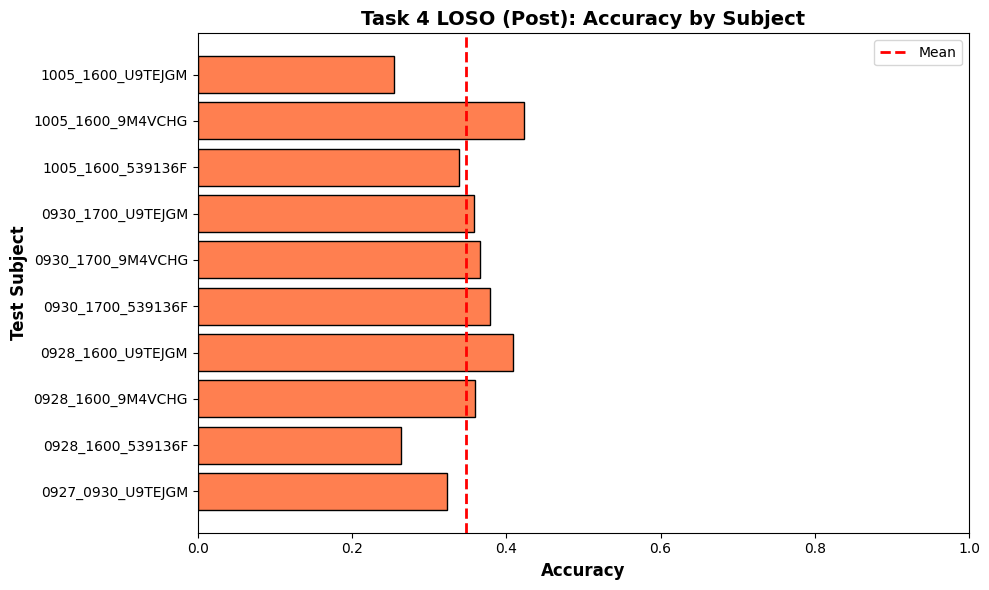

In [58]:
# =============================================================================
# TASK 4: BEHAVIOR + PHYSIOLOGY → AMBIGUITY - LOSO (Post Features)
# =============================================================================
from sklearn.model_selection import LeaveOneGroupOut

print(f"\n{'='*80}")
print(f"TASK 4: BEHAVIOR + PHYSIOLOGY → AMBIGUITY - LOSO (POST)")
print(f"{'='*80}")

# Prepare combined data
X_combined_post_array = X_combined_post.values
y = ambiguity
groups = subjects

# Initialize LOSO cross-validator
logo = LeaveOneGroupOut()
n_splits = logo.get_n_splits(X_combined_post_array, y, groups)

print(f"\nNumber of subjects: {len(np.unique(groups))}")
print(f"Number of LOSO splits: {n_splits}")

# Store results for each fold
loso_results_task4_post = []

for fold_idx, (train_idx, test_idx) in enumerate(logo.split(X_combined_post_array, y, groups)):
    # Get train and test data
    X_train = X_combined_post_array[train_idx]
    X_test = X_combined_post_array[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]
    
    # Get the test subject ID
    test_subject = np.unique(groups[test_idx])[0]
    
    print(f"\nFold {fold_idx + 1}/{n_splits} - Test subject: {test_subject}")
    print(f"  Train samples: {len(y_train)} (0: {np.sum(y_train==0)}, 3: {np.sum(y_train==3)}, 6: {np.sum(y_train==6)})")
    print(f"  Test samples: {len(y_test)} (0: {np.sum(y_test==0)}, 3: {np.sum(y_test==3)}, 6: {np.sum(y_test==6)})")
    
    # Train model
    rf = RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        max_depth=5,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced'
    )
    rf.fit(X_train, y_train)
    
    # Predictions
    y_pred = rf.predict(X_test)
    y_prob = rf.predict_proba(X_test)[:, 1]
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"  Accuracy: {accuracy:.3f} | F1: {f1:.3f}")
    
    # Store results
    loso_results_task4_post.append({
        'fold': fold_idx + 1,
        'test_subject': test_subject,
        'n_train': len(y_train),
        'n_test': len(y_test),
        'accuracy': accuracy,
        'f1_score': f1
    })

# Summary statistics
loso_df_task4_post = pd.DataFrame(loso_results_task4_post)
print(f"\n{'='*80}")
print(f"TASK 4 LOSO (POST) SUMMARY")
print(f"{'='*80}")
print(f"\nMean Accuracy: {loso_df_task4_post['accuracy'].mean():.3f} (+/- {loso_df_task4_post['accuracy'].std():.3f})")
print(f"Mean F1 Score: {loso_df_task4_post['f1_score'].mean():.3f} (+/- {loso_df_task4_post['f1_score'].std():.3f})")
print(f"\nPer-subject results:")
print(loso_df_task4_post[['test_subject', 'n_test', 'accuracy', 'f1_score']].to_string(index=False))

# Visualize LOSO results
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 1: Accuracy by subject
ax.barh(range(len(loso_df_task4_post)), loso_df_task4_post['accuracy'], color='coral', edgecolor='black')
ax.axvline(loso_df_task4_post['accuracy'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
ax.set_yticks(range(len(loso_df_task4_post)))
ax.set_yticklabels(loso_df_task4_post['test_subject'])
ax.set_xlabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_ylabel('Test Subject', fontsize=12, fontweight='bold')
ax.set_title('Task 4 LOSO (Post): Accuracy by Subject', fontsize=14, fontweight='bold')
ax.legend()
ax.set_xlim([0, 1])

plt.tight_layout()
plt.show()


## Stratified

### Baseline


TASK 4: BEHAVIOR + PHYSIOLOGY → AMBIGUITY - STRATIFIED
Train samples: 727
Test samples: 317

Train distribution: KEEP=242, INVEST=0
Test distribution: KEEP=105, INVEST=0

TASK 4 STRATIFIED RESULTS

Classification Report:
                      precision    recall  f1-score   support

    No Ambiguity (0)       0.29      0.31      0.30       105
Medium Ambiguity (3)       0.34      0.32      0.33       103
  High Ambiguity (6)       0.37      0.35      0.36       109

            accuracy                           0.33       317
           macro avg       0.33      0.33      0.33       317
        weighted avg       0.33      0.33      0.33       317


Accuracy: 0.328
F1 Score: 0.329

Cross-validation scores: [0.36363636 0.35406699 0.30143541 0.34449761 0.34134615]
Mean CV Accuracy: 0.341 (+/- 0.021)

Top 15 Important Features:
                        feature  importance
                  reaction_time    0.053233
             eye_asymmetry_post    0.050082
                  decision_ti

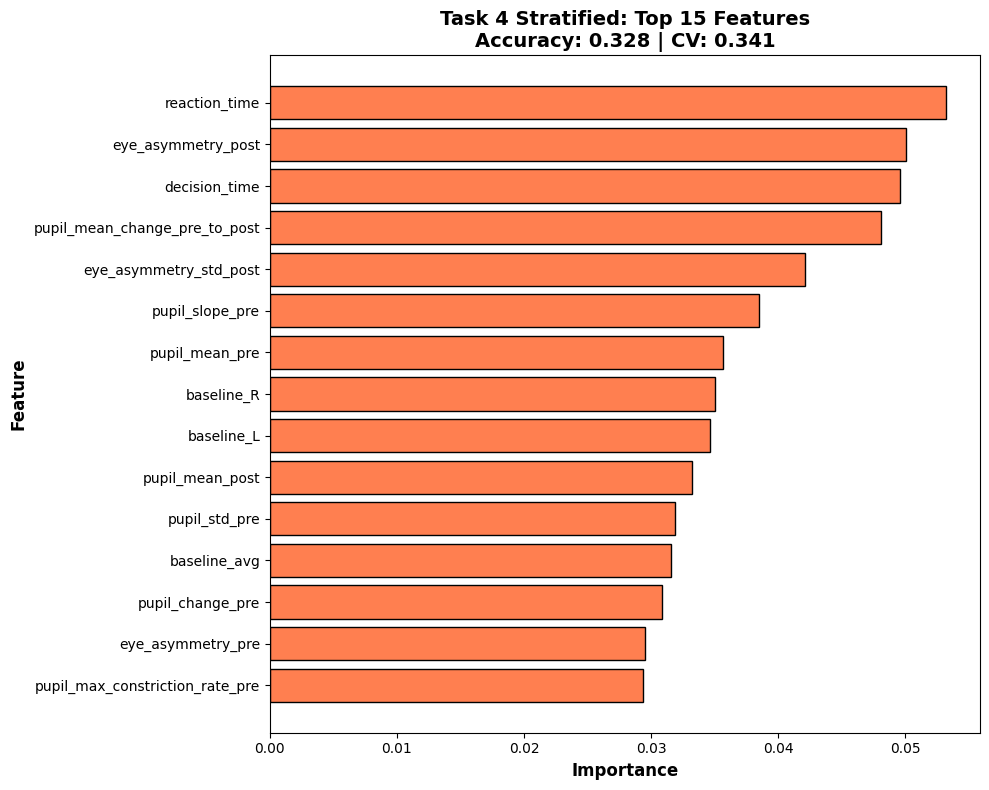

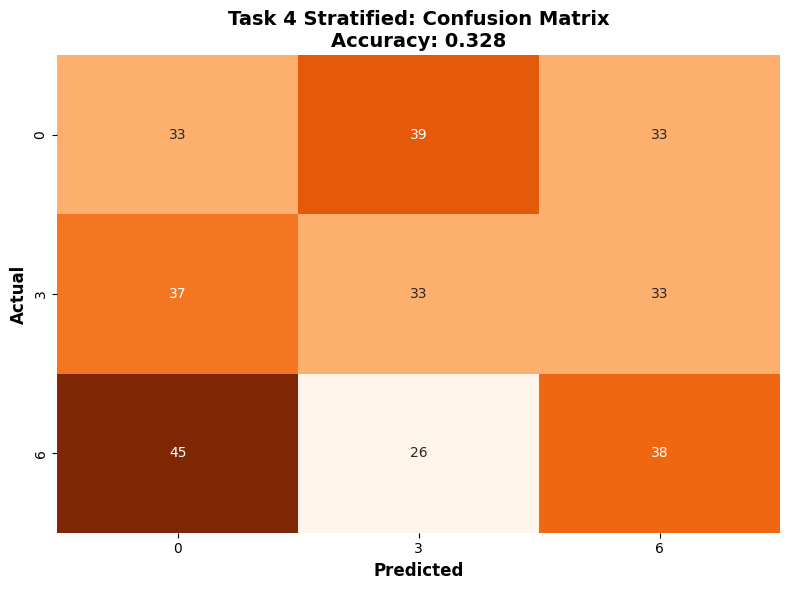

In [59]:
# =============================================================================
# TASK 4: BEHAVIOR + PHYSIOLOGY → AMBIGUITY - STRATIFIED SPLIT
# =============================================================================

print(f"\n{'='*80}")
print(f"TASK 4: BEHAVIOR + PHYSIOLOGY → AMBIGUITY - STRATIFIED")
print(f"{'='*80}")

# Use the same train/test indices from before
print(f"Train samples: {len(train_indices)}")
print(f"Test samples: {len(test_indices)}")

# Prepare combined data
X_combined_array = X_combined.values
y = ambiguity

# Split data
X_train_strat = X_combined_array[train_indices]
X_test_strat = X_combined_array[test_indices]
y_train_strat = y[train_indices]
y_test_strat = y[test_indices]

print(f"\nTrain distribution: KEEP={np.sum(y_train_strat==0)}, INVEST={np.sum(y_train_strat==1)}")
print(f"Test distribution: KEEP={np.sum(y_test_strat==0)}, INVEST={np.sum(y_test_strat==1)}")

# Train model
rf_strat_task4 = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced'
)

rf_strat_task4.fit(X_train_strat, y_train_strat)

# Predictions
y_pred_strat_task4 = rf_strat_task4.predict(X_test_strat)

# Evaluation
print(f"\n{'='*80}")
print(f"TASK 4 STRATIFIED RESULTS")
print(f"{'='*80}")
print("\nClassification Report:")
print(classification_report(y_test_strat, y_pred_strat_task4, target_names=['No Ambiguity (0)', 'Medium Ambiguity (3)', 'High Ambiguity (6)']))

accuracy_strat_task4 = accuracy_score(y_test_strat, y_pred_strat_task4)
f1_strat_task4 = f1_score(y_test_strat, y_pred_strat_task4, average='weighted')
print(f"\nAccuracy: {accuracy_strat_task4:.3f}")
print(f"F1 Score: {f1_strat_task4:.3f}")

# Cross-validation
cv_scores_strat_task4 = cross_val_score(rf_strat_task4, X_combined_array, y, cv=5, scoring='accuracy')
print(f"\nCross-validation scores: {cv_scores_strat_task4}")
print(f"Mean CV Accuracy: {cv_scores_strat_task4.mean():.3f} (+/- {cv_scores_strat_task4.std():.3f})")

# Feature importance
feature_importance_strat_task4 = pd.DataFrame({
    'feature': X_combined.columns,
    'importance': rf_strat_task4.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 15 Important Features:")
print(feature_importance_strat_task4.head(15).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(10, 8))
plt.barh(range(15), feature_importance_strat_task4['importance'].head(15)[::-1], color='coral', edgecolor='black')
plt.yticks(range(15), feature_importance_strat_task4['feature'].head(15)[::-1])
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title(f'Task 4 Stratified: Top 15 Features\nAccuracy: {accuracy_strat_task4:.3f} | CV: {cv_scores_strat_task4.mean():.3f}', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Confusion matrix
cm_strat_task4 = confusion_matrix(y_test_strat, y_pred_strat_task4)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_strat_task4, annot=True, fmt='d', cmap='Oranges', cbar=False,
            xticklabels=['0', '3', '6'], yticklabels=['0', '3', '6'], ax=ax)
ax.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax.set_title(f'Task 4 Stratified: Confusion Matrix\nAccuracy: {accuracy_strat_task4:.3f}', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


### Pre predict post


TASK 4: BEHAVIOR + PHYSIOLOGY → AMBIGUITY - STRATIFIED (PRE)

Total subjects: 10
Train samples: 727
Test samples: 317

Train distribution: KEEP=242, INVEST=0
Test distribution: KEEP=105, INVEST=0

TASK 4 STRATIFIED (PRE) RESULTS

Classification Report:
                      precision    recall  f1-score   support

    No Ambiguity (0)       0.35      0.41      0.38       105
Medium Ambiguity (3)       0.27      0.24      0.25       103
  High Ambiguity (6)       0.33      0.30      0.32       109

            accuracy                           0.32       317
           macro avg       0.32      0.32      0.32       317
        weighted avg       0.32      0.32      0.32       317


Accuracy: 0.319
F1 Score: 0.316

Cross-validation scores: [0.33971292 0.35885167 0.33492823 0.33971292 0.32692308]
Mean CV Accuracy: 0.340 (+/- 0.011)

Top 15 Important Features:
                        feature  importance
                  reaction_time    0.072699
               pupil_change_pre    0.0632

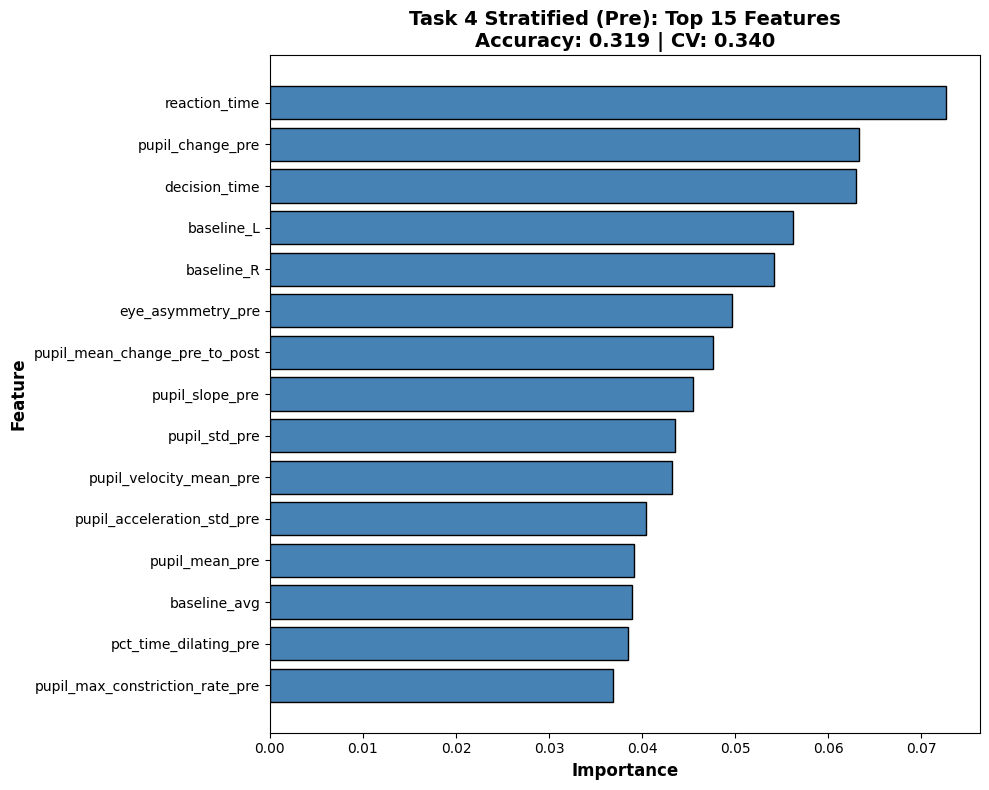

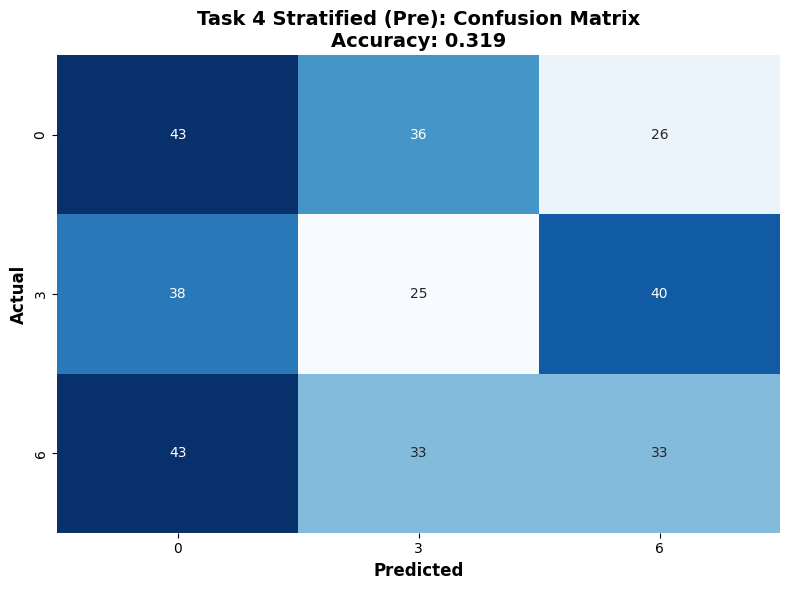

In [60]:
# =============================================================================
# TASK 4: BEHAVIOR + PHYSIOLOGY → AMBIGUITY - STRATIFIED SPLIT (Pre)
# =============================================================================

print(f"\n{'='*80}")
print(f"TASK 4: BEHAVIOR + PHYSIOLOGY → AMBIGUITY - STRATIFIED (PRE)")
print(f"{'='*80}")

# Get unique subjects
unique_subjects = physiology_df['subject_id'].unique()
print(f"\nTotal subjects: {len(unique_subjects)}")

# For each subject, take 70% for train, 30% for test
train_indices = []
test_indices = []

for subject in unique_subjects:
    subject_mask = physiology_df['subject_id'] == subject
    subject_indices = np.where(subject_mask)[0]
    
    # Get subject's ambiguity
    subject_ambiguity = ambiguity[subject_indices]
    
    # Stratified split for this subject
    if len(subject_indices) > 1:
        train_idx, test_idx = train_test_split(
            subject_indices, 
            test_size=0.3, 
            random_state=42,
            stratify=subject_ambiguity if len(np.unique(subject_ambiguity)) > 1 else None
        )
    else:
        # If only one sample, put in train
        train_idx = subject_indices
        test_idx = []
    
    train_indices.extend(train_idx)
    test_indices.extend(test_idx)

train_indices = np.array(train_indices)
test_indices = np.array(test_indices)

print(f"Train samples: {len(train_indices)}")
print(f"Test samples: {len(test_indices)}")

# Prepare combined data
X_combined_pre_array = X_combined_pre.values
y = ambiguity

# Split data
X_train_strat = X_combined_pre_array[train_indices]
X_test_strat = X_combined_pre_array[test_indices]
y_train_strat = y[train_indices]
y_test_strat = y[test_indices]

print(f"\nTrain distribution: KEEP={np.sum(y_train_strat==0)}, INVEST={np.sum(y_train_strat==1)}")
print(f"Test distribution: KEEP={np.sum(y_test_strat==0)}, INVEST={np.sum(y_test_strat==1)}")

# Train model
rf_strat_task4_pre = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced'
)

rf_strat_task4_pre.fit(X_train_strat, y_train_strat)

# Predictions
y_pred_strat_task4_pre = rf_strat_task4_pre.predict(X_test_strat)

# Evaluation
print(f"\n{'='*80}")
print(f"TASK 4 STRATIFIED (PRE) RESULTS")
print(f"{'='*80}")
print("\nClassification Report:")
print(classification_report(y_test_strat, y_pred_strat_task4_pre, target_names=['No Ambiguity (0)', 'Medium Ambiguity (3)', 'High Ambiguity (6)']))

accuracy_strat_task4_pre = accuracy_score(y_test_strat, y_pred_strat_task4_pre)
f1_strat_task4_pre = f1_score(y_test_strat, y_pred_strat_task4_pre, average='weighted')
print(f"\nAccuracy: {accuracy_strat_task4_pre:.3f}")
print(f"F1 Score: {f1_strat_task4_pre:.3f}")

# Cross-validation
cv_scores_strat_task4_pre = cross_val_score(rf_strat_task4_pre, X_combined_pre_array, y, cv=5, scoring='accuracy')
print(f"\nCross-validation scores: {cv_scores_strat_task4_pre}")
print(f"Mean CV Accuracy: {cv_scores_strat_task4_pre.mean():.3f} (+/- {cv_scores_strat_task4_pre.std():.3f})")

# Feature importance
feature_importance_strat_task4_pre = pd.DataFrame({
    'feature': X_combined_pre.columns,
    'importance': rf_strat_task4_pre.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 15 Important Features:")
print(feature_importance_strat_task4_pre.head(15).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(10, 8))
plt.barh(range(15), feature_importance_strat_task4_pre['importance'].head(15)[::-1], color='steelblue', edgecolor='black')
plt.yticks(range(15), feature_importance_strat_task4_pre['feature'].head(15)[::-1])
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title(f'Task 4 Stratified (Pre): Top 15 Features\nAccuracy: {accuracy_strat_task4_pre:.3f} | CV: {cv_scores_strat_task4_pre.mean():.3f}', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Confusion matrix
cm_strat_task4_pre = confusion_matrix(y_test_strat, y_pred_strat_task4_pre)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_strat_task4_pre, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['0', '3', '6'], yticklabels=['0', '3', '6'], ax=ax)
ax.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax.set_title(f'Task 4 Stratified (Pre): Confusion Matrix\nAccuracy: {accuracy_strat_task4_pre:.3f}', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


### Post predict post


TASK 4: BEHAVIOR + PHYSIOLOGY → AMBIGUITY - STRATIFIED (POST)
Train samples: 727
Test samples: 317

Train distribution: KEEP=242, INVEST=0
Test distribution: KEEP=105, INVEST=0

TASK 4 STRATIFIED (POST) RESULTS

Classification Report:
                      precision    recall  f1-score   support

    No Ambiguity (0)       0.33      0.34      0.33       105
Medium Ambiguity (3)       0.32      0.34      0.33       103
  High Ambiguity (6)       0.40      0.36      0.38       109

            accuracy                           0.35       317
           macro avg       0.35      0.35      0.35       317
        weighted avg       0.35      0.35      0.35       317


Accuracy: 0.347
F1 Score: 0.348

Cross-validation scores: [0.34449761 0.33971292 0.33492823 0.3492823  0.375     ]
Mean CV Accuracy: 0.349 (+/- 0.014)

Top 15 Important Features:
                       feature  importance
                 reaction_time    0.074535
            eye_asymmetry_post    0.072734
                 d

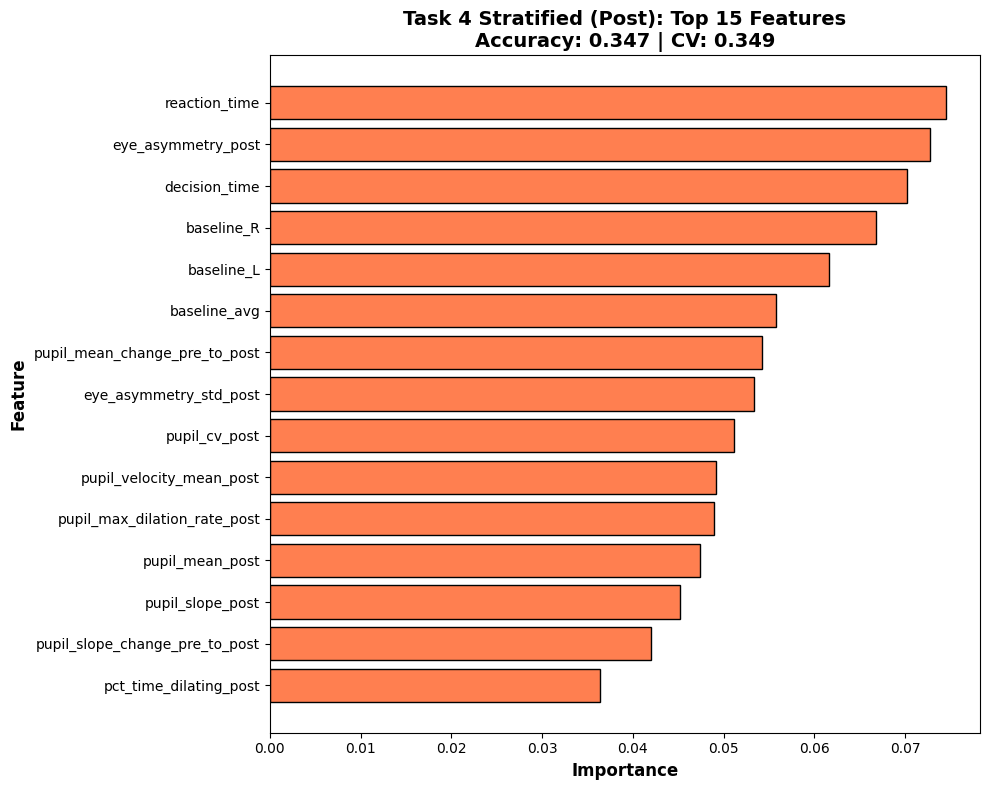

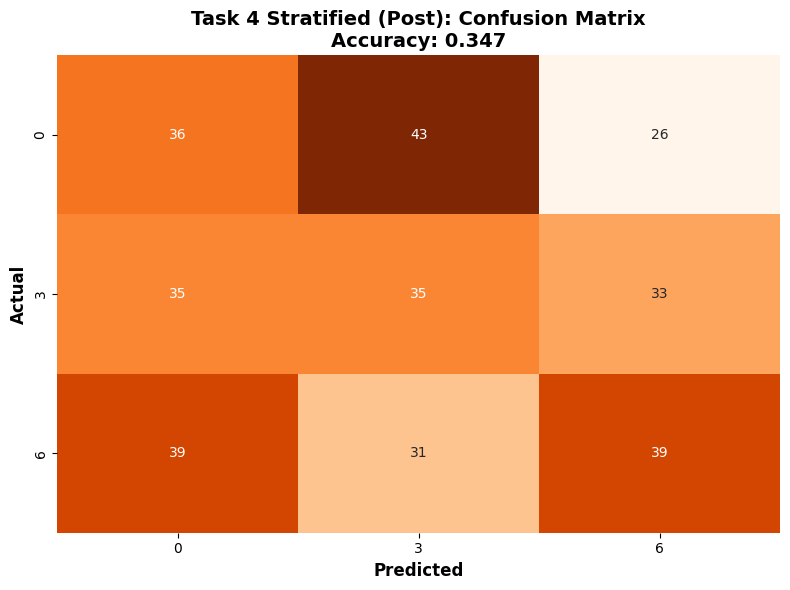

In [61]:
# =============================================================================
# TASK 4: BEHAVIOR + PHYSIOLOGY → AMBIGUITY - STRATIFIED SPLIT (Post)
# =============================================================================

print(f"\n{'='*80}")
print(f"TASK 4: BEHAVIOR + PHYSIOLOGY → AMBIGUITY - STRATIFIED (POST)")
print(f"{'='*80}")

# Use the same train/test indices from before
print(f"Train samples: {len(train_indices)}")
print(f"Test samples: {len(test_indices)}")

# Prepare combined data
X_combined_post_array = X_combined_post.values
y = ambiguity

# Split data
X_train_strat = X_combined_post_array[train_indices]
X_test_strat = X_combined_post_array[test_indices]
y_train_strat = y[train_indices]
y_test_strat = y[test_indices]

print(f"\nTrain distribution: KEEP={np.sum(y_train_strat==0)}, INVEST={np.sum(y_train_strat==1)}")
print(f"Test distribution: KEEP={np.sum(y_test_strat==0)}, INVEST={np.sum(y_test_strat==1)}")

# Train model
rf_strat_task4_post = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced'
)

rf_strat_task4_post.fit(X_train_strat, y_train_strat)

# Predictions
y_pred_strat_task4_post = rf_strat_task4_post.predict(X_test_strat)

# Evaluation
print(f"\n{'='*80}")
print(f"TASK 4 STRATIFIED (POST) RESULTS")
print(f"{'='*80}")
print("\nClassification Report:")
print(classification_report(y_test_strat, y_pred_strat_task4_post, target_names=['No Ambiguity (0)', 'Medium Ambiguity (3)', 'High Ambiguity (6)']))

accuracy_strat_task4_post = accuracy_score(y_test_strat, y_pred_strat_task4_post)
f1_strat_task4_post = f1_score(y_test_strat, y_pred_strat_task4_post, average='weighted')
print(f"\nAccuracy: {accuracy_strat_task4_post:.3f}")
print(f"F1 Score: {f1_strat_task4_post:.3f}")

# Cross-validation
cv_scores_strat_task4_post = cross_val_score(rf_strat_task4_post, X_combined_post_array, y, cv=5, scoring='accuracy')
print(f"\nCross-validation scores: {cv_scores_strat_task4_post}")
print(f"Mean CV Accuracy: {cv_scores_strat_task4_post.mean():.3f} (+/- {cv_scores_strat_task4_post.std():.3f})")

# Feature importance
feature_importance_strat_task4_post = pd.DataFrame({
    'feature': X_combined_post.columns,
    'importance': rf_strat_task4_post.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 15 Important Features:")
print(feature_importance_strat_task4_post.head(15).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(10, 8))
plt.barh(range(15), feature_importance_strat_task4_post['importance'].head(15)[::-1], color='coral', edgecolor='black')
plt.yticks(range(15), feature_importance_strat_task4_post['feature'].head(15)[::-1])
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title(f'Task 4 Stratified (Post): Top 15 Features\nAccuracy: {accuracy_strat_task4_post:.3f} | CV: {cv_scores_strat_task4_post.mean():.3f}', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Confusion matrix
cm_strat_task4_post = confusion_matrix(y_test_strat, y_pred_strat_task4_post)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_strat_task4_post, annot=True, fmt='d', cmap='Oranges', cbar=False,
            xticklabels=['0', '3', '6'], yticklabels=['0', '3', '6'], ax=ax)
ax.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax.set_title(f'Task 4 Stratified (Post): Confusion Matrix\nAccuracy: {accuracy_strat_task4_post:.3f}', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## Comparison


TASK 4: BEHAVIOR + PHYSIOLOGY → AMBIGUITY - ALL METHODS COMPARISON


TASK 4 RESULTS COMPARISON:
          Method Features  Accuracy  F1_Score
    Random Split      Pre  0.308917  0.307439
    Random Split     Post  0.328025  0.324172
            LOSO      Pre  0.337208  0.295021
            LOSO     Post  0.347370  0.316969
Stratified Split      Pre  0.318612  0.315965
Stratified Split     Post  0.347003  0.347775


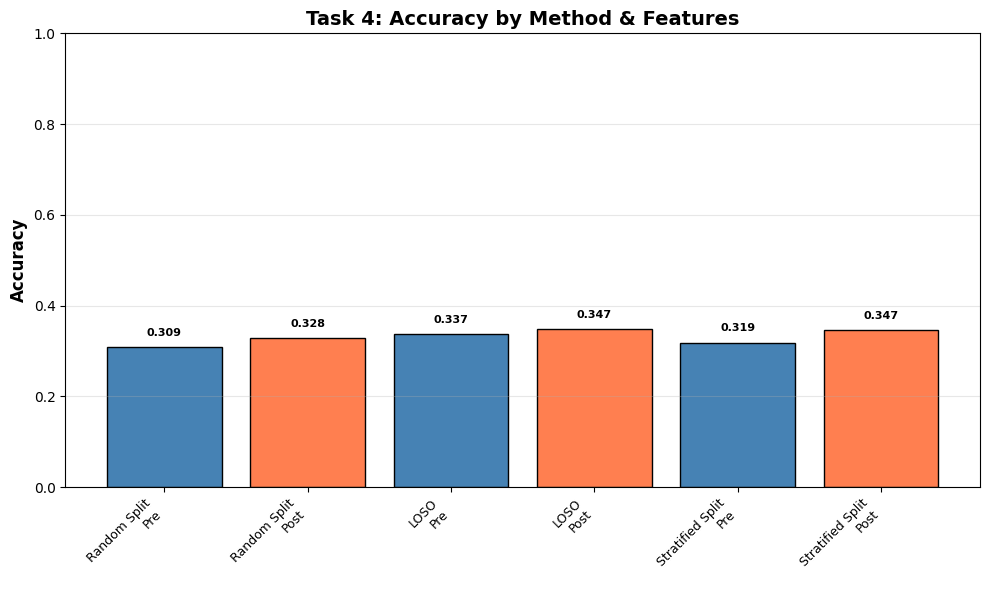


KEY FINDINGS:
Best performing method: LOSO with Post features
Accuracy: 0.347

Pre vs Post features comparison:
  Average Accuracy (Pre): 0.322
  Average Accuracy (Post): 0.341


In [63]:
# =============================================================================
# TASK 4 RESULTS SUMMARY - ALL METHODS COMPARISON
# =============================================================================

print(f"\n{'='*80}")
print(f"TASK 4: BEHAVIOR + PHYSIOLOGY → AMBIGUITY - ALL METHODS COMPARISON")
print(f"{'='*80}\n")

# Collect all Task 4 results
task4_results = []

# Random Split - Pre
task4_results.append({
    'Method': 'Random Split',
    'Features': 'Pre',
    'Accuracy': accuracy_combined_pre,
    'F1_Score': f1_combined_pre
})

# Random Split - Post
task4_results.append({
    'Method': 'Random Split',
    'Features': 'Post',
    'Accuracy': accuracy_combined_post,
    'F1_Score': f1_combined_post
})

# LOSO - Pre
task4_results.append({
    'Method': 'LOSO',
    'Features': 'Pre',
    'Accuracy': loso_df_task4_pre['accuracy'].mean(),
    'F1_Score': loso_df_task4_pre['f1_score'].mean()
})

# LOSO - Post
task4_results.append({
    'Method': 'LOSO',
    'Features': 'Post',
    'Accuracy': loso_df_task4_post['accuracy'].mean(),
    'F1_Score': loso_df_task4_post['f1_score'].mean()
})

# Stratified - Pre
task4_results.append({
    'Method': 'Stratified Split',
    'Features': 'Pre',
    'Accuracy': accuracy_strat_task4_pre,
    'F1_Score': f1_strat_task4_pre
})

# Stratified - Post
task4_results.append({
    'Method': 'Stratified Split',
    'Features': 'Post',
    'Accuracy': accuracy_strat_task4_post,
    'F1_Score': f1_strat_task4_post
})

# Create DataFrame
task4_comparison_df = pd.DataFrame(task4_results)

print("\nTASK 4 RESULTS COMPARISON:")
print(task4_comparison_df.to_string(index=False))

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Accuracy comparison
x_pos = np.arange(len(task4_comparison_df))
colors = ['steelblue' if feat == 'Pre' else 'coral' for feat in task4_comparison_df['Features']]
ax.bar(x_pos, task4_comparison_df['Accuracy'], color=colors, edgecolor='black')
ax.set_xticks(x_pos)
ax.set_xticklabels([f"{row['Method']}\n{row['Features']}" for _, row in task4_comparison_df.iterrows()], 
                     rotation=45, ha='right', fontsize=9)
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Task 4: Accuracy by Method & Features', fontsize=14, fontweight='bold')
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(task4_comparison_df['Accuracy']):
    ax.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

# F1 Score comparison
ax2.bar(x_pos, task4_comparison_df['F1_Score'], color=colors, edgecolor='black')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f"{row['Method']}\n{row['Features']}" for _, row in task4_comparison_df.iterrows()], 
                     rotation=45, ha='right', fontsize=9)
ax2.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
ax2.set_title('Task 4: F1 Score by Method & Features', fontsize=14, fontweight='bold')
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(task4_comparison_df['F1_Score']):
    ax2.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("KEY FINDINGS:")
print("="*80)
best_idx = task4_comparison_df['Accuracy'].idxmax()
best_method = task4_comparison_df.loc[best_idx, 'Method']
best_features = task4_comparison_df.loc[best_idx, 'Features']
best_accuracy = task4_comparison_df.loc[best_idx, 'Accuracy']
print(f"Best performing method: {best_method} with {best_features} features")
print(f"Accuracy: {best_accuracy:.3f}")

# Compare Pre vs Post
print(f"\nPre vs Post features comparison:")
pre_mean = task4_comparison_df[task4_comparison_df['Features'] == 'Pre']['Accuracy'].mean()
post_mean = task4_comparison_df[task4_comparison_df['Features'] == 'Post']['Accuracy'].mean()
print(f"  Average Accuracy (Pre): {pre_mean:.3f}")
print(f"  Average Accuracy (Post): {post_mean:.3f}")
